# DOC2VEC model Training

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();
import json
import os.path
from tqdm import notebook, trange

# Loading Movielens Data

In [2]:
movies_filename = '/Users/dbikiel/PycharmProjects/MovieDatabase/ml-25m/movies.csv'
movies_df = pd.read_csv(movies_filename)
ids_filename = '/Users/dbikiel/PycharmProjects/MovieDatabase/ml-25m/links.csv'
ids_df = pd.read_csv(ids_filename, dtype=str)
ratings_filename = '/Users/dbikiel/PycharmProjects/MovieDatabase/ml-25m/ratings.csv'
ratings_df = pd.read_csv(ratings_filename)
#top_viewed_and_rated_10000 = ratings_df.groupby('movieId')['rating'].agg(['mean','std','count']).sort_values(by=['count','mean'], ascending=False).head(10000)

# Convert json pulled data to dict

In [5]:
def json_to_dict(filename, directory):
    """
    Converts the json files obtained from the TMDB API call to python dict to extract relevant information easier
    """
    res = {'tmdb_id':'',
           'imdb_id':'',
           'title':'',
           'year':'',
           'budget':'',
           'genres':'',
          'overview':'',
           'popularity':'',
          'revenue':'',
          'vote_average':'',
          'vote_count':'',
          'keywords':'',
          'similar_tmdbId':'',
          'recommendations_tmdbId':'',
          'actors':'',
          'characters':'',
          'director':'',
           'producer':'',
          'writer':''}

    f = directory + filename
    
    if not os.path.isfile(f):
        return res
    
    #with open(f) as file:
    #with open(f, "r", encoding="utf-8") as file:
    with open(f, "rb") as file:
        data = file.read()
        r = json.loads(data)
        
    res['tmdb_id'] = r['id'] #tmdb id
    res['imdb_id'] = r['imdb_id'] #imdb id
    res['title'] = r['title'] #title
    res['year'] = r['release_date'][:4] #year
    res['budget'] = r['budget'] #budget
    res['genres'] = '|'.join([i['name'] for i in r['genres']]) #genres
    res['overview'] = r['overview'].strip()
    res['popularity'] = r['popularity']
    res['revenue'] = r['revenue']
    res['vote_average'] = r['vote_average']
    res['vote_count'] = r['vote_count']
    res['keywords'] = '|'.join([i['name'] for i in r['keywords']['keywords']])
    res['similar_tmdbId'] = '|'.join([str(i['id']) for i in r['similar']['results']])
    #res['similar_title'] = '|'.join([str(i['title']) for i in r['similar']['results']])
    res['recommendations_tmdbId'] = '|'.join([str(i['id']) for i in r['recommendations']['results']])
    #res['recommendations_title'] = '|'.join([str(i['title']) for i in r['recommendations']['results']])
    
    #Now the credits
    cast = r['credits']['cast']
    n = min(10,len(cast))
    
    actors = []
    characters = []
    for i in range(n):
        actors.append(r['credits']['cast'][i]['name'])
        characters.append(r['credits']['cast'][i]['character'])        
        
    
    res['actors'] = '|'.join(actors)
    res['characters'] = '|'.join(characters)    
    
    #Director, Executive Producer and Writer
    director = []
    producer = []
    writer = []
    
    for i in r['credits']['crew']:
        if i['job'] == 'Director':
            director.append(i['name'])
        elif i['job'] == 'Executive Producer':
            producer.append(i['name'])
        elif i['job'] == 'Writer':
            writer.append(i['name'])
            
    res['director'] = '|'.join(director)
    res['producer'] = '|'.join(producer)
    res['writer'] = '|'.join(writer)
            
    return res

# Get the list of imdb and tmdb movies

In [3]:
tmdbId_list = [tmdbId for tmdbId in list(ids_df.tmdbId)]
imdbId_list = [imdbId for imdbId in list(ids_df.imdbId)]
movieId_list = [movieId for movieId in list(ids_df.movieId)]

# Creates the overview dataframe

In [6]:
directory_TMDB = '/Users/dbikiel/Documents/Insight-Local/notebooks/TMDB-overviews-62K/'
df_overview = pd.DataFrame([json_to_dict(str(i)+'.txt', directory_TMDB) for i in tmdbId_list])
df_overview['movieId'] = ids_df.movieId
df_overview

,tmdb_id,imdb_id,title,year,budget,genres,overview,popularity,revenue,vote_average,vote_count,keywords,similar_tmdbId,recommendations_tmdbId,actors,characters,director,producer,writer,movieId
0,862,tt0114709,Toy Story,1995,30000000,Animation|Comedy|Family,"Led by Woody, Andy's toys live happily in his ...",31.451,373554033,7.9,11534,martial arts|jealousy|toy|boy|friendship|bully...,68718|50544|13523|9986|7549|605|10895|9470|228...,863|10193|585|12|9806|2062|808|920|9487|425|80...,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,Woody (voice)|Buzz Lightyear (voice)|Mr. Potat...,John Lasseter,Ed Catmull|Steve Jobs,,1
1,8844,tt0113497,Jumanji,1995,65000000,Adventure|Fantasy|Family,When siblings Judy and Peter discover an encha...,8.481,262797249,7.2,6684,giant insect|board game|jungle|disappearance|r...,353486|37135|258489|15657|13683|26845|18994|40...,788|879|1593|854|2300|772|9738|771|564|18360|8...,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Alan Parrish|Samuel Alan Parrish / Van Pelt|Ju...,Joe Johnston,Larry J. Franco|Ted Field|Robert W. Cort,,2
2,15602,tt0113228,Grumpier Old Men,1995,0,Romance|Comedy,A family wedding reignites the ancient feud be...,11.982,0,6.6,183,fishing|old man|best friend|duringcreditsstinger,200727|80038|9982|1267|40807|177572|888|376660...,11520|2054|11310|1406|13203|10478|11821|10765|...,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Max Goldman|John Gustafson|Ariel Gustafson|Mar...,Howard Deutch,,Mark Steven Johnson,3
3,31357,tt0114885,Waiting to Exhale,1995,16000000,Comedy|Drama|Romance,"Cheated on, mistreated and stepped on, the wom...",7.047,81452156,6.2,67,based on novel or book|interracial relationshi...,281957|450322|656968|769|399121|4836|101299|33...,15513|117553|21539|75531|4968|47608|61536|4558...,Whitney Houston|Angela Bassett|Loretta Devine|...,Savannah 'Vannah' Jackson|Bernadine 'Bernie' H...,Forest Whitaker,Terry McMillan,,4
4,11862,tt0113041,Father of the Bride Part II,1995,0,Comedy,Just when George Banks has recovered from his ...,11.365,76578911,6.2,368,parent child relationship|baby|midlife crisis|...,433|49519|400579|8545|1257|8346|2758|95610|206...,11846|11630|12154|11472|10407|11894|1552|2064|...,Steve Martin|Diane Keaton|Martin Short|Kimberl...,George Banks|Nina Banks|Franck Eggelhoffer|Ann...,Charles Shyer,,,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,499546,tt6671244,We,2018,0,Drama,During a scorching summer in a Belgian-Dutch b...,4.003,0,6.3,14,,,,Pauline Casteleyn|Aimé Claeys|Gaia Sofia Cozij...,Liesl|Thomas|Sarah|Martin|Femke|Ena|Jens|Loesj...,Rene Eller,,Rene Eller,209157
62419,63407,tt0297986,Window of the Soul,2001,0,Documentary,Nineteen people with differing degrees of visu...,1.421,0,7.3,8,,,230374|551306|326193|303798|55060|268282|53029...,José Saramago|Marieta Severo|Agnès Varda|Wim W...,Himself|Herself|Herself|Himself|Himself|Himsel...,Walter Carvalho|João Jardim,,Walter Carvalho|João Jardim,209159
62420,553036,tt6755366,Bad Poems,2018,0,Comedy|Drama,"33-years old Tamás Merthner is heartbroken, af...",1.345,0,5.7,3,,,,Gábor Reisz|Katica Nagy|Niels Schneider|Zsolt ...,Merthner Tamás|Csák Anna|Henri|Apa|Anya,Gábor Reisz,,Gábor Reisz,209163
62421,162892,tt0249603,A Girl Thing,2001,0,,A Girl Thing is a mini-series that revolves ar...,0.798,0,4.3,3,,,,Kate Capshaw|Stockard Channing|Rebecca De Morn...,Casey Montgomery|Dr. Beth Noonan|Kim McCormack...,Lee Rose,,,209169


In [7]:
df_overview['overview'].iloc[0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

# Creates the summaries df

In [613]:
plots = []
for movie in imdbId_list:
    try:
        with open('/Users/dbikiel/Documents/Insight-Local/notebooks/IMDB-plots-62K/tt' + str(movie)+'.txt','r') as m:
            plot = list(m)
            plot = [p.strip() for p in plot]
    except:
        plot = []
    plots.append(plot)

In [614]:
summaries = {movie:''.join(p) for (movie, p) in zip(imdbId_list,plots)}
summaries_df = pd.DataFrame(list(summaries.items()), columns=['movieId', 'summaries'])
summaries_df

,movieId,summaries
0,0114709,A cowboy doll is profoundly threatened and jea...
1,0113497,When two kids find and play a magical board ga...
2,0113228,John and Max resolve to save their beloved bai...
3,0114885,"Based on Terry McMillan's novel, this film fol..."
4,0113041,George Banks must deal not only with the pregn...
...,...,...
62418,6671244,Eight teens - four guys and four girls - are t...
62419,0297986,Nineteen people with differing degrees of visu...
62420,6755366,"33-years old Tamás Merthner is heartbroken, af..."
62421,0249603,A Girl Thing is a mini-series that revolves ar...


# Create a full dataframe with movieId, title, overview and summary

In [617]:
title = movies_df.title
overview = df_overview.overview
summary = summaries_df.summaries
full_plots = pd.DataFrame({'movieId': movieId_list, 'title':title, 'overview':overview, 'summary':summary})
#full_plots.to_csv('movielens_62K_titles_overviews_summaries.csv', encoding = 'utf-8')
full_plots.to_json('movielens_62K_titles_overviews_summaries.json')
full_plots

,movieId,title,overview,summary
0,1,Toy Story (1995),"Led by Woody, Andy's toys live happily in his ...",A cowboy doll is profoundly threatened and jea...
1,2,Jumanji (1995),When siblings Judy and Peter discover an encha...,When two kids find and play a magical board ga...
2,3,Grumpier Old Men (1995),A family wedding reignites the ancient feud be...,John and Max resolve to save their beloved bai...
3,4,Waiting to Exhale (1995),"Cheated on, mistreated and stepped on, the wom...","Based on Terry McMillan's novel, this film fol..."
4,5,Father of the Bride Part II (1995),Just when George Banks has recovered from his ...,George Banks must deal not only with the pregn...
...,...,...,...,...
62418,209157,We (2018),During a scorching summer in a Belgian-Dutch b...,Eight teens - four guys and four girls - are t...
62419,209159,Window of the Soul (2001),Nineteen people with differing degrees of visu...,Nineteen people with differing degrees of visu...
62420,209163,Bad Poems (2018),"33-years old Tamás Merthner is heartbroken, af...","33-years old Tamás Merthner is heartbroken, af..."
62421,209169,A Girl Thing (2001),A Girl Thing is a mini-series that revolves ar...,A Girl Thing is a mini-series that revolves ar...


In [14]:
print(full_plots.iloc[62419].overview, full_plots.iloc[62419].summary)

Nineteen people with differing degrees of visual impairment – from mild nearsightedness to total blindness – discuss how they see themselves, how they see others and how they perceive the world. Unusual images, of burning trees or empty deserts, link the interviews, which vary from deep to funny to poetic. Nineteen people with differing degrees of visual impairment - from mild nearsightedness to total blindness - discuss how they see themselves, how they see others and how they perceive the world. Writer and Nobel laureate José Saramago, musician Hermeto Paschoal, filmmaker Wim Wenders, blind Franco-Slovenian photographer Evgen Bavcar, neurologist Oliver Sacks, actress Marieta Severo, blind city councilman Arnaldo Godoy, among others, make personal and surprising revelations about various aspects of vision - the physiological working of the eye; the use of glasses and what it means about personality; the meaning of seeing or not seeing in a world saturated by images; and, also, the imp

# Model Training

I will use gensim doc2vec implementation

In [23]:
import gensim
import gensim.downloader as api

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [25]:
titles = list(full_plots.title)

## Create corpus

In [331]:
full_plots.fillna(value='', inplace=True)
full_plots.to_csv('full_plots.csv', encoding='utf-8')

In [27]:
plots = [over + '\n' +  summary for (over,summary) in zip(full_plots.overview,full_plots.summary)] 

## Preprocessing of all plots

In [28]:
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
import multiprocessing

In [29]:
download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

[nltk_data] Downloading package punkt to /Users/dbikiel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dbikiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
corpus = []
for i, line in enumerate(plots):
#for i, line in enumerate(plots_10K):
    #tokens = gensim.parsing.preprocessing.preprocess_string(line)
    tokens = preprocess(line)    
    corpus.append(gensim.models.doc2vec.TaggedDocument(tokens, [i]))


## Initialization of model



I will run a model with a vector size of 100, using the distributed bags of word approach (dm = 0) which is a bit faster than the PV-DM.

In [31]:
model = gensim.models.doc2vec.Doc2Vec(dm=0, dbow_words=1, min_count=10, negative=3,
                hs=0, sample=1e-4, window=10, vector_size=100, workers=8)

### Build vocabulary

In [32]:
model.build_vocab(corpus)

2020-01-23 01:08:53,592 : INFO : collecting all words and their counts
2020-01-23 01:08:53,594 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-01-23 01:08:54,352 : INFO : PROGRESS: at example #10000, processed 3873410 words (5114900/s), 86521 word types, 10000 tags
2020-01-23 01:08:54,951 : INFO : PROGRESS: at example #20000, processed 6638427 words (4622036/s), 116734 word types, 20000 tags
2020-01-23 01:08:55,311 : INFO : PROGRESS: at example #30000, processed 8330536 words (4703592/s), 133043 word types, 30000 tags
2020-01-23 01:08:55,586 : INFO : PROGRESS: at example #40000, processed 9589078 words (4596438/s), 149103 word types, 40000 tags
2020-01-23 01:08:55,945 : INFO : PROGRESS: at example #50000, processed 10879699 words (3603182/s), 162756 word types, 50000 tags
2020-01-23 01:08:56,224 : INFO : PROGRESS: at example #60000, processed 11996020 words (4016447/s), 174675 word types, 60000 tags
2020-01-23 01:08:56,290 : INFO : collected 177202 

In [33]:
model.train(corpus, total_examples = model.corpus_count, epochs = 500)
#model.train(corpus, total_examples = 5000, epochs = 40)

2020-01-23 01:11:28,637 : INFO : training model with 8 workers on 46554 vocabulary and 100 features, using sg=1 hs=0 sample=0.0001 negative=3 window=10
2020-01-23 01:11:29,663 : INFO : EPOCH 1 - PROGRESS: at 2.00% examples, 429876 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:11:30,666 : INFO : EPOCH 1 - PROGRESS: at 3.85% examples, 452587 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:11:31,680 : INFO : EPOCH 1 - PROGRESS: at 5.79% examples, 456563 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:11:32,681 : INFO : EPOCH 1 - PROGRESS: at 8.18% examples, 456986 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:11:33,696 : INFO : EPOCH 1 - PROGRESS: at 10.81% examples, 452915 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:11:34,704 : INFO : EPOCH 1 - PROGRESS: at 13.28% examples, 448188 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:11:35,724 : INFO : EPOCH 1 - PROGRESS: at 16.46% examples, 445216 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:11:36,766 : INFO : EPOCH 1 - PROGRESS: a

2020-01-23 01:12:27,889 : INFO : EPOCH 3 - PROGRESS: at 10.64% examples, 318597 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:12:28,907 : INFO : EPOCH 3 - PROGRESS: at 12.53% examples, 320108 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:12:29,913 : INFO : EPOCH 3 - PROGRESS: at 14.73% examples, 318994 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:12:30,933 : INFO : EPOCH 3 - PROGRESS: at 16.80% examples, 316404 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:12:31,935 : INFO : EPOCH 3 - PROGRESS: at 18.80% examples, 319711 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:12:32,937 : INFO : EPOCH 3 - PROGRESS: at 20.63% examples, 320314 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:12:33,994 : INFO : EPOCH 3 - PROGRESS: at 22.63% examples, 318136 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:12:34,997 : INFO : EPOCH 3 - PROGRESS: at 25.29% examples, 318394 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:12:36,002 : INFO : EPOCH 3 - PROGRESS: at 27.98% examples, 317232 words/s,

2020-01-23 01:13:26,706 : INFO : EPOCH 5 - PROGRESS: at 11.58% examples, 337805 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:13:27,706 : INFO : EPOCH 5 - PROGRESS: at 13.83% examples, 341438 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:13:28,713 : INFO : EPOCH 5 - PROGRESS: at 16.63% examples, 344811 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:13:29,727 : INFO : EPOCH 5 - PROGRESS: at 18.62% examples, 345366 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:13:30,739 : INFO : EPOCH 5 - PROGRESS: at 20.63% examples, 345959 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:13:31,754 : INFO : EPOCH 5 - PROGRESS: at 22.33% examples, 338947 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:13:32,771 : INFO : EPOCH 5 - PROGRESS: at 24.65% examples, 335656 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:13:33,802 : INFO : EPOCH 5 - PROGRESS: at 27.45% examples, 332896 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:13:34,802 : INFO : EPOCH 5 - PROGRESS: at 30.55% examples, 333020 words/s,

2020-01-23 01:14:25,206 : INFO : EPOCH 7 - PROGRESS: at 24.08% examples, 394208 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:14:26,234 : INFO : EPOCH 7 - PROGRESS: at 27.82% examples, 394872 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:14:27,260 : INFO : EPOCH 7 - PROGRESS: at 31.78% examples, 395866 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:14:28,261 : INFO : EPOCH 7 - PROGRESS: at 35.07% examples, 395906 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:14:29,284 : INFO : EPOCH 7 - PROGRESS: at 39.24% examples, 393780 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:14:30,290 : INFO : EPOCH 7 - PROGRESS: at 44.00% examples, 389766 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:14:31,372 : INFO : EPOCH 7 - PROGRESS: at 49.14% examples, 386063 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:14:32,390 : INFO : EPOCH 7 - PROGRESS: at 55.02% examples, 384704 words/s, in_qsize 14, out_qsize 1
2020-01-23 01:14:33,402 : INFO : EPOCH 7 - PROGRESS: at 60.98% examples, 383413 words/s,

2020-01-23 01:15:24,633 : INFO : EPOCH 9 - PROGRESS: at 64.71% examples, 394989 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:15:25,645 : INFO : EPOCH 9 - PROGRESS: at 70.52% examples, 394028 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:15:26,673 : INFO : EPOCH 9 - PROGRESS: at 76.24% examples, 391673 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:15:27,674 : INFO : EPOCH 9 - PROGRESS: at 82.77% examples, 391281 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:15:28,699 : INFO : EPOCH 9 - PROGRESS: at 88.85% examples, 388558 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:15:29,704 : INFO : EPOCH 9 - PROGRESS: at 95.63% examples, 387520 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:15:30,202 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:15:30,215 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:15:30,222 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:15:30,238 : INFO : worker thr

2020-01-23 01:16:20,466 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:16:20,482 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:16:20,495 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:16:20,514 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:16:20,524 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:16:20,529 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:16:20,530 : INFO : EPOCH - 11 : training on 12242471 raw words (9659537 effective words) took 24.8s, 389948 effective words/s
2020-01-23 01:16:21,545 : INFO : EPOCH 12 - PROGRESS: at 1.91% examples, 395307 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:16:22,546 : INFO : EPOCH 12 - PROGRESS: at 3.60% examples, 417033 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:16:23,570 : INFO : EPOCH 12 - PROGRESS: at 5.27% examples, 415137 words/

2020-01-23 01:17:14,111 : INFO : EPOCH 14 - PROGRESS: at 7.12% examples, 409605 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:17:15,132 : INFO : EPOCH 14 - PROGRESS: at 9.53% examples, 412812 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:17:16,156 : INFO : EPOCH 14 - PROGRESS: at 11.98% examples, 412346 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:17:17,162 : INFO : EPOCH 14 - PROGRESS: at 14.73% examples, 410679 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:17:18,188 : INFO : EPOCH 14 - PROGRESS: at 17.57% examples, 412283 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:17:19,226 : INFO : EPOCH 14 - PROGRESS: at 19.96% examples, 412147 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:17:20,237 : INFO : EPOCH 14 - PROGRESS: at 22.60% examples, 412684 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:17:21,237 : INFO : EPOCH 14 - PROGRESS: at 25.79% examples, 409862 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:17:22,240 : INFO : EPOCH 14 - PROGRESS: at 29.40% examples, 409200 w

2020-01-23 01:18:13,029 : INFO : EPOCH 16 - PROGRESS: at 33.48% examples, 407918 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:18:14,036 : INFO : EPOCH 16 - PROGRESS: at 37.23% examples, 407492 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:18:15,038 : INFO : EPOCH 16 - PROGRESS: at 42.25% examples, 404935 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:18:16,042 : INFO : EPOCH 16 - PROGRESS: at 48.03% examples, 403562 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:18:17,096 : INFO : EPOCH 16 - PROGRESS: at 53.91% examples, 401386 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:18:18,098 : INFO : EPOCH 16 - PROGRESS: at 59.88% examples, 399809 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:18:19,118 : INFO : EPOCH 16 - PROGRESS: at 65.76% examples, 396119 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:18:20,128 : INFO : EPOCH 16 - PROGRESS: at 71.38% examples, 394772 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:18:21,128 : INFO : EPOCH 16 - PROGRESS: at 77.30% examples, 392854

2020-01-23 01:19:11,348 : INFO : EPOCH 18 - PROGRESS: at 78.02% examples, 396989 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:19:12,361 : INFO : EPOCH 18 - PROGRESS: at 84.41% examples, 395874 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:19:13,370 : INFO : EPOCH 18 - PROGRESS: at 91.11% examples, 394588 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:19:14,428 : INFO : EPOCH 18 - PROGRESS: at 98.38% examples, 393004 words/s, in_qsize 10, out_qsize 0
2020-01-23 01:19:14,472 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:19:14,475 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:19:14,494 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:19:14,512 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:19:14,525 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:19:14,552 : INFO : worker thread finished; awaiting finish of 2 more th

2020-01-23 01:20:03,905 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:20:03,914 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:20:03,915 : INFO : EPOCH - 20 : training on 12242471 raw words (9658285 effective words) took 24.9s, 387327 effective words/s
2020-01-23 01:20:04,924 : INFO : EPOCH 21 - PROGRESS: at 1.96% examples, 421931 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:20:05,929 : INFO : EPOCH 21 - PROGRESS: at 3.64% examples, 421626 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:20:06,940 : INFO : EPOCH 21 - PROGRESS: at 5.27% examples, 417449 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:20:07,954 : INFO : EPOCH 21 - PROGRESS: at 7.20% examples, 410479 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:20:08,968 : INFO : EPOCH 21 - PROGRESS: at 9.43% examples, 409573 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:20:09,971 : INFO : EPOCH 21 - PROGRESS: at 11.88% examples, 410904 words/s, in_qsize 15, out_q

2020-01-23 01:20:59,983 : INFO : EPOCH 23 - PROGRESS: at 15.07% examples, 416378 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:21:00,997 : INFO : EPOCH 23 - PROGRESS: at 17.88% examples, 419029 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:21:02,033 : INFO : EPOCH 23 - PROGRESS: at 20.24% examples, 417303 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:21:03,038 : INFO : EPOCH 23 - PROGRESS: at 22.94% examples, 417429 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:21:04,052 : INFO : EPOCH 23 - PROGRESS: at 26.44% examples, 415917 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:21:05,063 : INFO : EPOCH 23 - PROGRESS: at 30.04% examples, 414446 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:21:06,073 : INFO : EPOCH 23 - PROGRESS: at 33.72% examples, 413576 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:21:07,131 : INFO : EPOCH 23 - PROGRESS: at 37.70% examples, 412471 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:21:08,143 : INFO : EPOCH 23 - PROGRESS: at 43.17% examples, 410844

2020-01-23 01:21:59,227 : INFO : EPOCH 25 - PROGRESS: at 54.05% examples, 404382 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:00,239 : INFO : EPOCH 25 - PROGRESS: at 59.88% examples, 401994 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:01,252 : INFO : EPOCH 25 - PROGRESS: at 66.40% examples, 400279 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:02,262 : INFO : EPOCH 25 - PROGRESS: at 72.62% examples, 400208 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:03,297 : INFO : EPOCH 25 - PROGRESS: at 78.71% examples, 398498 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:04,301 : INFO : EPOCH 25 - PROGRESS: at 84.53% examples, 395782 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:05,310 : INFO : EPOCH 25 - PROGRESS: at 90.81% examples, 393517 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:06,345 : INFO : EPOCH 25 - PROGRESS: at 98.38% examples, 393009 words/s, in_qsize 10, out_qsize 0
2020-01-23 01:22:06,429 : INFO : worker thread finished; awaiting finish of 7 mo

2020-01-23 01:22:55,491 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:22:55,492 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:22:55,499 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:22:55,502 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:22:55,514 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:22:55,534 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:22:55,535 : INFO : EPOCH - 27 : training on 12242471 raw words (9659055 effective words) took 24.4s, 395874 effective words/s
2020-01-23 01:22:56,600 : INFO : EPOCH 28 - PROGRESS: at 1.97% examples, 406268 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:57,619 : INFO : EPOCH 28 - PROGRESS: at 3.68% examples, 414536 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:22:58,642 : INFO : EPOCH 28 - PROGRESS: at 5.42% examples, 417685 words/

2020-01-23 01:23:48,575 : INFO : EPOCH 30 - PROGRESS: at 5.27% examples, 418096 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:49,579 : INFO : EPOCH 30 - PROGRESS: at 7.33% examples, 417883 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:50,597 : INFO : EPOCH 30 - PROGRESS: at 9.46% examples, 412001 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:51,603 : INFO : EPOCH 30 - PROGRESS: at 11.93% examples, 412807 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:52,620 : INFO : EPOCH 30 - PROGRESS: at 14.79% examples, 412663 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:53,658 : INFO : EPOCH 30 - PROGRESS: at 17.66% examples, 414380 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:54,659 : INFO : EPOCH 30 - PROGRESS: at 19.90% examples, 413142 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:55,660 : INFO : EPOCH 30 - PROGRESS: at 22.27% examples, 410406 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:23:56,670 : INFO : EPOCH 30 - PROGRESS: at 25.50% examples, 408882 wo

2020-01-23 01:24:47,601 : INFO : EPOCH 32 - PROGRESS: at 24.44% examples, 392925 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:24:48,614 : INFO : EPOCH 32 - PROGRESS: at 27.94% examples, 392327 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:24:49,618 : INFO : EPOCH 32 - PROGRESS: at 31.87% examples, 394085 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:24:50,635 : INFO : EPOCH 32 - PROGRESS: at 35.16% examples, 393289 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:24:51,639 : INFO : EPOCH 32 - PROGRESS: at 40.09% examples, 394888 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:24:52,647 : INFO : EPOCH 32 - PROGRESS: at 45.97% examples, 395012 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:24:53,648 : INFO : EPOCH 32 - PROGRESS: at 51.55% examples, 393760 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:24:54,683 : INFO : EPOCH 32 - PROGRESS: at 57.07% examples, 391091 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:24:55,694 : INFO : EPOCH 32 - PROGRESS: at 63.67% examples, 390260

2020-01-23 01:25:46,725 : INFO : EPOCH 34 - PROGRESS: at 81.65% examples, 407287 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:25:47,785 : INFO : EPOCH 34 - PROGRESS: at 88.70% examples, 405454 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:25:48,798 : INFO : EPOCH 34 - PROGRESS: at 96.06% examples, 404810 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:25:49,235 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:25:49,241 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:25:49,244 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:25:49,260 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:25:49,264 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:25:49,282 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:25:49,293 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:25:4

2020-01-23 01:26:38,196 : INFO : EPOCH 37 - PROGRESS: at 1.88% examples, 382061 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:26:39,240 : INFO : EPOCH 37 - PROGRESS: at 3.58% examples, 406187 words/s, in_qsize 14, out_qsize 1
2020-01-23 01:26:40,254 : INFO : EPOCH 37 - PROGRESS: at 5.40% examples, 420710 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:26:41,285 : INFO : EPOCH 37 - PROGRESS: at 7.68% examples, 426224 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:26:42,316 : INFO : EPOCH 37 - PROGRESS: at 9.99% examples, 421035 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:26:43,326 : INFO : EPOCH 37 - PROGRESS: at 12.48% examples, 421543 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:26:44,336 : INFO : EPOCH 37 - PROGRESS: at 15.26% examples, 416076 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:26:45,360 : INFO : EPOCH 37 - PROGRESS: at 17.98% examples, 417348 words/s, in_qsize 14, out_qsize 1
2020-01-23 01:26:46,376 : INFO : EPOCH 37 - PROGRESS: at 20.55% examples, 421478 word

2020-01-23 01:27:37,157 : INFO : EPOCH 39 - PROGRESS: at 27.10% examples, 421920 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:27:38,183 : INFO : EPOCH 39 - PROGRESS: at 30.63% examples, 418702 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:27:39,206 : INFO : EPOCH 39 - PROGRESS: at 34.23% examples, 416968 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:27:40,213 : INFO : EPOCH 39 - PROGRESS: at 38.46% examples, 416831 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:27:41,229 : INFO : EPOCH 39 - PROGRESS: at 44.16% examples, 415297 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:27:42,251 : INFO : EPOCH 39 - PROGRESS: at 49.77% examples, 413049 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:27:43,253 : INFO : EPOCH 39 - PROGRESS: at 55.40% examples, 410010 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:27:44,263 : INFO : EPOCH 39 - PROGRESS: at 61.99% examples, 408453 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:27:45,317 : INFO : EPOCH 39 - PROGRESS: at 68.57% examples, 406997

2020-01-23 01:28:36,428 : INFO : EPOCH 41 - PROGRESS: at 86.29% examples, 399900 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:28:37,445 : INFO : EPOCH 41 - PROGRESS: at 93.29% examples, 398718 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:28:38,288 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:28:38,292 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:28:38,296 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:28:38,318 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:28:38,328 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:28:38,360 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:28:38,365 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:28:38,373 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:28:38,374 : INFO : EPOCH - 4

2020-01-23 01:29:28,528 : INFO : EPOCH 44 - PROGRESS: at 3.65% examples, 423816 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:29:29,556 : INFO : EPOCH 44 - PROGRESS: at 5.42% examples, 426018 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:29:30,584 : INFO : EPOCH 44 - PROGRESS: at 7.68% examples, 428658 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:29:31,584 : INFO : EPOCH 44 - PROGRESS: at 10.11% examples, 429591 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:29:32,589 : INFO : EPOCH 44 - PROGRESS: at 12.69% examples, 431792 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:29:33,592 : INFO : EPOCH 44 - PROGRESS: at 15.97% examples, 432815 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:29:34,594 : INFO : EPOCH 44 - PROGRESS: at 18.31% examples, 429208 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:29:35,606 : INFO : EPOCH 44 - PROGRESS: at 20.77% examples, 429538 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:29:36,616 : INFO : EPOCH 44 - PROGRESS: at 23.50% examples, 427107 wo

2020-01-23 01:30:27,401 : INFO : EPOCH 46 - PROGRESS: at 34.20% examples, 418015 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:30:28,431 : INFO : EPOCH 46 - PROGRESS: at 38.55% examples, 418572 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:30:29,445 : INFO : EPOCH 46 - PROGRESS: at 44.25% examples, 416945 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:30:30,457 : INFO : EPOCH 46 - PROGRESS: at 50.15% examples, 415824 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:30:31,461 : INFO : EPOCH 46 - PROGRESS: at 56.15% examples, 414249 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:30:32,467 : INFO : EPOCH 46 - PROGRESS: at 63.10% examples, 413007 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:30:33,468 : INFO : EPOCH 46 - PROGRESS: at 69.27% examples, 411700 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:30:34,513 : INFO : EPOCH 46 - PROGRESS: at 74.37% examples, 406771 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:30:35,514 : INFO : EPOCH 46 - PROGRESS: at 80.69% examples, 405660

2020-01-23 01:31:26,404 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:31:26,410 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:31:26,417 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:31:26,419 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:31:26,429 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:31:26,441 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:31:26,455 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:31:26,466 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:31:26,466 : INFO : EPOCH - 48 : training on 12242471 raw words (9660975 effective words) took 24.1s, 401308 effective words/s
2020-01-23 01:31:27,479 : INFO : EPOCH 49 - PROGRESS: at 1.97% examples, 427314 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:31:2

2020-01-23 01:32:18,624 : INFO : EPOCH 51 - PROGRESS: at 7.71% examples, 432789 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:19,649 : INFO : EPOCH 51 - PROGRESS: at 10.23% examples, 432342 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:20,670 : INFO : EPOCH 51 - PROGRESS: at 12.74% examples, 431656 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:21,681 : INFO : EPOCH 51 - PROGRESS: at 15.97% examples, 431091 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:22,698 : INFO : EPOCH 51 - PROGRESS: at 18.59% examples, 433472 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:23,735 : INFO : EPOCH 51 - PROGRESS: at 20.87% examples, 428819 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:24,738 : INFO : EPOCH 51 - PROGRESS: at 23.65% examples, 426074 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:25,745 : INFO : EPOCH 51 - PROGRESS: at 26.99% examples, 421360 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:32:26,750 : INFO : EPOCH 51 - PROGRESS: at 31.12% examples, 422644 

2020-01-23 01:33:17,876 : INFO : EPOCH 53 - PROGRESS: at 34.12% examples, 386846 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:33:18,911 : INFO : EPOCH 53 - PROGRESS: at 38.25% examples, 388332 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:33:19,929 : INFO : EPOCH 53 - PROGRESS: at 43.76% examples, 388128 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:33:20,929 : INFO : EPOCH 53 - PROGRESS: at 49.63% examples, 389080 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:33:21,932 : INFO : EPOCH 53 - PROGRESS: at 55.47% examples, 388317 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:33:22,935 : INFO : EPOCH 53 - PROGRESS: at 61.64% examples, 386959 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:33:23,942 : INFO : EPOCH 53 - PROGRESS: at 68.49% examples, 387977 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:33:24,955 : INFO : EPOCH 53 - PROGRESS: at 74.63% examples, 387972 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:33:25,974 : INFO : EPOCH 53 - PROGRESS: at 80.97% examples, 387808

2020-01-23 01:34:16,527 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:34:16,528 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:34:16,538 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:34:16,543 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:34:16,551 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:34:16,571 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:34:16,586 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:34:16,599 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:34:16,600 : INFO : EPOCH - 55 : training on 12242471 raw words (9659836 effective words) took 23.8s, 405519 effective words/s
2020-01-23 01:34:17,611 : INFO : EPOCH 56 - PROGRESS: at 1.93% examples, 404809 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:34:1

2020-01-23 01:35:08,452 : INFO : EPOCH 58 - PROGRESS: at 7.37% examples, 416626 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:35:09,459 : INFO : EPOCH 58 - PROGRESS: at 9.85% examples, 421268 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:35:10,492 : INFO : EPOCH 58 - PROGRESS: at 12.40% examples, 422306 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:35:11,498 : INFO : EPOCH 58 - PROGRESS: at 15.12% examples, 416903 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:35:12,500 : INFO : EPOCH 58 - PROGRESS: at 17.85% examples, 418217 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:35:13,540 : INFO : EPOCH 58 - PROGRESS: at 20.39% examples, 419781 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:35:14,567 : INFO : EPOCH 58 - PROGRESS: at 22.82% examples, 415756 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:35:15,574 : INFO : EPOCH 58 - PROGRESS: at 26.25% examples, 413289 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:35:16,582 : INFO : EPOCH 58 - PROGRESS: at 30.16% examples, 415330 w

2020-01-23 01:36:07,372 : INFO : EPOCH 60 - PROGRESS: at 44.90% examples, 418213 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:36:08,384 : INFO : EPOCH 60 - PROGRESS: at 50.30% examples, 414718 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:36:09,432 : INFO : EPOCH 60 - PROGRESS: at 56.93% examples, 413935 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:36:10,450 : INFO : EPOCH 60 - PROGRESS: at 63.35% examples, 411212 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:36:11,457 : INFO : EPOCH 60 - PROGRESS: at 69.61% examples, 410219 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:36:12,466 : INFO : EPOCH 60 - PROGRESS: at 76.14% examples, 409956 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:36:13,479 : INFO : EPOCH 60 - PROGRESS: at 82.55% examples, 408159 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:36:14,491 : INFO : EPOCH 60 - PROGRESS: at 88.70% examples, 405090 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:36:15,509 : INFO : EPOCH 60 - PROGRESS: at 95.79% examples, 403724

2020-01-23 01:37:03,882 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:37:03,893 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:37:03,897 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:37:03,919 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:37:03,939 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:37:03,942 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:37:03,943 : INFO : EPOCH - 62 : training on 12242471 raw words (9660135 effective words) took 24.0s, 402197 effective words/s
2020-01-23 01:37:04,959 : INFO : EPOCH 63 - PROGRESS: at 1.94% examples, 410770 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:37:05,983 : INFO : EPOCH 63 - PROGRESS: at 3.67% examples, 423620 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:37:07,026 : INFO : EPOCH 63 - PROGRESS: at 5.50% examples, 428536 words/

2020-01-23 01:37:57,783 : INFO : EPOCH 65 - PROGRESS: at 12.74% examples, 428561 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:37:58,819 : INFO : EPOCH 65 - PROGRESS: at 16.01% examples, 427895 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:37:59,847 : INFO : EPOCH 65 - PROGRESS: at 18.52% examples, 427456 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:38:00,851 : INFO : EPOCH 65 - PROGRESS: at 21.07% examples, 428963 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:38:01,858 : INFO : EPOCH 65 - PROGRESS: at 24.16% examples, 429806 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:38:02,885 : INFO : EPOCH 65 - PROGRESS: at 27.67% examples, 425400 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:38:03,911 : INFO : EPOCH 65 - PROGRESS: at 31.23% examples, 420788 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:38:04,944 : INFO : EPOCH 65 - PROGRESS: at 34.84% examples, 419701 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:38:05,953 : INFO : EPOCH 65 - PROGRESS: at 39.24% examples, 418222

2020-01-23 01:38:57,098 : INFO : EPOCH 67 - PROGRESS: at 50.15% examples, 388473 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:38:58,101 : INFO : EPOCH 67 - PROGRESS: at 56.35% examples, 388960 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:38:59,108 : INFO : EPOCH 67 - PROGRESS: at 62.65% examples, 387144 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:39:00,127 : INFO : EPOCH 67 - PROGRESS: at 68.49% examples, 385624 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:39:01,130 : INFO : EPOCH 67 - PROGRESS: at 74.04% examples, 384456 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:39:02,139 : INFO : EPOCH 67 - PROGRESS: at 79.73% examples, 382572 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:39:03,168 : INFO : EPOCH 67 - PROGRESS: at 86.23% examples, 381553 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:39:04,233 : INFO : EPOCH 67 - PROGRESS: at 90.81% examples, 375341 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:39:05,236 : INFO : EPOCH 67 - PROGRESS: at 96.60% examples, 372423

2020-01-23 01:39:55,672 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:39:55,678 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:39:55,680 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:39:55,683 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:39:55,702 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:39:55,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:39:55,731 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:39:55,731 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:39:55,732 : INFO : EPOCH - 69 : training on 12242471 raw words (9659860 effective words) took 25.1s, 385137 effective words/s
2020-01-23 01:39:56,738 : INFO : EPOCH 70 - PROGRESS: at 1.96% examples, 422405 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:39:5

2020-01-23 01:40:48,494 : INFO : EPOCH 72 - PROGRESS: at 3.61% examples, 415108 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:49,506 : INFO : EPOCH 72 - PROGRESS: at 5.33% examples, 420142 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:50,545 : INFO : EPOCH 72 - PROGRESS: at 7.43% examples, 416077 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:51,594 : INFO : EPOCH 72 - PROGRESS: at 9.71% examples, 410968 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:52,603 : INFO : EPOCH 72 - PROGRESS: at 12.17% examples, 413035 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:53,615 : INFO : EPOCH 72 - PROGRESS: at 14.79% examples, 407828 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:54,621 : INFO : EPOCH 72 - PROGRESS: at 17.31% examples, 404448 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:55,640 : INFO : EPOCH 72 - PROGRESS: at 19.53% examples, 403428 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:40:56,664 : INFO : EPOCH 72 - PROGRESS: at 22.00% examples, 402125 wor

2020-01-23 01:41:47,998 : INFO : EPOCH 74 - PROGRESS: at 22.09% examples, 403848 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:41:49,031 : INFO : EPOCH 74 - PROGRESS: at 25.42% examples, 404555 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:41:50,035 : INFO : EPOCH 74 - PROGRESS: at 28.85% examples, 402332 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:41:51,064 : INFO : EPOCH 74 - PROGRESS: at 32.37% examples, 400274 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:41:52,115 : INFO : EPOCH 74 - PROGRESS: at 35.81% examples, 398064 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:41:53,190 : INFO : EPOCH 74 - PROGRESS: at 40.25% examples, 395097 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:41:54,200 : INFO : EPOCH 74 - PROGRESS: at 45.43% examples, 391275 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:41:55,207 : INFO : EPOCH 74 - PROGRESS: at 51.46% examples, 391466 words/s, in_qsize 15, out_qsize 1
2020-01-23 01:41:56,213 : INFO : EPOCH 74 - PROGRESS: at 57.61% examples, 391630

2020-01-23 01:42:46,515 : INFO : EPOCH 76 - PROGRESS: at 50.51% examples, 389334 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:42:47,533 : INFO : EPOCH 76 - PROGRESS: at 56.15% examples, 388177 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:42:48,539 : INFO : EPOCH 76 - PROGRESS: at 62.31% examples, 386045 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:42:49,541 : INFO : EPOCH 76 - PROGRESS: at 67.68% examples, 383445 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:42:50,557 : INFO : EPOCH 76 - PROGRESS: at 73.06% examples, 381378 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:42:51,616 : INFO : EPOCH 76 - PROGRESS: at 78.70% examples, 378812 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:42:52,628 : INFO : EPOCH 76 - PROGRESS: at 85.24% examples, 378530 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:42:53,634 : INFO : EPOCH 76 - PROGRESS: at 90.75% examples, 375582 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:42:54,654 : INFO : EPOCH 76 - PROGRESS: at 97.39% examples, 373927

2020-01-23 01:43:45,480 : INFO : EPOCH 78 - PROGRESS: at 98.37% examples, 375380 words/s, in_qsize 10, out_qsize 0
2020-01-23 01:43:45,575 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:43:45,589 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:43:45,593 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:43:45,594 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:43:45,605 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:43:45,618 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:43:45,647 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:43:45,653 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:43:45,653 : INFO : EPOCH - 78 : training on 12242471 raw words (9659564 effective words) took 25.7s, 375860 effective words/s
2020-01-23 01:43:

2020-01-23 01:44:36,610 : INFO : EPOCH 81 - PROGRESS: at 4.62% examples, 361644 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:44:37,611 : INFO : EPOCH 81 - PROGRESS: at 6.46% examples, 375706 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:44:38,623 : INFO : EPOCH 81 - PROGRESS: at 8.58% examples, 378071 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:44:39,630 : INFO : EPOCH 81 - PROGRESS: at 11.12% examples, 386945 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:44:40,644 : INFO : EPOCH 81 - PROGRESS: at 13.60% examples, 389956 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:44:41,674 : INFO : EPOCH 81 - PROGRESS: at 16.66% examples, 392226 words/s, in_qsize 14, out_qsize 1
2020-01-23 01:44:42,687 : INFO : EPOCH 81 - PROGRESS: at 18.93% examples, 392637 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:44:43,699 : INFO : EPOCH 81 - PROGRESS: at 21.37% examples, 394949 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:44:44,717 : INFO : EPOCH 81 - PROGRESS: at 24.36% examples, 395667 wo

2020-01-23 01:45:35,347 : INFO : EPOCH 83 - PROGRESS: at 34.61% examples, 422704 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:45:36,387 : INFO : EPOCH 83 - PROGRESS: at 39.24% examples, 422254 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:45:37,418 : INFO : EPOCH 83 - PROGRESS: at 45.04% examples, 419940 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:45:38,420 : INFO : EPOCH 83 - PROGRESS: at 51.22% examples, 418950 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:45:39,437 : INFO : EPOCH 83 - PROGRESS: at 57.07% examples, 416372 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:45:40,476 : INFO : EPOCH 83 - PROGRESS: at 63.84% examples, 413895 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:45:41,490 : INFO : EPOCH 83 - PROGRESS: at 70.17% examples, 413413 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:45:42,494 : INFO : EPOCH 83 - PROGRESS: at 76.49% examples, 412318 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:45:43,506 : INFO : EPOCH 83 - PROGRESS: at 82.98% examples, 410759

2020-01-23 01:46:33,581 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:46:33,584 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:46:33,596 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:46:33,602 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:46:33,624 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:46:33,636 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:46:33,640 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:46:33,652 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:46:33,653 : INFO : EPOCH - 85 : training on 12242471 raw words (9660877 effective words) took 24.0s, 401712 effective words/s
2020-01-23 01:46:34,662 : INFO : EPOCH 86 - PROGRESS: at 1.93% examples, 406133 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:46:3

2020-01-23 01:47:25,467 : INFO : EPOCH 88 - PROGRESS: at 7.68% examples, 423823 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:26,488 : INFO : EPOCH 88 - PROGRESS: at 10.22% examples, 427104 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:27,512 : INFO : EPOCH 88 - PROGRESS: at 12.74% examples, 427132 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:28,512 : INFO : EPOCH 88 - PROGRESS: at 15.64% examples, 422542 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:29,525 : INFO : EPOCH 88 - PROGRESS: at 18.27% examples, 423366 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:30,527 : INFO : EPOCH 88 - PROGRESS: at 20.84% examples, 427256 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:31,536 : INFO : EPOCH 88 - PROGRESS: at 23.43% examples, 423000 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:32,538 : INFO : EPOCH 88 - PROGRESS: at 27.16% examples, 422015 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:47:33,549 : INFO : EPOCH 88 - PROGRESS: at 30.95% examples, 420666 

2020-01-23 01:48:24,529 : INFO : EPOCH 90 - PROGRESS: at 44.36% examples, 415889 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:48:25,531 : INFO : EPOCH 90 - PROGRESS: at 50.30% examples, 415140 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:48:26,540 : INFO : EPOCH 90 - PROGRESS: at 56.31% examples, 413478 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:48:27,541 : INFO : EPOCH 90 - PROGRESS: at 63.27% examples, 412386 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:48:28,550 : INFO : EPOCH 90 - PROGRESS: at 69.39% examples, 410956 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:48:29,572 : INFO : EPOCH 90 - PROGRESS: at 75.56% examples, 409586 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:48:30,581 : INFO : EPOCH 90 - PROGRESS: at 81.81% examples, 407557 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:48:31,644 : INFO : EPOCH 90 - PROGRESS: at 88.70% examples, 405304 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:48:32,645 : INFO : EPOCH 90 - PROGRESS: at 95.87% examples, 404574

2020-01-23 01:49:20,961 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:49:20,968 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 01:49:20,981 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 01:49:21,002 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:49:21,013 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:49:21,014 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:49:21,014 : INFO : EPOCH - 92 : training on 12242471 raw words (9659886 effective words) took 23.9s, 403766 effective words/s
2020-01-23 01:49:22,057 : INFO : EPOCH 93 - PROGRESS: at 1.98% examples, 414745 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:49:23,059 : INFO : EPOCH 93 - PROGRESS: at 3.73% examples, 433774 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:49:24,103 : INFO : EPOCH 93 - PROGRESS: at 5.50% examples, 427376 words/

2020-01-23 01:50:15,503 : INFO : EPOCH 95 - PROGRESS: at 12.74% examples, 432522 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:50:16,524 : INFO : EPOCH 95 - PROGRESS: at 16.04% examples, 433275 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:50:17,526 : INFO : EPOCH 95 - PROGRESS: at 18.36% examples, 428749 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:50:18,540 : INFO : EPOCH 95 - PROGRESS: at 20.81% examples, 429043 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:50:19,594 : INFO : EPOCH 95 - PROGRESS: at 23.61% examples, 425580 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:50:20,615 : INFO : EPOCH 95 - PROGRESS: at 27.45% examples, 425029 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:50:21,622 : INFO : EPOCH 95 - PROGRESS: at 31.46% examples, 424829 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:50:22,632 : INFO : EPOCH 95 - PROGRESS: at 35.12% examples, 424761 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:50:23,634 : INFO : EPOCH 95 - PROGRESS: at 39.47% examples, 422148

2020-01-23 01:51:14,727 : INFO : EPOCH 97 - PROGRESS: at 56.93% examples, 411330 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:51:15,732 : INFO : EPOCH 97 - PROGRESS: at 63.35% examples, 409071 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:51:16,733 : INFO : EPOCH 97 - PROGRESS: at 69.46% examples, 407933 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:51:17,735 : INFO : EPOCH 97 - PROGRESS: at 75.70% examples, 407142 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:51:18,752 : INFO : EPOCH 97 - PROGRESS: at 82.41% examples, 406137 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:51:19,757 : INFO : EPOCH 97 - PROGRESS: at 88.62% examples, 403642 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:51:20,765 : INFO : EPOCH 97 - PROGRESS: at 96.14% examples, 403479 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:51:21,199 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:51:21,207 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01

2020-01-23 01:52:08,642 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:52:08,649 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:52:08,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:52:08,651 : INFO : EPOCH - 99 : training on 12242471 raw words (9659956 effective words) took 23.8s, 405867 effective words/s
2020-01-23 01:52:09,678 : INFO : EPOCH 100 - PROGRESS: at 1.97% examples, 421614 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:52:10,700 : INFO : EPOCH 100 - PROGRESS: at 3.76% examples, 436842 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:52:11,738 : INFO : EPOCH 100 - PROGRESS: at 5.53% examples, 430404 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:52:12,746 : INFO : EPOCH 100 - PROGRESS: at 7.72% examples, 428534 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:52:13,781 : INFO : EPOCH 100 - PROGRESS: at 10.22% examples, 428274 words/s, in_qsize 15, out_qsize 0
2020-01-23 

2020-01-23 01:53:04,734 : INFO : EPOCH 102 - PROGRESS: at 18.13% examples, 423077 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:53:05,760 : INFO : EPOCH 102 - PROGRESS: at 20.55% examples, 422908 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:53:06,770 : INFO : EPOCH 102 - PROGRESS: at 23.51% examples, 424747 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:53:07,779 : INFO : EPOCH 102 - PROGRESS: at 27.33% examples, 424713 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:53:08,799 : INFO : EPOCH 102 - PROGRESS: at 31.27% examples, 423458 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:53:09,802 : INFO : EPOCH 102 - PROGRESS: at 34.61% examples, 420745 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:53:10,808 : INFO : EPOCH 102 - PROGRESS: at 39.24% examples, 421438 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:53:11,824 : INFO : EPOCH 102 - PROGRESS: at 45.04% examples, 419580 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:53:12,828 : INFO : EPOCH 102 - PROGRESS: at 50.94% example

2020-01-23 01:54:02,677 : INFO : EPOCH 104 - PROGRESS: at 63.05% examples, 411767 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:54:03,711 : INFO : EPOCH 104 - PROGRESS: at 69.39% examples, 410216 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:54:04,733 : INFO : EPOCH 104 - PROGRESS: at 75.56% examples, 408849 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:54:05,741 : INFO : EPOCH 104 - PROGRESS: at 82.41% examples, 408345 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:54:06,771 : INFO : EPOCH 104 - PROGRESS: at 89.32% examples, 407010 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:54:07,776 : INFO : EPOCH 104 - PROGRESS: at 95.99% examples, 404803 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:54:08,165 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:54:08,180 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:54:08,215 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:54:08,219 : INFO 

2020-01-23 01:54:56,058 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:54:56,059 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:54:56,093 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:54:56,094 : INFO : EPOCH - 106 : training on 12242471 raw words (9660002 effective words) took 24.0s, 402820 effective words/s
2020-01-23 01:54:57,128 : INFO : EPOCH 107 - PROGRESS: at 1.96% examples, 410588 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:54:58,133 : INFO : EPOCH 107 - PROGRESS: at 3.67% examples, 423697 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:54:59,134 : INFO : EPOCH 107 - PROGRESS: at 5.47% examples, 431754 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:55:00,139 : INFO : EPOCH 107 - PROGRESS: at 7.68% examples, 432006 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:55:01,141 : INFO : EPOCH 107 - PROGRESS: at 9.86% examples, 423789 words/s, in_qsize 15, out_qsize 0
2020-01-23 

2020-01-23 01:55:52,372 : INFO : EPOCH 109 - PROGRESS: at 18.31% examples, 426714 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:55:53,405 : INFO : EPOCH 109 - PROGRESS: at 20.76% examples, 426225 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:55:54,407 : INFO : EPOCH 109 - PROGRESS: at 23.52% examples, 424662 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:55:55,410 : INFO : EPOCH 109 - PROGRESS: at 27.10% examples, 421492 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:55:56,441 : INFO : EPOCH 109 - PROGRESS: at 30.58% examples, 417525 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:55:57,443 : INFO : EPOCH 109 - PROGRESS: at 34.11% examples, 415535 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:55:58,477 : INFO : EPOCH 109 - PROGRESS: at 38.55% examples, 416681 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:55:59,485 : INFO : EPOCH 109 - PROGRESS: at 44.38% examples, 415866 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:56:00,491 : INFO : EPOCH 109 - PROGRESS: at 50.15% example

2020-01-23 01:56:50,726 : INFO : EPOCH 111 - PROGRESS: at 63.67% examples, 413787 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:56:51,792 : INFO : EPOCH 111 - PROGRESS: at 70.30% examples, 412989 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:56:52,807 : INFO : EPOCH 111 - PROGRESS: at 76.62% examples, 411680 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:56:53,815 : INFO : EPOCH 111 - PROGRESS: at 82.98% examples, 409914 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:56:54,816 : INFO : EPOCH 111 - PROGRESS: at 89.86% examples, 408759 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:56:55,817 : INFO : EPOCH 111 - PROGRESS: at 96.60% examples, 406511 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:56:56,160 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:56:56,168 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:56:56,202 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:56:56,203 : INFO 

2020-01-23 01:57:43,773 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 01:57:43,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 01:57:43,786 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 01:57:43,787 : INFO : EPOCH - 113 : training on 12242471 raw words (9660453 effective words) took 23.6s, 408706 effective words/s
2020-01-23 01:57:44,797 : INFO : EPOCH 114 - PROGRESS: at 1.91% examples, 397472 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:57:45,848 : INFO : EPOCH 114 - PROGRESS: at 3.68% examples, 419489 words/s, in_qsize 13, out_qsize 2
2020-01-23 01:57:46,850 : INFO : EPOCH 114 - PROGRESS: at 5.47% examples, 428667 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:57:47,872 : INFO : EPOCH 114 - PROGRESS: at 7.58% examples, 424305 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:57:48,876 : INFO : EPOCH 114 - PROGRESS: at 10.11% examples, 428723 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 01:58:39,670 : INFO : EPOCH 116 - PROGRESS: at 17.27% examples, 404831 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:40,683 : INFO : EPOCH 116 - PROGRESS: at 19.58% examples, 405524 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:41,698 : INFO : EPOCH 116 - PROGRESS: at 22.28% examples, 408185 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:42,712 : INFO : EPOCH 116 - PROGRESS: at 25.60% examples, 407903 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:43,717 : INFO : EPOCH 116 - PROGRESS: at 28.98% examples, 404917 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:44,729 : INFO : EPOCH 116 - PROGRESS: at 32.86% examples, 406384 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:45,735 : INFO : EPOCH 116 - PROGRESS: at 36.88% examples, 408826 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:46,743 : INFO : EPOCH 116 - PROGRESS: at 42.25% examples, 408010 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:58:47,743 : INFO : EPOCH 116 - PROGRESS: at 48.27% example

2020-01-23 01:59:37,879 : INFO : EPOCH 118 - PROGRESS: at 61.55% examples, 407362 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:59:38,880 : INFO : EPOCH 118 - PROGRESS: at 67.63% examples, 405517 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:59:39,883 : INFO : EPOCH 118 - PROGRESS: at 73.94% examples, 405156 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:59:40,883 : INFO : EPOCH 118 - PROGRESS: at 80.29% examples, 404517 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:59:41,886 : INFO : EPOCH 118 - PROGRESS: at 86.82% examples, 402580 words/s, in_qsize 16, out_qsize 0
2020-01-23 01:59:42,899 : INFO : EPOCH 118 - PROGRESS: at 94.23% examples, 402016 words/s, in_qsize 15, out_qsize 0
2020-01-23 01:59:43,585 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 01:59:43,592 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 01:59:43,594 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 01:59:43,608 : INFO 

2020-01-23 02:00:31,634 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:00:31,639 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:00:31,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:00:31,651 : INFO : EPOCH - 120 : training on 12242471 raw words (9657899 effective words) took 23.9s, 404142 effective words/s
2020-01-23 02:00:32,670 : INFO : EPOCH 121 - PROGRESS: at 1.94% examples, 408863 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:00:33,676 : INFO : EPOCH 121 - PROGRESS: at 3.65% examples, 423014 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:00:34,677 : INFO : EPOCH 121 - PROGRESS: at 5.31% examples, 419643 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:00:35,700 : INFO : EPOCH 121 - PROGRESS: at 7.40% examples, 419100 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:00:36,705 : INFO : EPOCH 121 - PROGRESS: at 9.65% examples, 415659 words/s, in_qsize 15, out_qsize 0
2020-01-23 

2020-01-23 02:01:27,819 : INFO : EPOCH 123 - PROGRESS: at 18.05% examples, 421475 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:01:28,831 : INFO : EPOCH 123 - PROGRESS: at 20.55% examples, 423749 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:01:29,836 : INFO : EPOCH 123 - PROGRESS: at 23.51% examples, 425753 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:01:30,839 : INFO : EPOCH 123 - PROGRESS: at 27.33% examples, 425860 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:01:31,876 : INFO : EPOCH 123 - PROGRESS: at 31.20% examples, 423260 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:01:32,890 : INFO : EPOCH 123 - PROGRESS: at 34.70% examples, 421987 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:01:33,949 : INFO : EPOCH 123 - PROGRESS: at 39.38% examples, 420529 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:01:34,967 : INFO : EPOCH 123 - PROGRESS: at 45.04% examples, 418178 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:01:35,986 : INFO : EPOCH 123 - PROGRESS: at 50.36% example

2020-01-23 02:02:25,768 : INFO : EPOCH 125 - PROGRESS: at 63.95% examples, 411567 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:02:26,781 : INFO : EPOCH 125 - PROGRESS: at 69.93% examples, 410048 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:02:27,839 : INFO : EPOCH 125 - PROGRESS: at 76.62% examples, 409157 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:02:28,862 : INFO : EPOCH 125 - PROGRESS: at 83.49% examples, 408655 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:02:29,875 : INFO : EPOCH 125 - PROGRESS: at 90.41% examples, 407316 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:02:30,901 : INFO : EPOCH 125 - PROGRESS: at 97.72% examples, 405681 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:02:31,074 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:02:31,077 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:02:31,089 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:02:31,105 : INFO 

2020-01-23 02:03:19,411 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:03:19,427 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:03:19,430 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:03:19,431 : INFO : EPOCH - 127 : training on 12242471 raw words (9660174 effective words) took 23.9s, 404230 effective words/s
2020-01-23 02:03:20,448 : INFO : EPOCH 128 - PROGRESS: at 1.96% examples, 418209 words/s, in_qsize 14, out_qsize 1
2020-01-23 02:03:21,450 : INFO : EPOCH 128 - PROGRESS: at 3.68% examples, 428389 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:03:22,460 : INFO : EPOCH 128 - PROGRESS: at 5.44% examples, 431264 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:03:23,469 : INFO : EPOCH 128 - PROGRESS: at 7.64% examples, 431103 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:03:24,471 : INFO : EPOCH 128 - PROGRESS: at 10.02% examples, 428740 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:04:15,078 : INFO : EPOCH 130 - PROGRESS: at 15.03% examples, 417331 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:04:16,078 : INFO : EPOCH 130 - PROGRESS: at 17.71% examples, 417617 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:04:17,100 : INFO : EPOCH 130 - PROGRESS: at 20.27% examples, 420105 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:04:18,110 : INFO : EPOCH 130 - PROGRESS: at 23.05% examples, 422012 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:04:19,119 : INFO : EPOCH 130 - PROGRESS: at 26.29% examples, 416820 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:04:20,124 : INFO : EPOCH 130 - PROGRESS: at 30.09% examples, 417373 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:04:21,134 : INFO : EPOCH 130 - PROGRESS: at 34.05% examples, 417968 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:04:22,187 : INFO : EPOCH 130 - PROGRESS: at 37.89% examples, 415113 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:04:23,209 : INFO : EPOCH 130 - PROGRESS: at 43.66% example

2020-01-23 02:05:13,228 : INFO : EPOCH 132 - PROGRESS: at 55.58% examples, 409593 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:05:14,238 : INFO : EPOCH 132 - PROGRESS: at 62.48% examples, 408549 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:05:15,286 : INFO : EPOCH 132 - PROGRESS: at 68.63% examples, 406056 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:05:16,287 : INFO : EPOCH 132 - PROGRESS: at 74.45% examples, 404636 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:05:17,292 : INFO : EPOCH 132 - PROGRESS: at 80.84% examples, 403899 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:05:18,307 : INFO : EPOCH 132 - PROGRESS: at 87.68% examples, 402499 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:05:19,309 : INFO : EPOCH 132 - PROGRESS: at 94.90% examples, 401794 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:05:19,886 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:05:19,898 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 02:06:08,102 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:06:08,124 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 02:06:08,140 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:06:08,143 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:06:08,150 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:06:08,151 : INFO : EPOCH - 134 : training on 12242471 raw words (9659424 effective words) took 24.5s, 394723 effective words/s
2020-01-23 02:06:09,158 : INFO : EPOCH 135 - PROGRESS: at 1.97% examples, 429268 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:06:10,195 : INFO : EPOCH 135 - PROGRESS: at 3.71% examples, 430294 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:06:11,203 : INFO : EPOCH 135 - PROGRESS: at 5.47% examples, 430254 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:06:12,212 : INFO : EPOCH 135 - PROGRESS: at 7

2020-01-23 02:07:01,951 : INFO : EPOCH 137 - PROGRESS: at 12.57% examples, 426687 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:02,979 : INFO : EPOCH 137 - PROGRESS: at 15.65% examples, 424682 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:04,011 : INFO : EPOCH 137 - PROGRESS: at 18.27% examples, 424363 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:05,016 : INFO : EPOCH 137 - PROGRESS: at 20.84% examples, 427984 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:06,028 : INFO : EPOCH 137 - PROGRESS: at 23.45% examples, 423522 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:07,063 : INFO : EPOCH 137 - PROGRESS: at 27.25% examples, 422643 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:08,079 : INFO : EPOCH 137 - PROGRESS: at 30.81% examples, 418519 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:09,113 : INFO : EPOCH 137 - PROGRESS: at 34.50% examples, 417619 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:07:10,114 : INFO : EPOCH 137 - PROGRESS: at 38.68% example

2020-01-23 02:07:59,905 : INFO : EPOCH 139 - PROGRESS: at 51.22% examples, 415698 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:08:00,908 : INFO : EPOCH 139 - PROGRESS: at 56.64% examples, 412348 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:08:01,917 : INFO : EPOCH 139 - PROGRESS: at 63.50% examples, 411175 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:08:02,939 : INFO : EPOCH 139 - PROGRESS: at 69.55% examples, 409134 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:08:03,982 : INFO : EPOCH 139 - PROGRESS: at 75.40% examples, 406664 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:08:04,996 : INFO : EPOCH 139 - PROGRESS: at 82.41% examples, 406487 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:08:06,025 : INFO : EPOCH 139 - PROGRESS: at 88.76% examples, 403882 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:08:07,033 : INFO : EPOCH 139 - PROGRESS: at 96.26% examples, 403712 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:08:07,410 : INFO : worker thread finished; awaiting finish

2020-01-23 02:08:57,908 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:08:57,920 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:08:57,921 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:08:57,938 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:08:57,940 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 02:08:57,955 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:08:57,969 : INFO : EPOCH 141 - PROGRESS: at 99.83% examples, 362961 words/s, in_qsize 1, out_qsize 1
2020-01-23 02:08:57,970 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:08:57,971 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:08:57,971 : INFO : EPOCH - 141 : training on 12242471 raw words (9658124 effective words) took 26.6s, 363201 effective words/s
2020-01-23 02:08

2020-01-23 02:09:48,982 : INFO : EPOCH 144 - PROGRESS: at 5.33% examples, 422647 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:09:50,000 : INFO : EPOCH 144 - PROGRESS: at 7.36% examples, 418380 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:09:51,010 : INFO : EPOCH 144 - PROGRESS: at 9.85% examples, 422182 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:09:52,025 : INFO : EPOCH 144 - PROGRESS: at 12.31% examples, 421850 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:09:53,037 : INFO : EPOCH 144 - PROGRESS: at 15.37% examples, 422633 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:09:54,072 : INFO : EPOCH 144 - PROGRESS: at 17.98% examples, 420672 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:09:55,076 : INFO : EPOCH 144 - PROGRESS: at 20.35% examples, 420134 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:09:56,125 : INFO : EPOCH 144 - PROGRESS: at 23.05% examples, 418925 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:09:57,160 : INFO : EPOCH 144 - PROGRESS: at 26.54% examples, 

2020-01-23 02:10:47,102 : INFO : EPOCH 146 - PROGRESS: at 33.70% examples, 412265 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:10:48,123 : INFO : EPOCH 146 - PROGRESS: at 37.47% examples, 411068 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:10:49,160 : INFO : EPOCH 146 - PROGRESS: at 43.04% examples, 409906 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:10:50,212 : INFO : EPOCH 146 - PROGRESS: at 49.13% examples, 409135 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:10:51,216 : INFO : EPOCH 146 - PROGRESS: at 55.51% examples, 408870 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:10:52,218 : INFO : EPOCH 146 - PROGRESS: at 61.90% examples, 406749 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:10:53,276 : INFO : EPOCH 146 - PROGRESS: at 68.49% examples, 405318 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:10:54,279 : INFO : EPOCH 146 - PROGRESS: at 74.49% examples, 404637 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:10:55,281 : INFO : EPOCH 146 - PROGRESS: at 80.84% example

2020-01-23 02:11:44,995 : INFO : EPOCH 148 - PROGRESS: at 96.26% examples, 406083 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:11:45,399 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:11:45,402 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:11:45,415 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:11:45,422 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:11:45,434 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 02:11:45,443 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:11:45,462 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:11:45,471 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:11:45,472 : INFO : EPOCH - 148 : training on 12242471 raw words (9659887 effective words) took 23.8s, 405738 effective words/s
2020-01-23 02:1

2020-01-23 02:12:35,997 : INFO : EPOCH 151 - PROGRESS: at 5.43% examples, 429453 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:37,003 : INFO : EPOCH 151 - PROGRESS: at 7.39% examples, 421170 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:38,015 : INFO : EPOCH 151 - PROGRESS: at 9.71% examples, 418161 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:39,070 : INFO : EPOCH 151 - PROGRESS: at 12.22% examples, 417143 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:40,088 : INFO : EPOCH 151 - PROGRESS: at 15.21% examples, 417096 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:41,094 : INFO : EPOCH 151 - PROGRESS: at 17.93% examples, 419216 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:42,137 : INFO : EPOCH 151 - PROGRESS: at 20.31% examples, 417109 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:43,138 : INFO : EPOCH 151 - PROGRESS: at 23.08% examples, 419631 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:12:44,148 : INFO : EPOCH 151 - PROGRESS: at 26.50% examples, 

2020-01-23 02:13:34,208 : INFO : EPOCH 153 - PROGRESS: at 33.48% examples, 412293 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:13:35,210 : INFO : EPOCH 153 - PROGRESS: at 37.50% examples, 413326 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:13:36,221 : INFO : EPOCH 153 - PROGRESS: at 42.25% examples, 408587 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:13:37,249 : INFO : EPOCH 153 - PROGRESS: at 48.34% examples, 408260 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:13:38,285 : INFO : EPOCH 153 - PROGRESS: at 54.15% examples, 405345 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:13:39,295 : INFO : EPOCH 153 - PROGRESS: at 60.59% examples, 404595 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:13:40,299 : INFO : EPOCH 153 - PROGRESS: at 67.27% examples, 404329 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:13:41,317 : INFO : EPOCH 153 - PROGRESS: at 73.27% examples, 402936 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:13:42,360 : INFO : EPOCH 153 - PROGRESS: at 79.71% example

2020-01-23 02:14:32,585 : INFO : EPOCH 155 - PROGRESS: at 87.47% examples, 401885 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:14:33,605 : INFO : EPOCH 155 - PROGRESS: at 91.87% examples, 394588 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:14:34,609 : INFO : EPOCH 155 - PROGRESS: at 96.88% examples, 389119 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:14:35,147 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:14:35,167 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:14:35,170 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:14:35,189 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:14:35,210 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 02:14:35,211 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:14:35,217 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:1

2020-01-23 02:15:23,997 : INFO : EPOCH - 157 : training on 12242471 raw words (9660201 effective words) took 23.9s, 403675 effective words/s
2020-01-23 02:15:25,021 : INFO : EPOCH 158 - PROGRESS: at 1.97% examples, 422507 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:15:26,033 : INFO : EPOCH 158 - PROGRESS: at 3.73% examples, 435613 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:15:27,047 : INFO : EPOCH 158 - PROGRESS: at 5.49% examples, 432988 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:15:28,097 : INFO : EPOCH 158 - PROGRESS: at 7.92% examples, 439347 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:15:29,098 : INFO : EPOCH 158 - PROGRESS: at 10.33% examples, 433719 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:15:30,111 : INFO : EPOCH 158 - PROGRESS: at 12.97% examples, 435865 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:15:31,176 : INFO : EPOCH 158 - PROGRESS: at 16.28% examples, 435020 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:15:32,187 : INFO : EPOCH 158 - PROGRE

2020-01-23 02:16:21,881 : INFO : EPOCH 160 - PROGRESS: at 23.91% examples, 430433 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:16:22,891 : INFO : EPOCH 160 - PROGRESS: at 27.25% examples, 424419 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:16:23,895 : INFO : EPOCH 160 - PROGRESS: at 30.87% examples, 421200 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:16:24,904 : INFO : EPOCH 160 - PROGRESS: at 34.23% examples, 417550 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:16:25,941 : INFO : EPOCH 160 - PROGRESS: at 38.25% examples, 415788 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:16:26,945 : INFO : EPOCH 160 - PROGRESS: at 43.66% examples, 413636 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:16:27,954 : INFO : EPOCH 160 - PROGRESS: at 49.50% examples, 412773 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:16:28,954 : INFO : EPOCH 160 - PROGRESS: at 55.40% examples, 410661 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:16:29,955 : INFO : EPOCH 160 - PROGRESS: at 61.90% example

2020-01-23 02:17:19,765 : INFO : EPOCH 162 - PROGRESS: at 73.17% examples, 403526 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:17:20,769 : INFO : EPOCH 162 - PROGRESS: at 78.93% examples, 401090 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:17:21,784 : INFO : EPOCH 162 - PROGRESS: at 85.93% examples, 400813 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:17:22,849 : INFO : EPOCH 162 - PROGRESS: at 93.29% examples, 399430 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:17:23,613 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:17:23,626 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:17:23,634 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:17:23,651 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:17:23,663 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 02:17:23,678 : INFO : worker thread finished; awaiting finish of 2 mor

2020-01-23 02:18:11,723 : INFO : EPOCH - 164 : training on 12242471 raw words (9659236 effective words) took 24.0s, 401861 effective words/s
2020-01-23 02:18:12,771 : INFO : EPOCH 165 - PROGRESS: at 1.97% examples, 412565 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:18:13,772 : INFO : EPOCH 165 - PROGRESS: at 3.71% examples, 429041 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:18:14,785 : INFO : EPOCH 165 - PROGRESS: at 5.47% examples, 428569 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:18:15,790 : INFO : EPOCH 165 - PROGRESS: at 7.68% examples, 429719 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:18:16,795 : INFO : EPOCH 165 - PROGRESS: at 10.08% examples, 428945 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:18:17,804 : INFO : EPOCH 165 - PROGRESS: at 12.40% examples, 423243 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:18:18,804 : INFO : EPOCH 165 - PROGRESS: at 15.52% examples, 425522 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:18:19,823 : INFO : EPOCH 165 - PROGRE

2020-01-23 02:19:09,433 : INFO : EPOCH 167 - PROGRESS: at 23.76% examples, 427339 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:10,492 : INFO : EPOCH 167 - PROGRESS: at 27.52% examples, 424514 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:11,497 : INFO : EPOCH 167 - PROGRESS: at 31.63% examples, 425019 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:12,575 : INFO : EPOCH 167 - PROGRESS: at 35.26% examples, 422721 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:13,582 : INFO : EPOCH 167 - PROGRESS: at 40.16% examples, 422869 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:14,600 : INFO : EPOCH 167 - PROGRESS: at 45.97% examples, 419823 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:15,657 : INFO : EPOCH 167 - PROGRESS: at 52.18% examples, 418374 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:16,659 : INFO : EPOCH 167 - PROGRESS: at 58.60% examples, 417086 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:19:17,659 : INFO : EPOCH 167 - PROGRESS: at 64.68% example

2020-01-23 02:20:07,076 : INFO : EPOCH 169 - PROGRESS: at 74.45% examples, 404409 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:20:08,144 : INFO : EPOCH 169 - PROGRESS: at 80.70% examples, 402128 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:20:09,165 : INFO : EPOCH 169 - PROGRESS: at 87.68% examples, 401033 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:20:10,170 : INFO : EPOCH 169 - PROGRESS: at 94.90% examples, 400329 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:20:10,755 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:20:10,766 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:20:10,769 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:20:10,777 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:20:10,797 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 02:20:10,810 : INFO : worker thread finished; awaiting finish of 2 mor

2020-01-23 02:20:58,376 : INFO : EPOCH - 171 : training on 12242471 raw words (9659266 effective words) took 23.8s, 405837 effective words/s
2020-01-23 02:20:59,385 : INFO : EPOCH 172 - PROGRESS: at 1.97% examples, 429026 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:00,399 : INFO : EPOCH 172 - PROGRESS: at 3.70% examples, 431189 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:01,406 : INFO : EPOCH 172 - PROGRESS: at 5.16% examples, 409323 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:02,415 : INFO : EPOCH 172 - PROGRESS: at 6.74% examples, 389982 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:03,425 : INFO : EPOCH 172 - PROGRESS: at 9.11% examples, 397195 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:04,430 : INFO : EPOCH 172 - PROGRESS: at 11.34% examples, 395780 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:05,444 : INFO : EPOCH 172 - PROGRESS: at 14.05% examples, 400918 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:06,470 : INFO : EPOCH 172 - PROGRES

2020-01-23 02:21:56,509 : INFO : EPOCH 174 - PROGRESS: at 23.51% examples, 427745 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:21:57,516 : INFO : EPOCH 174 - PROGRESS: at 27.25% examples, 426839 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:58,530 : INFO : EPOCH 174 - PROGRESS: at 31.26% examples, 426101 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:21:59,574 : INFO : EPOCH 174 - PROGRESS: at 34.97% examples, 425422 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:00,589 : INFO : EPOCH 174 - PROGRESS: at 39.13% examples, 421811 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:01,615 : INFO : EPOCH 174 - PROGRESS: at 45.04% examples, 420163 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:02,637 : INFO : EPOCH 174 - PROGRESS: at 50.76% examples, 417202 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:03,641 : INFO : EPOCH 174 - PROGRESS: at 56.50% examples, 414622 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:04,649 : INFO : EPOCH 174 - PROGRESS: at 63.10% example

2020-01-23 02:22:54,554 : INFO : EPOCH 176 - PROGRESS: at 77.64% examples, 413944 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:55,564 : INFO : EPOCH 176 - PROGRESS: at 84.14% examples, 412397 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:56,594 : INFO : EPOCH 176 - PROGRESS: at 90.81% examples, 409877 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:22:57,638 : INFO : EPOCH 176 - PROGRESS: at 98.38% examples, 408471 words/s, in_qsize 10, out_qsize 0
2020-01-23 02:22:57,717 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:22:57,736 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:22:57,738 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:22:57,753 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:22:57,763 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 02:22:57,773 : INFO : worker thread finished; awaiting finish of 2 mor

2020-01-23 02:23:47,466 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:23:47,467 : INFO : EPOCH - 178 : training on 12242471 raw words (9661163 effective words) took 24.4s, 395581 effective words/s
2020-01-23 02:23:48,522 : INFO : EPOCH 179 - PROGRESS: at 1.97% examples, 410184 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:23:49,533 : INFO : EPOCH 179 - PROGRESS: at 3.72% examples, 425721 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:23:50,536 : INFO : EPOCH 179 - PROGRESS: at 5.55% examples, 432774 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:23:51,560 : INFO : EPOCH 179 - PROGRESS: at 7.64% examples, 425373 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:23:52,574 : INFO : EPOCH 179 - PROGRESS: at 10.08% examples, 426023 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:23:53,577 : INFO : EPOCH 179 - PROGRESS: at 12.69% examples, 429945 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:23:54,609 : INFO : EPOCH 179 - PROGRESS: at 15.59% examples, 4

2020-01-23 02:24:44,138 : INFO : EPOCH 181 - PROGRESS: at 17.31% examples, 408533 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:24:45,151 : INFO : EPOCH 181 - PROGRESS: at 19.76% examples, 411463 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:24:46,165 : INFO : EPOCH 181 - PROGRESS: at 22.25% examples, 409745 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:24:47,197 : INFO : EPOCH 181 - PROGRESS: at 25.26% examples, 406104 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:24:48,205 : INFO : EPOCH 181 - PROGRESS: at 29.02% examples, 406777 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:24:49,235 : INFO : EPOCH 181 - PROGRESS: at 32.58% examples, 404272 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:24:50,239 : INFO : EPOCH 181 - PROGRESS: at 36.35% examples, 406259 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:24:51,258 : INFO : EPOCH 181 - PROGRESS: at 41.94% examples, 406925 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:24:52,270 : INFO : EPOCH 181 - PROGRESS: at 48.03% example

2020-01-23 02:25:42,633 : INFO : EPOCH 183 - PROGRESS: at 63.67% examples, 411041 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:25:43,689 : INFO : EPOCH 183 - PROGRESS: at 70.17% examples, 410217 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:25:44,694 : INFO : EPOCH 183 - PROGRESS: at 76.37% examples, 408902 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:25:45,707 : INFO : EPOCH 183 - PROGRESS: at 82.69% examples, 406835 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:25:46,752 : INFO : EPOCH 183 - PROGRESS: at 89.66% examples, 405317 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:25:47,769 : INFO : EPOCH 183 - PROGRESS: at 96.41% examples, 403308 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:25:48,116 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:25:48,118 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:25:48,121 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:25:48,130 : INFO 

2020-01-23 02:26:35,831 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:26:35,833 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:26:35,864 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:26:35,864 : INFO : EPOCH - 185 : training on 12242471 raw words (9658338 effective words) took 23.9s, 404221 effective words/s
2020-01-23 02:26:36,895 : INFO : EPOCH 186 - PROGRESS: at 1.97% examples, 419920 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:26:37,897 : INFO : EPOCH 186 - PROGRESS: at 3.67% examples, 424917 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:26:38,905 : INFO : EPOCH 186 - PROGRESS: at 5.50% examples, 434394 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:26:39,921 : INFO : EPOCH 186 - PROGRESS: at 7.68% examples, 430684 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:26:40,930 : INFO : EPOCH 186 - PROGRESS: at 10.17% examples, 432167 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:27:31,393 : INFO : EPOCH 188 - PROGRESS: at 18.10% examples, 419806 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:32,396 : INFO : EPOCH 188 - PROGRESS: at 20.60% examples, 422653 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:33,424 : INFO : EPOCH 188 - PROGRESS: at 23.50% examples, 422970 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:34,441 : INFO : EPOCH 188 - PROGRESS: at 27.16% examples, 420828 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:35,481 : INFO : EPOCH 188 - PROGRESS: at 31.26% examples, 420950 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:36,496 : INFO : EPOCH 188 - PROGRESS: at 34.97% examples, 421572 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:37,501 : INFO : EPOCH 188 - PROGRESS: at 39.73% examples, 421302 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:38,519 : INFO : EPOCH 188 - PROGRESS: at 45.41% examples, 418876 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:27:39,530 : INFO : EPOCH 188 - PROGRESS: at 51.31% example

2020-01-23 02:28:29,630 : INFO : EPOCH 190 - PROGRESS: at 63.50% examples, 412407 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:28:30,638 : INFO : EPOCH 190 - PROGRESS: at 69.62% examples, 410949 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:28:31,676 : INFO : EPOCH 190 - PROGRESS: at 76.26% examples, 410409 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:28:32,705 : INFO : EPOCH 190 - PROGRESS: at 82.98% examples, 409369 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:28:33,729 : INFO : EPOCH 190 - PROGRESS: at 88.85% examples, 405028 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:28:34,766 : INFO : EPOCH 190 - PROGRESS: at 95.75% examples, 403025 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:28:35,209 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:28:35,225 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:28:35,228 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:28:35,243 : INFO 

2020-01-23 02:29:23,188 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:29:23,196 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:29:23,205 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:29:23,206 : INFO : EPOCH - 192 : training on 12242471 raw words (9660913 effective words) took 23.7s, 406975 effective words/s
2020-01-23 02:29:24,223 : INFO : EPOCH 193 - PROGRESS: at 1.93% examples, 402332 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:29:25,257 : INFO : EPOCH 193 - PROGRESS: at 3.64% examples, 413895 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:29:26,266 : INFO : EPOCH 193 - PROGRESS: at 5.45% examples, 426754 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:29:27,281 : INFO : EPOCH 193 - PROGRESS: at 7.68% examples, 428839 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:29:28,286 : INFO : EPOCH 193 - PROGRESS: at 10.00% examples, 425172 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:30:18,688 : INFO : EPOCH 195 - PROGRESS: at 17.86% examples, 419253 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:19,703 : INFO : EPOCH 195 - PROGRESS: at 20.32% examples, 421033 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:20,704 : INFO : EPOCH 195 - PROGRESS: at 23.12% examples, 423140 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:21,718 : INFO : EPOCH 195 - PROGRESS: at 26.81% examples, 421164 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:22,756 : INFO : EPOCH 195 - PROGRESS: at 30.74% examples, 420643 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:23,790 : INFO : EPOCH 195 - PROGRESS: at 34.45% examples, 419829 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:24,795 : INFO : EPOCH 195 - PROGRESS: at 38.83% examples, 419815 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:25,811 : INFO : EPOCH 195 - PROGRESS: at 44.81% examples, 419048 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:30:26,835 : INFO : EPOCH 195 - PROGRESS: at 50.30% example

2020-01-23 02:31:17,121 : INFO : EPOCH 197 - PROGRESS: at 63.50% examples, 407520 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:31:18,147 : INFO : EPOCH 197 - PROGRESS: at 69.46% examples, 405543 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:31:19,159 : INFO : EPOCH 197 - PROGRESS: at 75.56% examples, 404304 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:31:20,167 : INFO : EPOCH 197 - PROGRESS: at 82.29% examples, 403666 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:31:21,176 : INFO : EPOCH 197 - PROGRESS: at 88.85% examples, 402253 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:31:22,176 : INFO : EPOCH 197 - PROGRESS: at 96.14% examples, 401639 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:31:22,611 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:31:22,616 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:31:22,620 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:31:22,623 : INFO 

2020-01-23 02:32:10,540 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:32:10,555 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:32:10,568 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:32:10,569 : INFO : EPOCH - 199 : training on 12242471 raw words (9660390 effective words) took 23.9s, 404422 effective words/s
2020-01-23 02:32:11,604 : INFO : EPOCH 200 - PROGRESS: at 1.97% examples, 417619 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:32:12,605 : INFO : EPOCH 200 - PROGRESS: at 3.82% examples, 446829 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:32:13,611 : INFO : EPOCH 200 - PROGRESS: at 5.57% examples, 439070 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:32:14,615 : INFO : EPOCH 200 - PROGRESS: at 7.60% examples, 428131 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:32:15,637 : INFO : EPOCH 200 - PROGRESS: at 10.08% examples, 429200 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:33:06,538 : INFO : EPOCH 202 - PROGRESS: at 18.21% examples, 424739 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:33:07,549 : INFO : EPOCH 202 - PROGRESS: at 20.55% examples, 424096 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:33:08,580 : INFO : EPOCH 202 - PROGRESS: at 23.32% examples, 422686 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:33:09,585 : INFO : EPOCH 202 - PROGRESS: at 27.18% examples, 423729 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:33:10,591 : INFO : EPOCH 202 - PROGRESS: at 30.74% examples, 419866 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:33:11,594 : INFO : EPOCH 202 - PROGRESS: at 34.36% examples, 418663 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:33:12,596 : INFO : EPOCH 202 - PROGRESS: at 38.46% examples, 417994 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:33:13,606 : INFO : EPOCH 202 - PROGRESS: at 43.36% examples, 413454 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:33:14,657 : INFO : EPOCH 202 - PROGRESS: at 49.14% example

2020-01-23 02:34:05,055 : INFO : EPOCH 204 - PROGRESS: at 64.10% examples, 413739 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:34:06,086 : INFO : EPOCH 204 - PROGRESS: at 70.30% examples, 412506 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:34:07,087 : INFO : EPOCH 204 - PROGRESS: at 76.63% examples, 411508 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:34:08,103 : INFO : EPOCH 204 - PROGRESS: at 83.07% examples, 409937 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:34:09,136 : INFO : EPOCH 204 - PROGRESS: at 89.80% examples, 407493 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:34:10,137 : INFO : EPOCH 204 - PROGRESS: at 95.99% examples, 404336 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:34:10,569 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:34:10,570 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:34:10,581 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:34:10,596 : INFO 

2020-01-23 02:34:58,391 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:34:58,405 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:34:58,407 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:34:58,407 : INFO : EPOCH - 206 : training on 12242471 raw words (9658876 effective words) took 24.0s, 403243 effective words/s
2020-01-23 02:34:59,447 : INFO : EPOCH 207 - PROGRESS: at 1.97% examples, 416188 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:00,452 : INFO : EPOCH 207 - PROGRESS: at 3.70% examples, 426608 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:01,480 : INFO : EPOCH 207 - PROGRESS: at 5.50% examples, 429714 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:02,498 : INFO : EPOCH 207 - PROGRESS: at 7.75% examples, 430775 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:03,515 : INFO : EPOCH 207 - PROGRESS: at 10.17% examples, 428604 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:35:54,443 : INFO : EPOCH 209 - PROGRESS: at 18.27% examples, 420995 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:55,449 : INFO : EPOCH 209 - PROGRESS: at 20.62% examples, 421047 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:56,455 : INFO : EPOCH 209 - PROGRESS: at 23.72% examples, 423979 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:57,468 : INFO : EPOCH 209 - PROGRESS: at 27.25% examples, 421232 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:58,499 : INFO : EPOCH 209 - PROGRESS: at 31.20% examples, 419870 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:35:59,545 : INFO : EPOCH 209 - PROGRESS: at 34.97% examples, 420062 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:00,605 : INFO : EPOCH 209 - PROGRESS: at 39.38% examples, 416668 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:01,630 : INFO : EPOCH 209 - PROGRESS: at 44.96% examples, 414411 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:02,631 : INFO : EPOCH 209 - PROGRESS: at 50.31% example

2020-01-23 02:36:52,135 : INFO : EPOCH 211 - PROGRESS: at 62.97% examples, 411759 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:53,147 : INFO : EPOCH 211 - PROGRESS: at 69.39% examples, 411107 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:54,165 : INFO : EPOCH 211 - PROGRESS: at 75.09% examples, 408651 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:55,174 : INFO : EPOCH 211 - PROGRESS: at 81.99% examples, 408130 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:56,181 : INFO : EPOCH 211 - PROGRESS: at 88.70% examples, 406497 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:36:57,183 : INFO : EPOCH 211 - PROGRESS: at 95.90% examples, 405683 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:36:57,632 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:36:57,634 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:36:57,640 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:36:57,660 : INFO 

2020-01-23 02:37:45,188 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:37:45,203 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:37:45,207 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:37:45,208 : INFO : EPOCH - 213 : training on 12242471 raw words (9659813 effective words) took 23.8s, 406640 effective words/s
2020-01-23 02:37:46,211 : INFO : EPOCH 214 - PROGRESS: at 1.94% examples, 416088 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:37:47,235 : INFO : EPOCH 214 - PROGRESS: at 3.68% examples, 426657 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:37:48,242 : INFO : EPOCH 214 - PROGRESS: at 5.38% examples, 425606 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:37:49,267 : INFO : EPOCH 214 - PROGRESS: at 7.49% examples, 421654 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:37:50,269 : INFO : EPOCH 214 - PROGRESS: at 9.88% examples, 422658 words/s, in_qsize 15, out_qsize 0
2020-01-23 

2020-01-23 02:38:41,180 : INFO : EPOCH 216 - PROGRESS: at 18.07% examples, 421338 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:38:42,198 : INFO : EPOCH 216 - PROGRESS: at 20.35% examples, 418509 words/s, in_qsize 16, out_qsize 1
2020-01-23 02:38:43,213 : INFO : EPOCH 216 - PROGRESS: at 23.12% examples, 420400 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:38:44,222 : INFO : EPOCH 216 - PROGRESS: at 26.90% examples, 419590 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:38:45,235 : INFO : EPOCH 216 - PROGRESS: at 30.83% examples, 420147 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:38:46,235 : INFO : EPOCH 216 - PROGRESS: at 34.61% examples, 421242 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:38:47,254 : INFO : EPOCH 216 - PROGRESS: at 39.24% examples, 421525 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:38:48,278 : INFO : EPOCH 216 - PROGRESS: at 45.11% examples, 419934 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:38:49,293 : INFO : EPOCH 216 - PROGRESS: at 51.31% example

2020-01-23 02:39:38,955 : INFO : EPOCH 218 - PROGRESS: at 60.59% examples, 401349 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:39:39,967 : INFO : EPOCH 218 - PROGRESS: at 67.27% examples, 401093 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:39:40,980 : INFO : EPOCH 218 - PROGRESS: at 73.71% examples, 401108 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:39:42,008 : INFO : EPOCH 218 - PROGRESS: at 80.03% examples, 400189 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:39:43,028 : INFO : EPOCH 218 - PROGRESS: at 86.83% examples, 398832 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:39:44,039 : INFO : EPOCH 218 - PROGRESS: at 94.08% examples, 398141 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:39:44,737 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:39:44,751 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:39:44,752 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:39:44,769 : INFO 

2020-01-23 02:40:31,986 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:40:31,999 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:40:32,004 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:40:32,005 : INFO : EPOCH - 220 : training on 12242471 raw words (9658645 effective words) took 23.6s, 409675 effective words/s
2020-01-23 02:40:33,034 : INFO : EPOCH 221 - PROGRESS: at 1.94% examples, 405662 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:40:34,039 : INFO : EPOCH 221 - PROGRESS: at 3.64% examples, 417447 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:40:35,045 : INFO : EPOCH 221 - PROGRESS: at 5.47% examples, 431952 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:40:36,045 : INFO : EPOCH 221 - PROGRESS: at 7.60% examples, 428961 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:40:37,050 : INFO : EPOCH 221 - PROGRESS: at 9.97% examples, 426828 words/s, in_qsize 15, out_qsize 0
2020-01-23 

2020-01-23 02:41:27,730 : INFO : EPOCH 223 - PROGRESS: at 18.36% examples, 429708 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:41:28,755 : INFO : EPOCH 223 - PROGRESS: at 20.93% examples, 431873 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:41:29,769 : INFO : EPOCH 223 - PROGRESS: at 23.71% examples, 429152 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:41:30,773 : INFO : EPOCH 223 - PROGRESS: at 27.17% examples, 424807 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:41:31,780 : INFO : EPOCH 223 - PROGRESS: at 31.05% examples, 423327 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:41:32,814 : INFO : EPOCH 223 - PROGRESS: at 34.59% examples, 421540 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:41:33,817 : INFO : EPOCH 223 - PROGRESS: at 39.03% examples, 421115 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:41:34,822 : INFO : EPOCH 223 - PROGRESS: at 44.01% examples, 416029 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:41:35,865 : INFO : EPOCH 223 - PROGRESS: at 50.15% example

2020-01-23 02:42:25,552 : INFO : EPOCH 225 - PROGRESS: at 64.71% examples, 416213 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:42:26,555 : INFO : EPOCH 225 - PROGRESS: at 71.22% examples, 416710 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:42:27,592 : INFO : EPOCH 225 - PROGRESS: at 77.52% examples, 414340 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:42:28,620 : INFO : EPOCH 225 - PROGRESS: at 84.10% examples, 412821 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:42:29,621 : INFO : EPOCH 225 - PROGRESS: at 90.93% examples, 411156 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:42:30,636 : INFO : EPOCH 225 - PROGRESS: at 98.38% examples, 409878 words/s, in_qsize 10, out_qsize 0
2020-01-23 02:42:30,715 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:42:30,721 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:42:30,724 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:42:30,738 : INFO 

2020-01-23 02:43:18,160 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:43:18,161 : INFO : EPOCH - 227 : training on 12242471 raw words (9658734 effective words) took 23.5s, 411825 effective words/s
2020-01-23 02:43:19,208 : INFO : EPOCH 228 - PROGRESS: at 1.95% examples, 405971 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:43:20,225 : INFO : EPOCH 228 - PROGRESS: at 3.65% examples, 415215 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:43:21,228 : INFO : EPOCH 228 - PROGRESS: at 5.44% examples, 425840 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:43:22,236 : INFO : EPOCH 228 - PROGRESS: at 7.68% examples, 428862 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:43:23,242 : INFO : EPOCH 228 - PROGRESS: at 10.11% examples, 429339 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:43:24,258 : INFO : EPOCH 228 - PROGRESS: at 12.65% examples, 429691 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:43:25,261 : INFO : EPOCH 228 - PROGRESS: at 15.84% examples, 4

2020-01-23 02:44:15,381 : INFO : EPOCH 230 - PROGRESS: at 20.84% examples, 426478 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:44:16,385 : INFO : EPOCH 230 - PROGRESS: at 23.76% examples, 426166 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:44:17,388 : INFO : EPOCH 230 - PROGRESS: at 27.51% examples, 425524 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:44:18,406 : INFO : EPOCH 230 - PROGRESS: at 31.27% examples, 422510 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:44:19,419 : INFO : EPOCH 230 - PROGRESS: at 34.97% examples, 422964 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:44:20,427 : INFO : EPOCH 230 - PROGRESS: at 39.38% examples, 420869 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:44:21,437 : INFO : EPOCH 230 - PROGRESS: at 45.11% examples, 419248 words/s, in_qsize 16, out_qsize 1
2020-01-23 02:44:22,485 : INFO : EPOCH 230 - PROGRESS: at 51.37% examples, 417117 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:44:23,562 : INFO : EPOCH 230 - PROGRESS: at 58.00% example

2020-01-23 02:45:13,544 : INFO : EPOCH 232 - PROGRESS: at 69.81% examples, 412077 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:45:14,547 : INFO : EPOCH 232 - PROGRESS: at 75.56% examples, 409522 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:45:15,559 : INFO : EPOCH 232 - PROGRESS: at 82.17% examples, 408173 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:45:16,569 : INFO : EPOCH 232 - PROGRESS: at 88.91% examples, 406830 words/s, in_qsize 16, out_qsize 1
2020-01-23 02:45:17,579 : INFO : EPOCH 232 - PROGRESS: at 96.06% examples, 405547 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:45:18,025 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:45:18,026 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:45:18,030 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:45:18,045 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 02:45:18,050 : INFO : worker thread finished;

2020-01-23 02:46:05,471 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:46:05,472 : INFO : EPOCH - 234 : training on 12242471 raw words (9658788 effective words) took 23.8s, 406632 effective words/s
2020-01-23 02:46:06,509 : INFO : EPOCH 235 - PROGRESS: at 1.99% examples, 424922 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:46:07,521 : INFO : EPOCH 235 - PROGRESS: at 3.76% examples, 436602 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:46:08,534 : INFO : EPOCH 235 - PROGRESS: at 5.59% examples, 436247 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:46:09,589 : INFO : EPOCH 235 - PROGRESS: at 7.90% examples, 435812 words/s, in_qsize 14, out_qsize 1
2020-01-23 02:46:10,605 : INFO : EPOCH 235 - PROGRESS: at 10.47% examples, 435674 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:46:11,631 : INFO : EPOCH 235 - PROGRESS: at 13.01% examples, 433978 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:46:12,662 : INFO : EPOCH 235 - PROGRESS: at 16.38% examples, 4

2020-01-23 02:47:02,026 : INFO : EPOCH 237 - PROGRESS: at 21.05% examples, 427193 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:03,027 : INFO : EPOCH 237 - PROGRESS: at 23.71% examples, 423304 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:04,037 : INFO : EPOCH 237 - PROGRESS: at 27.44% examples, 422746 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:05,080 : INFO : EPOCH 237 - PROGRESS: at 31.78% examples, 423935 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:06,126 : INFO : EPOCH 237 - PROGRESS: at 35.17% examples, 421009 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:07,150 : INFO : EPOCH 237 - PROGRESS: at 39.60% examples, 418029 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:08,158 : INFO : EPOCH 237 - PROGRESS: at 45.84% examples, 418125 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:09,170 : INFO : EPOCH 237 - PROGRESS: at 51.58% examples, 415572 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:47:10,203 : INFO : EPOCH 237 - PROGRESS: at 57.48% example

2020-01-23 02:47:59,664 : INFO : EPOCH 239 - PROGRESS: at 63.10% examples, 390160 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:48:00,670 : INFO : EPOCH 239 - PROGRESS: at 69.17% examples, 389547 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:48:01,709 : INFO : EPOCH 239 - PROGRESS: at 75.11% examples, 388618 words/s, in_qsize 14, out_qsize 1
2020-01-23 02:48:02,714 : INFO : EPOCH 239 - PROGRESS: at 81.99% examples, 389102 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:48:03,744 : INFO : EPOCH 239 - PROGRESS: at 88.70% examples, 388006 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:48:04,756 : INFO : EPOCH 239 - PROGRESS: at 95.63% examples, 387184 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:48:05,243 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:48:05,286 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:48:05,306 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:48:05,313 : INFO 

2020-01-23 02:48:53,180 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:48:53,187 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:48:53,191 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:48:53,191 : INFO : EPOCH - 241 : training on 12242471 raw words (9660004 effective words) took 24.0s, 403207 effective words/s
2020-01-23 02:48:54,217 : INFO : EPOCH 242 - PROGRESS: at 1.97% examples, 421899 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:48:55,220 : INFO : EPOCH 242 - PROGRESS: at 3.71% examples, 433450 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:48:56,223 : INFO : EPOCH 242 - PROGRESS: at 5.47% examples, 433076 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:48:57,244 : INFO : EPOCH 242 - PROGRESS: at 7.64% examples, 429571 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:48:58,250 : INFO : EPOCH 242 - PROGRESS: at 10.02% examples, 427204 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:49:48,940 : INFO : EPOCH 244 - PROGRESS: at 18.40% examples, 427805 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:49:49,943 : INFO : EPOCH 244 - PROGRESS: at 20.98% examples, 431018 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:49:50,961 : INFO : EPOCH 244 - PROGRESS: at 23.84% examples, 429059 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:49:51,963 : INFO : EPOCH 244 - PROGRESS: at 27.59% examples, 427480 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:49:52,972 : INFO : EPOCH 244 - PROGRESS: at 31.42% examples, 425126 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:49:53,992 : INFO : EPOCH 244 - PROGRESS: at 34.97% examples, 424069 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:49:54,996 : INFO : EPOCH 244 - PROGRESS: at 39.33% examples, 421940 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:49:55,999 : INFO : EPOCH 244 - PROGRESS: at 45.26% examples, 420931 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:49:57,001 : INFO : EPOCH 244 - PROGRESS: at 51.46% example

2020-01-23 02:50:46,390 : INFO : EPOCH 246 - PROGRESS: at 63.96% examples, 414364 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:50:47,420 : INFO : EPOCH 246 - PROGRESS: at 70.30% examples, 413523 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:50:48,439 : INFO : EPOCH 246 - PROGRESS: at 76.62% examples, 412114 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:50:49,448 : INFO : EPOCH 246 - PROGRESS: at 82.63% examples, 409192 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:50:50,451 : INFO : EPOCH 246 - PROGRESS: at 88.85% examples, 406656 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:50:51,515 : INFO : EPOCH 246 - PROGRESS: at 96.41% examples, 405388 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:50:51,853 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:50:51,854 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:50:51,859 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:50:51,871 : INFO 

2020-01-23 02:51:40,026 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:51:40,044 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:51:40,049 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:51:40,049 : INFO : EPOCH - 248 : training on 12242471 raw words (9660067 effective words) took 23.7s, 406863 effective words/s
2020-01-23 02:51:41,065 : INFO : EPOCH 249 - PROGRESS: at 1.97% examples, 426283 words/s, in_qsize 14, out_qsize 1
2020-01-23 02:51:42,072 : INFO : EPOCH 249 - PROGRESS: at 3.76% examples, 442479 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:51:43,074 : INFO : EPOCH 249 - PROGRESS: at 5.57% examples, 441967 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:51:44,082 : INFO : EPOCH 249 - PROGRESS: at 7.80% examples, 441078 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:51:45,092 : INFO : EPOCH 249 - PROGRESS: at 10.17% examples, 434216 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:52:35,631 : INFO : EPOCH 251 - PROGRESS: at 18.31% examples, 426989 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:52:36,636 : INFO : EPOCH 251 - PROGRESS: at 20.64% examples, 425493 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:52:37,643 : INFO : EPOCH 251 - PROGRESS: at 23.42% examples, 425047 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:52:38,661 : INFO : EPOCH 251 - PROGRESS: at 27.19% examples, 423266 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:52:39,682 : INFO : EPOCH 251 - PROGRESS: at 31.20% examples, 423358 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:52:40,716 : INFO : EPOCH 251 - PROGRESS: at 34.97% examples, 423682 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:52:41,718 : INFO : EPOCH 251 - PROGRESS: at 39.60% examples, 422776 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:52:42,734 : INFO : EPOCH 251 - PROGRESS: at 45.11% examples, 419823 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:52:43,738 : INFO : EPOCH 251 - PROGRESS: at 51.37% example

2020-01-23 02:53:33,479 : INFO : EPOCH 253 - PROGRESS: at 63.13% examples, 412778 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:53:34,496 : INFO : EPOCH 253 - PROGRESS: at 68.59% examples, 408724 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:53:35,497 : INFO : EPOCH 253 - PROGRESS: at 74.70% examples, 408254 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:53:36,499 : INFO : EPOCH 253 - PROGRESS: at 81.32% examples, 407467 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:53:37,500 : INFO : EPOCH 253 - PROGRESS: at 87.68% examples, 405109 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:53:38,527 : INFO : EPOCH 253 - PROGRESS: at 94.69% examples, 403184 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:53:39,133 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:53:39,138 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:53:39,139 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:53:39,155 : INFO 

2020-01-23 02:54:26,893 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:54:26,898 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:54:26,908 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:54:26,909 : INFO : EPOCH - 255 : training on 12242471 raw words (9659723 effective words) took 23.7s, 406817 effective words/s
2020-01-23 02:54:27,930 : INFO : EPOCH 256 - PROGRESS: at 1.97% examples, 423415 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:54:28,966 : INFO : EPOCH 256 - PROGRESS: at 3.85% examples, 445765 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:54:29,992 : INFO : EPOCH 256 - PROGRESS: at 5.57% examples, 433265 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:54:31,000 : INFO : EPOCH 256 - PROGRESS: at 7.78% examples, 432727 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:54:32,060 : INFO : EPOCH 256 - PROGRESS: at 10.23% examples, 426466 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 02:55:22,981 : INFO : EPOCH 258 - PROGRESS: at 18.53% examples, 431658 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:55:24,007 : INFO : EPOCH 258 - PROGRESS: at 20.90% examples, 428522 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:55:25,024 : INFO : EPOCH 258 - PROGRESS: at 24.01% examples, 429663 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:55:26,048 : INFO : EPOCH 258 - PROGRESS: at 27.65% examples, 426596 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:55:27,062 : INFO : EPOCH 258 - PROGRESS: at 31.78% examples, 426677 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:55:28,091 : INFO : EPOCH 258 - PROGRESS: at 35.12% examples, 423468 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:55:29,092 : INFO : EPOCH 258 - PROGRESS: at 39.73% examples, 422073 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:55:30,100 : INFO : EPOCH 258 - PROGRESS: at 45.43% examples, 419886 words/s, in_qsize 14, out_qsize 1
2020-01-23 02:55:31,117 : INFO : EPOCH 258 - PROGRESS: at 51.31% example

2020-01-23 02:56:20,654 : INFO : EPOCH 260 - PROGRESS: at 64.55% examples, 414800 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:56:21,698 : INFO : EPOCH 260 - PROGRESS: at 71.04% examples, 414079 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:56:22,708 : INFO : EPOCH 260 - PROGRESS: at 77.52% examples, 413163 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:56:23,714 : INFO : EPOCH 260 - PROGRESS: at 83.84% examples, 411403 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:56:24,768 : INFO : EPOCH 260 - PROGRESS: at 90.81% examples, 409197 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:56:25,791 : INFO : EPOCH 260 - PROGRESS: at 97.72% examples, 406540 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:56:25,969 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:56:25,972 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:56:25,987 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:56:25,993 : INFO 

2020-01-23 02:57:14,065 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 02:57:14,087 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 02:57:14,092 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 02:57:14,093 : INFO : EPOCH - 262 : training on 12242471 raw words (9659713 effective words) took 24.2s, 398948 effective words/s
2020-01-23 02:57:15,096 : INFO : EPOCH 263 - PROGRESS: at 1.94% examples, 416176 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:57:16,096 : INFO : EPOCH 263 - PROGRESS: at 3.65% examples, 427835 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:57:17,104 : INFO : EPOCH 263 - PROGRESS: at 5.40% examples, 428802 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:57:18,116 : INFO : EPOCH 263 - PROGRESS: at 7.53% examples, 427105 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:57:19,118 : INFO : EPOCH 263 - PROGRESS: at 9.79% examples, 422637 words/s, in_qsize 16, out_qsize 0
2020-01-23 

2020-01-23 02:58:09,678 : INFO : EPOCH 265 - PROGRESS: at 17.98% examples, 419401 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:58:10,696 : INFO : EPOCH 265 - PROGRESS: at 20.31% examples, 417573 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:58:11,707 : INFO : EPOCH 265 - PROGRESS: at 23.05% examples, 418868 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:58:12,710 : INFO : EPOCH 265 - PROGRESS: at 26.95% examples, 420400 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:58:13,739 : INFO : EPOCH 265 - PROGRESS: at 30.55% examples, 417894 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:58:14,746 : INFO : EPOCH 265 - PROGRESS: at 34.39% examples, 418442 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:58:15,758 : INFO : EPOCH 265 - PROGRESS: at 38.55% examples, 417485 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:58:16,778 : INFO : EPOCH 265 - PROGRESS: at 44.33% examples, 415753 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:58:17,796 : INFO : EPOCH 265 - PROGRESS: at 50.36% example

2020-01-23 02:59:07,655 : INFO : EPOCH 267 - PROGRESS: at 63.67% examples, 413320 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:59:08,662 : INFO : EPOCH 267 - PROGRESS: at 69.66% examples, 411854 words/s, in_qsize 16, out_qsize 0
2020-01-23 02:59:09,691 : INFO : EPOCH 267 - PROGRESS: at 76.26% examples, 411075 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:59:10,708 : INFO : EPOCH 267 - PROGRESS: at 83.21% examples, 410952 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:59:11,722 : INFO : EPOCH 267 - PROGRESS: at 89.86% examples, 408801 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:59:12,731 : INFO : EPOCH 267 - PROGRESS: at 97.01% examples, 407396 words/s, in_qsize 15, out_qsize 0
2020-01-23 02:59:13,000 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 02:59:13,007 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 02:59:13,010 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 02:59:13,016 : INFO 

2020-01-23 03:00:00,269 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:00:00,272 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:00:00,279 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:00:00,280 : INFO : EPOCH - 269 : training on 12242471 raw words (9661013 effective words) took 23.8s, 406211 effective words/s
2020-01-23 03:00:01,293 : INFO : EPOCH 270 - PROGRESS: at 1.94% examples, 411571 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:00:02,325 : INFO : EPOCH 270 - PROGRESS: at 3.71% examples, 430136 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:00:03,328 : INFO : EPOCH 270 - PROGRESS: at 5.47% examples, 430738 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:00:04,338 : INFO : EPOCH 270 - PROGRESS: at 7.57% examples, 425536 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:00:05,361 : INFO : EPOCH 270 - PROGRESS: at 10.17% examples, 430916 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 03:00:55,450 : INFO : EPOCH 272 - PROGRESS: at 18.37% examples, 429270 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:00:56,453 : INFO : EPOCH 272 - PROGRESS: at 20.63% examples, 426895 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:00:57,457 : INFO : EPOCH 272 - PROGRESS: at 23.50% examples, 427008 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:00:58,480 : INFO : EPOCH 272 - PROGRESS: at 27.44% examples, 427678 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:00:59,484 : INFO : EPOCH 272 - PROGRESS: at 31.05% examples, 423541 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:00,484 : INFO : EPOCH 272 - PROGRESS: at 34.84% examples, 425018 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:01,508 : INFO : EPOCH 272 - PROGRESS: at 39.24% examples, 422699 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:02,516 : INFO : EPOCH 272 - PROGRESS: at 45.20% examples, 421502 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:03,573 : INFO : EPOCH 272 - PROGRESS: at 51.31% example

2020-01-23 03:01:52,884 : INFO : EPOCH 274 - PROGRESS: at 63.35% examples, 412394 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:53,889 : INFO : EPOCH 274 - PROGRESS: at 69.62% examples, 411394 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:54,898 : INFO : EPOCH 274 - PROGRESS: at 76.01% examples, 410681 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:01:55,912 : INFO : EPOCH 274 - PROGRESS: at 82.66% examples, 409552 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:56,913 : INFO : EPOCH 274 - PROGRESS: at 89.32% examples, 408001 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:57,977 : INFO : EPOCH 274 - PROGRESS: at 96.41% examples, 405700 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:01:58,310 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 03:01:58,316 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:01:58,320 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:01:58,325 : INFO 

2020-01-23 03:02:46,559 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:02:46,565 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:02:46,572 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:02:46,573 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:02:46,573 : INFO : EPOCH - 276 : training on 12242471 raw words (9659998 effective words) took 24.5s, 394469 effective words/s
2020-01-23 03:02:47,611 : INFO : EPOCH 277 - PROGRESS: at 1.97% examples, 416264 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:02:48,629 : INFO : EPOCH 277 - PROGRESS: at 3.70% examples, 423788 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:02:49,637 : INFO : EPOCH 277 - PROGRESS: at 5.63% examples, 438248 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:02:50,642 : INFO : EPOCH 277 - PROGRESS: at 7.78% examples, 434986 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:02:51,662 : INFO : EP

2020-01-23 03:03:41,219 : INFO : EPOCH 279 - PROGRESS: at 15.07% examples, 417473 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:03:42,227 : INFO : EPOCH 279 - PROGRESS: at 17.98% examples, 422243 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:03:43,240 : INFO : EPOCH 279 - PROGRESS: at 20.43% examples, 422860 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:03:44,243 : INFO : EPOCH 279 - PROGRESS: at 23.05% examples, 421680 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:03:45,282 : INFO : EPOCH 279 - PROGRESS: at 26.81% examples, 420311 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:03:46,289 : INFO : EPOCH 279 - PROGRESS: at 30.45% examples, 419167 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:03:47,323 : INFO : EPOCH 279 - PROGRESS: at 34.20% examples, 417108 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:03:48,341 : INFO : EPOCH 279 - PROGRESS: at 38.24% examples, 416440 words/s, in_qsize 14, out_qsize 1
2020-01-23 03:03:49,412 : INFO : EPOCH 279 - PROGRESS: at 44.25% example

2020-01-23 03:04:38,754 : INFO : EPOCH 281 - PROGRESS: at 56.93% examples, 413550 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:04:39,804 : INFO : EPOCH 281 - PROGRESS: at 63.84% examples, 411402 words/s, in_qsize 16, out_qsize 1
2020-01-23 03:04:40,813 : INFO : EPOCH 281 - PROGRESS: at 70.17% examples, 411157 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:04:41,862 : INFO : EPOCH 281 - PROGRESS: at 76.62% examples, 409664 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:04:42,881 : INFO : EPOCH 281 - PROGRESS: at 83.49% examples, 409221 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:04:43,883 : INFO : EPOCH 281 - PROGRESS: at 90.30% examples, 407743 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:04:44,887 : INFO : EPOCH 281 - PROGRESS: at 97.34% examples, 406111 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:04:45,130 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 03:04:45,148 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 03:05:32,413 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:05:32,422 : INFO : EPOCH 283 - PROGRESS: at 99.83% examples, 411558 words/s, in_qsize 1, out_qsize 1
2020-01-23 03:05:32,423 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:05:32,427 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:05:32,428 : INFO : EPOCH - 283 : training on 12242471 raw words (9658617 effective words) took 23.5s, 411756 effective words/s
2020-01-23 03:05:33,493 : INFO : EPOCH 284 - PROGRESS: at 1.97% examples, 406285 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:05:34,493 : INFO : EPOCH 284 - PROGRESS: at 3.70% examples, 422196 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:05:35,497 : INFO : EPOCH 284 - PROGRESS: at 5.47% examples, 427714 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:05:36,520 : INFO : EPOCH 284 - PROGRESS: at 7.68% examples, 427079 words/s, in_qsize 16, out_qsize 0
2020-01-23 

2020-01-23 03:06:26,879 : INFO : EPOCH 286 - PROGRESS: at 15.52% examples, 423188 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:06:27,883 : INFO : EPOCH 286 - PROGRESS: at 18.27% examples, 426432 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:06:28,891 : INFO : EPOCH 286 - PROGRESS: at 20.55% examples, 424191 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:06:29,898 : INFO : EPOCH 286 - PROGRESS: at 23.51% examples, 426061 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:06:30,902 : INFO : EPOCH 286 - PROGRESS: at 27.37% examples, 426716 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:06:31,918 : INFO : EPOCH 286 - PROGRESS: at 31.64% examples, 427961 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:06:32,925 : INFO : EPOCH 286 - PROGRESS: at 35.17% examples, 427121 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:06:33,930 : INFO : EPOCH 286 - PROGRESS: at 39.99% examples, 425852 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:06:34,930 : INFO : EPOCH 286 - PROGRESS: at 45.97% example

2020-01-23 03:07:24,119 : INFO : EPOCH 288 - PROGRESS: at 56.48% examples, 413743 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:07:25,123 : INFO : EPOCH 288 - PROGRESS: at 63.35% examples, 412593 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:07:26,128 : INFO : EPOCH 288 - PROGRESS: at 69.46% examples, 411194 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:07:27,160 : INFO : EPOCH 288 - PROGRESS: at 75.56% examples, 409252 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:07:28,170 : INFO : EPOCH 288 - PROGRESS: at 82.56% examples, 409005 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:07:29,203 : INFO : EPOCH 288 - PROGRESS: at 89.66% examples, 407945 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:07:30,213 : INFO : EPOCH 288 - PROGRESS: at 96.57% examples, 406217 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:07:30,532 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 03:07:30,535 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 03:08:18,631 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:08:18,647 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:08:18,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:08:18,667 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:08:18,672 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:08:18,673 : INFO : EPOCH - 290 : training on 12242471 raw words (9661014 effective words) took 24.4s, 395582 effective words/s
2020-01-23 03:08:19,681 : INFO : EPOCH 291 - PROGRESS: at 1.96% examples, 421187 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:08:20,721 : INFO : EPOCH 291 - PROGRESS: at 3.68% examples, 422224 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:08:21,721 : INFO : EPOCH 291 - PROGRESS: at 5.47% examples, 430769 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:08:22,727 : INFO : EPOCH 291 - PROGRESS: at 7

2020-01-23 03:09:12,509 : INFO : EPOCH 293 - PROGRESS: at 12.22% examples, 418920 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:09:13,542 : INFO : EPOCH 293 - PROGRESS: at 15.45% examples, 423139 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:09:14,559 : INFO : EPOCH 293 - PROGRESS: at 18.12% examples, 422971 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:09:15,560 : INFO : EPOCH 293 - PROGRESS: at 20.43% examples, 422201 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:09:16,569 : INFO : EPOCH 293 - PROGRESS: at 23.12% examples, 421855 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:09:17,576 : INFO : EPOCH 293 - PROGRESS: at 26.68% examples, 418819 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:09:18,602 : INFO : EPOCH 293 - PROGRESS: at 30.48% examples, 418388 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:09:19,612 : INFO : EPOCH 293 - PROGRESS: at 34.12% examples, 416638 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:09:20,665 : INFO : EPOCH 293 - PROGRESS: at 38.55% example

2020-01-23 03:10:10,360 : INFO : EPOCH 295 - PROGRESS: at 50.67% examples, 417745 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:11,370 : INFO : EPOCH 295 - PROGRESS: at 56.93% examples, 416790 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:12,389 : INFO : EPOCH 295 - PROGRESS: at 63.67% examples, 414681 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:13,398 : INFO : EPOCH 295 - PROGRESS: at 70.05% examples, 414267 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:14,409 : INFO : EPOCH 295 - PROGRESS: at 76.27% examples, 412631 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:15,414 : INFO : EPOCH 295 - PROGRESS: at 82.81% examples, 411167 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:16,438 : INFO : EPOCH 295 - PROGRESS: at 89.80% examples, 409876 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:17,449 : INFO : EPOCH 295 - PROGRESS: at 96.88% examples, 408368 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:10:17,811 : INFO : worker thread finished; awaiting finish

2020-01-23 03:11:04,989 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:11:04,998 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:11:05,006 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:11:05,012 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:11:05,039 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:11:05,040 : INFO : EPOCH - 297 : training on 12242471 raw words (9659376 effective words) took 23.4s, 411959 effective words/s
2020-01-23 03:11:06,083 : INFO : EPOCH 298 - PROGRESS: at 1.99% examples, 425082 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:11:07,090 : INFO : EPOCH 298 - PROGRESS: at 3.79% examples, 441620 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:11:08,098 : INFO : EPOCH 298 - PROGRESS: at 5.49% examples, 432826 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:11:09,149 : INFO : EPOCH 298 - PROGRESS: at 7

2020-01-23 03:11:58,322 : INFO : EPOCH 300 - PROGRESS: at 12.93% examples, 435167 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:11:59,384 : INFO : EPOCH 300 - PROGRESS: at 16.29% examples, 435765 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:00,397 : INFO : EPOCH 300 - PROGRESS: at 18.79% examples, 435183 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:01,424 : INFO : EPOCH 300 - PROGRESS: at 21.33% examples, 434082 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:02,426 : INFO : EPOCH 300 - PROGRESS: at 24.08% examples, 429544 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:03,430 : INFO : EPOCH 300 - PROGRESS: at 27.88% examples, 428665 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:04,433 : INFO : EPOCH 300 - PROGRESS: at 31.66% examples, 426337 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:05,433 : INFO : EPOCH 300 - PROGRESS: at 35.02% examples, 424123 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:06,459 : INFO : EPOCH 300 - PROGRESS: at 39.13% example

2020-01-23 03:12:55,674 : INFO : EPOCH 302 - PROGRESS: at 51.46% examples, 419848 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:12:56,686 : INFO : EPOCH 302 - PROGRESS: at 57.76% examples, 418690 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:57,690 : INFO : EPOCH 302 - PROGRESS: at 64.17% examples, 416043 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:58,702 : INFO : EPOCH 302 - PROGRESS: at 70.30% examples, 414692 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:12:59,709 : INFO : EPOCH 302 - PROGRESS: at 76.62% examples, 413474 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:13:00,729 : INFO : EPOCH 302 - PROGRESS: at 83.36% examples, 412450 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:13:01,739 : INFO : EPOCH 302 - PROGRESS: at 90.10% examples, 410329 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:13:02,740 : INFO : EPOCH 302 - PROGRESS: at 97.18% examples, 408980 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:13:03,017 : INFO : worker thread finished; awaiting finish

2020-01-23 03:13:51,334 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:13:51,344 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:13:51,349 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:13:51,362 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:13:51,375 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:13:51,386 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:13:51,396 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:13:51,397 : INFO : EPOCH - 304 : training on 12242471 raw words (9659539 effective words) took 24.4s, 395353 effective words/s
2020-01-23 03:13:52,409 : INFO : EPOCH 305 - PROGRESS: at 1.99% examples, 435450 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:13:53,420 : INFO : EPOCH 305 - PROGRESS: at 3.67% examples, 427286 words/s, in_qsize 15, out_

2020-01-23 03:14:44,205 : INFO : EPOCH 307 - PROGRESS: at 10.08% examples, 427233 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:45,234 : INFO : EPOCH 307 - PROGRESS: at 12.74% examples, 430641 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:46,251 : INFO : EPOCH 307 - PROGRESS: at 15.75% examples, 426471 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:47,253 : INFO : EPOCH 307 - PROGRESS: at 18.27% examples, 425659 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:48,286 : INFO : EPOCH 307 - PROGRESS: at 20.68% examples, 424777 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:49,297 : INFO : EPOCH 307 - PROGRESS: at 23.57% examples, 424969 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:50,304 : INFO : EPOCH 307 - PROGRESS: at 27.16% examples, 422286 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:51,305 : INFO : EPOCH 307 - PROGRESS: at 31.27% examples, 423796 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:14:52,314 : INFO : EPOCH 307 - PROGRESS: at 35.02% example

2020-01-23 03:15:41,595 : INFO : EPOCH 309 - PROGRESS: at 46.07% examples, 422111 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:15:42,655 : INFO : EPOCH 309 - PROGRESS: at 52.18% examples, 419934 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:15:43,658 : INFO : EPOCH 309 - PROGRESS: at 58.73% examples, 418989 words/s, in_qsize 14, out_qsize 1
2020-01-23 03:15:44,686 : INFO : EPOCH 309 - PROGRESS: at 65.57% examples, 417495 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:15:45,694 : INFO : EPOCH 309 - PROGRESS: at 71.47% examples, 416119 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:15:46,707 : INFO : EPOCH 309 - PROGRESS: at 77.64% examples, 413608 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:15:47,772 : INFO : EPOCH 309 - PROGRESS: at 84.14% examples, 411041 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:15:48,806 : INFO : EPOCH 309 - PROGRESS: at 91.59% examples, 410241 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:15:49,821 : INFO : EPOCH 309 - PROGRESS: at 98.88% example

2020-01-23 03:16:37,444 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:16:37,446 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:16:37,455 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:16:37,480 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:16:37,487 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:16:37,494 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:16:37,501 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:16:37,501 : INFO : EPOCH - 311 : training on 12242471 raw words (9659115 effective words) took 23.7s, 407577 effective words/s
2020-01-23 03:16:38,506 : INFO : EPOCH 312 - PROGRESS: at 1.94% examples, 415155 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:16:39,511 : INFO : EPOCH 312 - PROGRESS: at 3.61% examples, 418747 words/s, in_qsize 15, out_

2020-01-23 03:17:29,842 : INFO : EPOCH 314 - PROGRESS: at 10.23% examples, 431635 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:30,852 : INFO : EPOCH 314 - PROGRESS: at 12.83% examples, 434490 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:31,875 : INFO : EPOCH 314 - PROGRESS: at 16.01% examples, 431618 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:32,922 : INFO : EPOCH 314 - PROGRESS: at 18.43% examples, 427798 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:33,922 : INFO : EPOCH 314 - PROGRESS: at 20.81% examples, 427098 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:34,946 : INFO : EPOCH 314 - PROGRESS: at 23.94% examples, 429010 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:35,973 : INFO : EPOCH 314 - PROGRESS: at 27.98% examples, 429989 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:36,999 : INFO : EPOCH 314 - PROGRESS: at 31.99% examples, 428728 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:17:38,044 : INFO : EPOCH 314 - PROGRESS: at 35.64% example

2020-01-23 03:18:27,389 : INFO : EPOCH 316 - PROGRESS: at 45.84% examples, 420752 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:18:28,408 : INFO : EPOCH 316 - PROGRESS: at 52.09% examples, 420189 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:18:29,430 : INFO : EPOCH 316 - PROGRESS: at 57.70% examples, 416129 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:18:30,438 : INFO : EPOCH 316 - PROGRESS: at 64.55% examples, 414773 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:18:31,442 : INFO : EPOCH 316 - PROGRESS: at 70.87% examples, 414515 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:18:32,445 : INFO : EPOCH 316 - PROGRESS: at 77.16% examples, 412981 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:18:33,480 : INFO : EPOCH 316 - PROGRESS: at 82.98% examples, 409171 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:18:34,480 : INFO : EPOCH 316 - PROGRESS: at 89.18% examples, 406307 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:18:35,522 : INFO : EPOCH 316 - PROGRESS: at 96.41% example

2020-01-23 03:19:23,408 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:19:23,449 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:19:23,467 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:19:23,470 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:19:23,479 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:19:23,492 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:19:23,508 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:19:23,509 : INFO : EPOCH - 318 : training on 12242471 raw words (9659955 effective words) took 23.9s, 404946 effective words/s
2020-01-23 03:19:24,536 : INFO : EPOCH 319 - PROGRESS: at 1.99% examples, 428753 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:19:25,559 : INFO : EPOCH 319 - PROGRESS: at 3.75% examples, 432366 words/s, in_qsize 16, out_

2020-01-23 03:20:16,230 : INFO : EPOCH 321 - PROGRESS: at 10.16% examples, 427834 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:20:17,233 : INFO : EPOCH 321 - PROGRESS: at 12.53% examples, 424143 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:20:18,240 : INFO : EPOCH 321 - PROGRESS: at 15.45% examples, 421593 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:20:19,244 : INFO : EPOCH 321 - PROGRESS: at 18.05% examples, 421289 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:20:20,273 : INFO : EPOCH 321 - PROGRESS: at 20.64% examples, 424283 words/s, in_qsize 14, out_qsize 1
2020-01-23 03:20:21,274 : INFO : EPOCH 321 - PROGRESS: at 23.64% examples, 426380 words/s, in_qsize 14, out_qsize 1
2020-01-23 03:20:22,293 : INFO : EPOCH 321 - PROGRESS: at 27.65% examples, 427846 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:20:23,303 : INFO : EPOCH 321 - PROGRESS: at 31.50% examples, 425437 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:20:24,316 : INFO : EPOCH 321 - PROGRESS: at 34.78% example

2020-01-23 03:21:13,733 : INFO : EPOCH 323 - PROGRESS: at 47.32% examples, 428079 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:14,748 : INFO : EPOCH 323 - PROGRESS: at 52.56% examples, 422897 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:15,754 : INFO : EPOCH 323 - PROGRESS: at 58.58% examples, 419865 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:16,763 : INFO : EPOCH 323 - PROGRESS: at 64.83% examples, 416669 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:17,768 : INFO : EPOCH 323 - PROGRESS: at 71.17% examples, 416293 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:18,775 : INFO : EPOCH 323 - PROGRESS: at 77.64% examples, 415325 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:19,796 : INFO : EPOCH 323 - PROGRESS: at 84.10% examples, 413537 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:20,810 : INFO : EPOCH 323 - PROGRESS: at 91.41% examples, 412643 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:21:21,814 : INFO : EPOCH 323 - PROGRESS: at 98.71% example

2020-01-23 03:22:09,080 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:22:09,092 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:22:09,100 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:22:09,110 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:22:09,124 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:22:09,132 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:22:09,143 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:22:09,143 : INFO : EPOCH - 325 : training on 12242471 raw words (9660642 effective words) took 23.5s, 410898 effective words/s
2020-01-23 03:22:10,188 : INFO : EPOCH 326 - PROGRESS: at 1.99% examples, 420805 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:22:11,190 : INFO : EPOCH 326 - PROGRESS: at 3.73% examples, 433269 words/s, in_qsize 15, out_

2020-01-23 03:23:01,773 : INFO : EPOCH 328 - PROGRESS: at 10.05% examples, 429337 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:23:02,789 : INFO : EPOCH 328 - PROGRESS: at 12.57% examples, 429328 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:23:03,818 : INFO : EPOCH 328 - PROGRESS: at 15.52% examples, 424707 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:23:04,821 : INFO : EPOCH 328 - PROGRESS: at 18.32% examples, 428732 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:23:05,821 : INFO : EPOCH 328 - PROGRESS: at 20.72% examples, 428885 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:23:06,823 : INFO : EPOCH 328 - PROGRESS: at 23.65% examples, 429095 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:23:07,836 : INFO : EPOCH 328 - PROGRESS: at 27.10% examples, 423860 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:23:08,844 : INFO : EPOCH 328 - PROGRESS: at 30.83% examples, 422420 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:23:09,872 : INFO : EPOCH 328 - PROGRESS: at 34.53% example

2020-01-23 03:23:59,754 : INFO : EPOCH 330 - PROGRESS: at 46.07% examples, 423189 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:24:00,768 : INFO : EPOCH 330 - PROGRESS: at 52.18% examples, 422116 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:24:01,773 : INFO : EPOCH 330 - PROGRESS: at 58.44% examples, 420103 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:24:02,804 : INFO : EPOCH 330 - PROGRESS: at 65.57% examples, 419324 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:24:03,808 : INFO : EPOCH 330 - PROGRESS: at 71.46% examples, 417942 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:24:04,826 : INFO : EPOCH 330 - PROGRESS: at 77.88% examples, 416022 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:24:05,841 : INFO : EPOCH 330 - PROGRESS: at 84.54% examples, 414592 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:24:06,854 : INFO : EPOCH 330 - PROGRESS: at 91.59% examples, 413027 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:24:07,857 : INFO : EPOCH 330 - PROGRESS: at 98.38% example

2020-01-23 03:24:56,336 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 03:24:56,354 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:24:56,358 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:24:56,373 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:24:56,383 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:24:56,397 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:24:56,408 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:24:56,424 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:24:56,424 : INFO : EPOCH - 332 : training on 12242471 raw words (9659368 effective words) took 24.7s, 390385 effective words/s
2020-01-23 03:24:57,461 : INFO : EPOCH 333 - PROGRESS: at 1.97% examples, 416757 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:24

2020-01-23 03:25:47,909 : INFO : EPOCH 335 - PROGRESS: at 7.68% examples, 425877 words/s, in_qsize 14, out_qsize 1
2020-01-23 03:25:48,911 : INFO : EPOCH 335 - PROGRESS: at 10.11% examples, 427250 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:25:49,912 : INFO : EPOCH 335 - PROGRESS: at 12.39% examples, 421245 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:25:50,939 : INFO : EPOCH 335 - PROGRESS: at 15.52% examples, 422355 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:25:51,958 : INFO : EPOCH 335 - PROGRESS: at 18.32% examples, 425796 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:25:52,959 : INFO : EPOCH 335 - PROGRESS: at 20.81% examples, 427816 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:25:53,966 : INFO : EPOCH 335 - PROGRESS: at 23.57% examples, 425701 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:25:54,998 : INFO : EPOCH 335 - PROGRESS: at 27.45% examples, 425365 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:25:56,002 : INFO : EPOCH 335 - PROGRESS: at 31.54% examples

2020-01-23 03:26:46,025 : INFO : EPOCH 337 - PROGRESS: at 41.40% examples, 432222 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:26:47,038 : INFO : EPOCH 337 - PROGRESS: at 47.45% examples, 429617 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:26:48,054 : INFO : EPOCH 337 - PROGRESS: at 53.34% examples, 427051 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:26:49,094 : INFO : EPOCH 337 - PROGRESS: at 59.92% examples, 425124 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:26:50,116 : INFO : EPOCH 337 - PROGRESS: at 66.71% examples, 423417 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:26:51,119 : INFO : EPOCH 337 - PROGRESS: at 72.86% examples, 421559 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:26:52,141 : INFO : EPOCH 337 - PROGRESS: at 79.14% examples, 419325 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:26:53,146 : INFO : EPOCH 337 - PROGRESS: at 85.93% examples, 417941 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:26:54,213 : INFO : EPOCH 337 - PROGRESS: at 93.29% example

2020-01-23 03:27:42,829 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:27:42,830 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:27:42,848 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:27:42,860 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:27:42,876 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:27:42,880 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:27:42,891 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:27:42,891 : INFO : EPOCH - 339 : training on 12242471 raw words (9660483 effective words) took 23.8s, 406058 effective words/s
2020-01-23 03:27:43,911 : INFO : EPOCH 340 - PROGRESS: at 1.94% examples, 409325 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:27:44,913 : INFO : EPOCH 340 - PROGRESS: at 3.73% examples, 439152 words/s, in_qsize 15, out_

2020-01-23 03:28:35,167 : INFO : EPOCH 342 - PROGRESS: at 9.90% examples, 421815 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:28:36,178 : INFO : EPOCH 342 - PROGRESS: at 12.48% examples, 425561 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:28:37,208 : INFO : EPOCH 342 - PROGRESS: at 15.48% examples, 422507 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:28:38,222 : INFO : EPOCH 342 - PROGRESS: at 18.03% examples, 420717 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:28:39,222 : INFO : EPOCH 342 - PROGRESS: at 20.51% examples, 423721 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:28:40,234 : INFO : EPOCH 342 - PROGRESS: at 23.19% examples, 422192 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:28:41,242 : INFO : EPOCH 342 - PROGRESS: at 27.06% examples, 422407 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:28:42,244 : INFO : EPOCH 342 - PROGRESS: at 31.02% examples, 423217 words/s, in_qsize 16, out_qsize 1
2020-01-23 03:28:43,244 : INFO : EPOCH 342 - PROGRESS: at 34.84% examples

2020-01-23 03:29:32,882 : INFO : EPOCH 344 - PROGRESS: at 47.66% examples, 429425 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:29:33,893 : INFO : EPOCH 344 - PROGRESS: at 53.47% examples, 426563 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:29:34,904 : INFO : EPOCH 344 - PROGRESS: at 59.92% examples, 424929 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:29:35,905 : INFO : EPOCH 344 - PROGRESS: at 66.50% examples, 422542 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:29:36,923 : INFO : EPOCH 344 - PROGRESS: at 72.86% examples, 421529 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:29:37,950 : INFO : EPOCH 344 - PROGRESS: at 79.36% examples, 419928 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:29:38,952 : INFO : EPOCH 344 - PROGRESS: at 85.93% examples, 417873 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:29:40,027 : INFO : EPOCH 344 - PROGRESS: at 93.29% examples, 415429 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:29:40,798 : INFO : worker thread finished; awaiting finish

2020-01-23 03:30:28,281 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:30:28,285 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:30:28,290 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:30:28,297 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:30:28,313 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:30:28,313 : INFO : EPOCH - 346 : training on 12242471 raw words (9659010 effective words) took 23.6s, 409420 effective words/s
2020-01-23 03:30:29,341 : INFO : EPOCH 347 - PROGRESS: at 1.96% examples, 413583 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:30:30,357 : INFO : EPOCH 347 - PROGRESS: at 3.70% examples, 426609 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:30:31,363 : INFO : EPOCH 347 - PROGRESS: at 5.47% examples, 430431 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:30:32,367 : INFO : EPOCH 347 - PROGRESS: at 7

2020-01-23 03:31:21,723 : INFO : EPOCH 349 - PROGRESS: at 12.66% examples, 430814 words/s, in_qsize 15, out_qsize 1
2020-01-23 03:31:22,748 : INFO : EPOCH 349 - PROGRESS: at 15.84% examples, 429508 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:31:23,755 : INFO : EPOCH 349 - PROGRESS: at 18.51% examples, 432626 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:31:24,763 : INFO : EPOCH 349 - PROGRESS: at 21.01% examples, 433437 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:31:25,768 : INFO : EPOCH 349 - PROGRESS: at 23.84% examples, 430966 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:31:26,772 : INFO : EPOCH 349 - PROGRESS: at 27.94% examples, 432626 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:31:27,792 : INFO : EPOCH 349 - PROGRESS: at 31.68% examples, 428773 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:31:28,808 : INFO : EPOCH 349 - PROGRESS: at 35.64% examples, 430517 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:31:29,841 : INFO : EPOCH 349 - PROGRESS: at 40.18% example

2020-01-23 03:32:19,297 : INFO : EPOCH 351 - PROGRESS: at 52.09% examples, 420365 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:32:20,308 : INFO : EPOCH 351 - PROGRESS: at 58.60% examples, 419200 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:32:21,332 : INFO : EPOCH 351 - PROGRESS: at 65.57% examples, 418200 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:32:22,340 : INFO : EPOCH 351 - PROGRESS: at 71.72% examples, 417588 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:32:23,341 : INFO : EPOCH 351 - PROGRESS: at 77.88% examples, 415251 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:32:24,346 : INFO : EPOCH 351 - PROGRESS: at 84.54% examples, 414058 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:32:25,360 : INFO : EPOCH 351 - PROGRESS: at 91.59% examples, 412513 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:32:26,391 : INFO : EPOCH 351 - PROGRESS: at 98.88% examples, 410588 words/s, in_qsize 7, out_qsize 1
2020-01-23 03:32:26,394 : INFO : worker thread finished; awaiting finish 

2020-01-23 03:33:14,075 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:33:14,076 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:33:14,087 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:33:14,096 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:33:14,127 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:33:14,128 : INFO : EPOCH - 353 : training on 12242471 raw words (9660399 effective words) took 23.7s, 407270 effective words/s
2020-01-23 03:33:15,172 : INFO : EPOCH 354 - PROGRESS: at 1.97% examples, 414648 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:33:16,175 : INFO : EPOCH 354 - PROGRESS: at 3.76% examples, 437139 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:33:17,181 : INFO : EPOCH 354 - PROGRESS: at 5.55% examples, 435194 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:33:18,185 : INFO : EPOCH 354 - PROGRESS: at 7

2020-01-23 03:34:08,032 : INFO : EPOCH 356 - PROGRESS: at 12.56% examples, 425206 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:09,090 : INFO : EPOCH 356 - PROGRESS: at 15.83% examples, 424922 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:10,104 : INFO : EPOCH 356 - PROGRESS: at 18.27% examples, 422644 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:11,127 : INFO : EPOCH 356 - PROGRESS: at 20.58% examples, 420961 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:12,159 : INFO : EPOCH 356 - PROGRESS: at 23.64% examples, 422797 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:13,165 : INFO : EPOCH 356 - PROGRESS: at 27.28% examples, 421671 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:14,169 : INFO : EPOCH 356 - PROGRESS: at 30.94% examples, 418675 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:15,174 : INFO : EPOCH 356 - PROGRESS: at 34.78% examples, 420485 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:34:16,178 : INFO : EPOCH 356 - PROGRESS: at 39.38% example

2020-01-23 03:35:05,932 : INFO : EPOCH 358 - PROGRESS: at 51.37% examples, 416053 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:35:06,935 : INFO : EPOCH 358 - PROGRESS: at 57.47% examples, 414875 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:35:07,939 : INFO : EPOCH 358 - PROGRESS: at 63.35% examples, 410766 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:35:08,958 : INFO : EPOCH 358 - PROGRESS: at 69.39% examples, 408801 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:35:09,966 : INFO : EPOCH 358 - PROGRESS: at 75.84% examples, 408581 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:35:11,024 : INFO : EPOCH 358 - PROGRESS: at 82.52% examples, 406748 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:35:12,042 : INFO : EPOCH 358 - PROGRESS: at 89.32% examples, 405347 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:35:13,046 : INFO : EPOCH 358 - PROGRESS: at 96.41% examples, 404228 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:35:13,392 : INFO : worker thread finished; awaiting finish

2020-01-23 03:36:00,996 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:36:01,008 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:36:01,039 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:36:01,046 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:36:01,059 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:36:01,059 : INFO : EPOCH - 360 : training on 12242471 raw words (9658549 effective words) took 23.8s, 406265 effective words/s
2020-01-23 03:36:02,087 : INFO : EPOCH 361 - PROGRESS: at 1.99% examples, 428494 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:36:03,117 : INFO : EPOCH 361 - PROGRESS: at 3.76% examples, 434653 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:36:04,152 : INFO : EPOCH 361 - PROGRESS: at 5.50% examples, 427022 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:36:05,167 : INFO : EPOCH 361 - PROGRESS: at 7

2020-01-23 03:36:54,279 : INFO : EPOCH 363 - PROGRESS: at 12.57% examples, 430383 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:36:55,282 : INFO : EPOCH 363 - PROGRESS: at 15.83% examples, 432546 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:36:56,304 : INFO : EPOCH 363 - PROGRESS: at 18.18% examples, 426960 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:36:57,313 : INFO : EPOCH 363 - PROGRESS: at 20.63% examples, 427966 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:36:58,327 : INFO : EPOCH 363 - PROGRESS: at 23.51% examples, 427678 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:36:59,340 : INFO : EPOCH 363 - PROGRESS: at 27.25% examples, 426509 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:00,351 : INFO : EPOCH 363 - PROGRESS: at 31.20% examples, 425390 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:01,364 : INFO : EPOCH 363 - PROGRESS: at 35.02% examples, 426833 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:02,369 : INFO : EPOCH 363 - PROGRESS: at 39.54% example

2020-01-23 03:37:51,947 : INFO : EPOCH 365 - PROGRESS: at 51.59% examples, 417398 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:37:52,985 : INFO : EPOCH 365 - PROGRESS: at 58.00% examples, 416169 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:53,998 : INFO : EPOCH 365 - PROGRESS: at 64.71% examples, 414331 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:55,008 : INFO : EPOCH 365 - PROGRESS: at 71.04% examples, 413959 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:56,017 : INFO : EPOCH 365 - PROGRESS: at 77.52% examples, 413071 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:57,018 : INFO : EPOCH 365 - PROGRESS: at 83.96% examples, 411779 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:37:58,052 : INFO : EPOCH 365 - PROGRESS: at 90.81% examples, 409573 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:37:59,084 : INFO : EPOCH 365 - PROGRESS: at 98.38% examples, 408397 words/s, in_qsize 10, out_qsize 0
2020-01-23 03:37:59,152 : INFO : worker thread finished; awaiting finish

2020-01-23 03:38:47,137 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:38:47,144 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:38:47,164 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:38:47,181 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:38:47,184 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:38:47,196 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:38:47,199 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:38:47,200 : INFO : EPOCH - 367 : training on 12242471 raw words (9658811 effective words) took 24.6s, 393397 effective words/s
2020-01-23 03:38:48,250 : INFO : EPOCH 368 - PROGRESS: at 1.97% examples, 411761 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:38:49,251 : INFO : EPOCH 368 - PROGRESS: at 3.73% examples, 432362 words/s, in_qsize 16, out_

2020-01-23 03:39:39,689 : INFO : EPOCH 370 - PROGRESS: at 8.98% examples, 389137 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:39:40,691 : INFO : EPOCH 370 - PROGRESS: at 11.06% examples, 382823 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:39:41,693 : INFO : EPOCH 370 - PROGRESS: at 13.23% examples, 381577 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:39:42,741 : INFO : EPOCH 370 - PROGRESS: at 16.34% examples, 384391 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:39:43,745 : INFO : EPOCH 370 - PROGRESS: at 18.57% examples, 385115 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:39:44,749 : INFO : EPOCH 370 - PROGRESS: at 20.93% examples, 387779 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:39:45,785 : INFO : EPOCH 370 - PROGRESS: at 23.91% examples, 390614 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:39:46,788 : INFO : EPOCH 370 - PROGRESS: at 27.91% examples, 394888 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:39:47,803 : INFO : EPOCH 370 - PROGRESS: at 31.87% examples

2020-01-23 03:40:37,191 : INFO : EPOCH 372 - PROGRESS: at 39.06% examples, 421759 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:40:38,193 : INFO : EPOCH 372 - PROGRESS: at 44.72% examples, 419711 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:40:39,229 : INFO : EPOCH 372 - PROGRESS: at 50.15% examples, 415967 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:40:40,263 : INFO : EPOCH 372 - PROGRESS: at 56.79% examples, 415458 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:40:41,268 : INFO : EPOCH 372 - PROGRESS: at 63.50% examples, 413758 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:40:42,275 : INFO : EPOCH 372 - PROGRESS: at 69.92% examples, 413063 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:40:43,292 : INFO : EPOCH 372 - PROGRESS: at 75.97% examples, 411311 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:40:44,300 : INFO : EPOCH 372 - PROGRESS: at 82.12% examples, 408836 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:40:45,305 : INFO : EPOCH 372 - PROGRESS: at 88.85% example

2020-01-23 03:41:33,785 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 03:41:33,795 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:41:33,800 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:41:33,802 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:41:33,820 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:41:33,847 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:41:33,858 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:41:33,872 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:41:33,873 : INFO : EPOCH - 374 : training on 12242471 raw words (9659523 effective words) took 23.5s, 410553 effective words/s
2020-01-23 03:41:34,881 : INFO : EPOCH 375 - PROGRESS: at 1.96% examples, 421654 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:41

2020-01-23 03:42:25,438 : INFO : EPOCH 377 - PROGRESS: at 7.77% examples, 440629 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:42:26,446 : INFO : EPOCH 377 - PROGRESS: at 10.39% examples, 441926 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:42:27,467 : INFO : EPOCH 377 - PROGRESS: at 12.83% examples, 438352 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:42:28,469 : INFO : EPOCH 377 - PROGRESS: at 15.94% examples, 435038 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:42:29,504 : INFO : EPOCH 377 - PROGRESS: at 18.50% examples, 434259 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:42:30,507 : INFO : EPOCH 377 - PROGRESS: at 20.93% examples, 433591 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:42:31,561 : INFO : EPOCH 377 - PROGRESS: at 23.64% examples, 427456 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:42:32,574 : INFO : EPOCH 377 - PROGRESS: at 27.20% examples, 424301 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:42:33,575 : INFO : EPOCH 377 - PROGRESS: at 30.92% examples

2020-01-23 03:43:24,036 : INFO : EPOCH 379 - PROGRESS: at 46.24% examples, 425503 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:43:25,049 : INFO : EPOCH 379 - PROGRESS: at 52.40% examples, 424342 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:43:26,074 : INFO : EPOCH 379 - PROGRESS: at 58.77% examples, 421699 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:43:27,113 : INFO : EPOCH 379 - PROGRESS: at 65.57% examples, 419776 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:43:28,139 : INFO : EPOCH 379 - PROGRESS: at 71.88% examples, 419105 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:43:29,157 : INFO : EPOCH 379 - PROGRESS: at 78.58% examples, 418152 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:43:30,176 : INFO : EPOCH 379 - PROGRESS: at 85.18% examples, 416272 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:43:31,184 : INFO : EPOCH 379 - PROGRESS: at 92.08% examples, 414069 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:43:32,145 : INFO : worker thread finished; awaiting finish

2020-01-23 03:44:19,649 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:44:19,657 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:44:19,669 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:44:19,677 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:44:19,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:44:19,709 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:44:19,729 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:44:19,730 : INFO : EPOCH - 381 : training on 12242471 raw words (9658060 effective words) took 23.6s, 409185 effective words/s
2020-01-23 03:44:20,772 : INFO : EPOCH 382 - PROGRESS: at 1.97% examples, 415315 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:44:21,799 : INFO : EPOCH 382 - PROGRESS: at 3.73% examples, 428656 words/s, in_qsize 15, out_

2020-01-23 03:45:12,997 : INFO : EPOCH 384 - PROGRESS: at 10.08% examples, 428271 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:14,015 : INFO : EPOCH 384 - PROGRESS: at 12.48% examples, 424574 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:15,041 : INFO : EPOCH 384 - PROGRESS: at 15.28% examples, 418753 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:16,081 : INFO : EPOCH 384 - PROGRESS: at 17.93% examples, 417012 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:17,081 : INFO : EPOCH 384 - PROGRESS: at 20.43% examples, 419612 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:18,085 : INFO : EPOCH 384 - PROGRESS: at 23.08% examples, 419575 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:19,100 : INFO : EPOCH 384 - PROGRESS: at 26.63% examples, 417207 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:20,141 : INFO : EPOCH 384 - PROGRESS: at 30.55% examples, 416939 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:45:21,147 : INFO : EPOCH 384 - PROGRESS: at 34.22% example

2020-01-23 03:46:10,871 : INFO : EPOCH 386 - PROGRESS: at 44.81% examples, 418722 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:46:11,875 : INFO : EPOCH 386 - PROGRESS: at 50.67% examples, 416779 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:46:12,890 : INFO : EPOCH 386 - PROGRESS: at 56.79% examples, 415334 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:46:13,899 : INFO : EPOCH 386 - PROGRESS: at 63.50% examples, 413567 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:46:14,906 : INFO : EPOCH 386 - PROGRESS: at 70.17% examples, 414024 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:46:15,937 : INFO : EPOCH 386 - PROGRESS: at 75.97% examples, 410865 words/s, in_qsize 15, out_qsize 1
2020-01-23 03:46:16,944 : INFO : EPOCH 386 - PROGRESS: at 82.41% examples, 409142 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:46:17,956 : INFO : EPOCH 386 - PROGRESS: at 89.66% examples, 408810 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:46:18,982 : INFO : EPOCH 386 - PROGRESS: at 96.60% example

2020-01-23 03:47:06,145 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 03:47:06,148 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 03:47:06,157 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:47:06,165 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:47:06,187 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:47:06,202 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:47:06,204 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:47:06,205 : INFO : EPOCH - 388 : training on 12242471 raw words (9659117 effective words) took 23.5s, 411489 effective words/s
2020-01-23 03:47:07,235 : INFO : EPOCH 389 - PROGRESS: at 1.96% examples, 412655 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:47:08,238 : INFO : EPOCH 389 - PROGRESS: at 3.65% examples, 421486 words/s, in_qsize 15, out_

2020-01-23 03:47:58,708 : INFO : EPOCH 391 - PROGRESS: at 9.94% examples, 423560 words/s, in_qsize 14, out_qsize 1
2020-01-23 03:47:59,715 : INFO : EPOCH 391 - PROGRESS: at 12.57% examples, 427650 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:00,722 : INFO : EPOCH 391 - PROGRESS: at 15.77% examples, 428836 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:01,746 : INFO : EPOCH 391 - PROGRESS: at 18.40% examples, 429428 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:02,760 : INFO : EPOCH 391 - PROGRESS: at 20.75% examples, 427991 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:03,770 : INFO : EPOCH 391 - PROGRESS: at 23.57% examples, 426473 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:04,790 : INFO : EPOCH 391 - PROGRESS: at 27.18% examples, 423902 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:05,807 : INFO : EPOCH 391 - PROGRESS: at 31.27% examples, 424074 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:06,857 : INFO : EPOCH 391 - PROGRESS: at 34.70% examples

2020-01-23 03:48:56,584 : INFO : EPOCH 393 - PROGRESS: at 46.91% examples, 425311 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:57,619 : INFO : EPOCH 393 - PROGRESS: at 53.11% examples, 423553 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:58,640 : INFO : EPOCH 393 - PROGRESS: at 59.67% examples, 422271 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:48:59,666 : INFO : EPOCH 393 - PROGRESS: at 66.50% examples, 420307 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:49:00,691 : INFO : EPOCH 393 - PROGRESS: at 72.86% examples, 419260 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:49:01,719 : INFO : EPOCH 393 - PROGRESS: at 78.96% examples, 416620 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:49:02,724 : INFO : EPOCH 393 - PROGRESS: at 85.40% examples, 414673 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:49:03,728 : INFO : EPOCH 393 - PROGRESS: at 92.69% examples, 413325 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:49:04,609 : INFO : worker thread finished; awaiting finish

2020-01-23 03:49:52,150 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:49:52,162 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:49:52,178 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:49:52,181 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:49:52,193 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:49:52,194 : INFO : EPOCH - 395 : training on 12242471 raw words (9661150 effective words) took 23.6s, 409137 effective words/s
2020-01-23 03:49:53,210 : INFO : EPOCH 396 - PROGRESS: at 1.93% examples, 402813 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:49:54,291 : INFO : EPOCH 396 - PROGRESS: at 3.67% examples, 412141 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:49:55,315 : INFO : EPOCH 396 - PROGRESS: at 5.57% examples, 428210 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:49:56,316 : INFO : EPOCH 396 - PROGRESS: at 7

2020-01-23 03:50:45,755 : INFO : EPOCH 398 - PROGRESS: at 10.11% examples, 432776 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:46,770 : INFO : EPOCH 398 - PROGRESS: at 12.57% examples, 430003 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:47,771 : INFO : EPOCH 398 - PROGRESS: at 15.70% examples, 430224 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:48,826 : INFO : EPOCH 398 - PROGRESS: at 18.32% examples, 428016 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:49,846 : INFO : EPOCH 398 - PROGRESS: at 20.67% examples, 426581 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:50,873 : INFO : EPOCH 398 - PROGRESS: at 23.64% examples, 426664 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:51,882 : INFO : EPOCH 398 - PROGRESS: at 27.37% examples, 425748 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:52,884 : INFO : EPOCH 398 - PROGRESS: at 31.38% examples, 425742 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:50:53,935 : INFO : EPOCH 398 - PROGRESS: at 34.70% example

2020-01-23 03:51:43,292 : INFO : EPOCH 400 - PROGRESS: at 45.11% examples, 418799 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:51:44,313 : INFO : EPOCH 400 - PROGRESS: at 51.37% examples, 417414 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:51:45,314 : INFO : EPOCH 400 - PROGRESS: at 57.42% examples, 416268 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:51:46,314 : INFO : EPOCH 400 - PROGRESS: at 63.82% examples, 413354 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:51:47,315 : INFO : EPOCH 400 - PROGRESS: at 70.17% examples, 413159 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:51:48,321 : INFO : EPOCH 400 - PROGRESS: at 76.24% examples, 411312 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:51:49,343 : INFO : EPOCH 400 - PROGRESS: at 82.98% examples, 410305 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:51:50,370 : INFO : EPOCH 400 - PROGRESS: at 89.86% examples, 408664 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:51:51,429 : INFO : EPOCH 400 - PROGRESS: at 97.18% example

2020-01-23 03:52:38,643 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:52:38,652 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:52:38,672 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:52:38,683 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:52:38,689 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:52:38,690 : INFO : EPOCH - 402 : training on 12242471 raw words (9659139 effective words) took 23.5s, 410905 effective words/s
2020-01-23 03:52:39,729 : INFO : EPOCH 403 - PROGRESS: at 1.97% examples, 416907 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:52:40,734 : INFO : EPOCH 403 - PROGRESS: at 3.71% examples, 430428 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:52:41,755 : INFO : EPOCH 403 - PROGRESS: at 5.42% examples, 423684 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:52:42,771 : INFO : EPOCH 403 - PROGRESS: at 7

2020-01-23 03:53:32,191 : INFO : EPOCH 405 - PROGRESS: at 12.53% examples, 428010 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:33,207 : INFO : EPOCH 405 - PROGRESS: at 15.58% examples, 426489 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:34,237 : INFO : EPOCH 405 - PROGRESS: at 18.05% examples, 422335 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:35,256 : INFO : EPOCH 405 - PROGRESS: at 20.64% examples, 425758 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:36,276 : INFO : EPOCH 405 - PROGRESS: at 23.45% examples, 424782 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:37,298 : INFO : EPOCH 405 - PROGRESS: at 27.24% examples, 423579 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:38,310 : INFO : EPOCH 405 - PROGRESS: at 30.83% examples, 420209 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:39,315 : INFO : EPOCH 405 - PROGRESS: at 34.53% examples, 420686 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:53:40,318 : INFO : EPOCH 405 - PROGRESS: at 38.68% example

2020-01-23 03:54:29,853 : INFO : EPOCH 407 - PROGRESS: at 51.37% examples, 418268 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:54:30,878 : INFO : EPOCH 407 - PROGRESS: at 57.85% examples, 417744 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:54:31,897 : INFO : EPOCH 407 - PROGRESS: at 64.55% examples, 415651 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:54:32,920 : INFO : EPOCH 407 - PROGRESS: at 71.04% examples, 415339 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:54:33,952 : INFO : EPOCH 407 - PROGRESS: at 76.76% examples, 411650 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:54:34,957 : INFO : EPOCH 407 - PROGRESS: at 83.36% examples, 410641 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:54:35,969 : INFO : EPOCH 407 - PROGRESS: at 90.55% examples, 409950 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:54:36,989 : INFO : EPOCH 407 - PROGRESS: at 97.84% examples, 408289 words/s, in_qsize 14, out_qsize 0
2020-01-23 03:54:37,133 : INFO : worker thread finished; awaiting finish

2020-01-23 03:55:24,088 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:55:24,110 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:55:24,125 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:55:24,129 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:55:24,129 : INFO : EPOCH - 409 : training on 12242471 raw words (9659848 effective words) took 23.4s, 412500 effective words/s
2020-01-23 03:55:25,137 : INFO : EPOCH 410 - PROGRESS: at 1.97% examples, 429407 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:55:26,169 : INFO : EPOCH 410 - PROGRESS: at 3.76% examples, 438610 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:55:27,210 : INFO : EPOCH 410 - PROGRESS: at 5.58% examples, 436041 words/s, in_qsize 14, out_qsize 1
2020-01-23 03:55:28,211 : INFO : EPOCH 410 - PROGRESS: at 7.78% examples, 433602 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:55:29,217 : INFO : EP

2020-01-23 03:56:18,226 : INFO : EPOCH 412 - PROGRESS: at 12.74% examples, 434187 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:56:19,278 : INFO : EPOCH 412 - PROGRESS: at 16.01% examples, 431731 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:56:20,289 : INFO : EPOCH 412 - PROGRESS: at 18.62% examples, 434427 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:56:21,333 : INFO : EPOCH 412 - PROGRESS: at 20.95% examples, 429217 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:56:22,344 : INFO : EPOCH 412 - PROGRESS: at 23.94% examples, 429215 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:56:23,348 : INFO : EPOCH 412 - PROGRESS: at 27.51% examples, 426243 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:56:24,356 : INFO : EPOCH 412 - PROGRESS: at 31.20% examples, 422774 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:56:25,380 : INFO : EPOCH 412 - PROGRESS: at 34.96% examples, 423568 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:56:26,388 : INFO : EPOCH 412 - PROGRESS: at 39.38% example

2020-01-23 03:57:15,751 : INFO : EPOCH 414 - PROGRESS: at 52.18% examples, 421946 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:57:16,757 : INFO : EPOCH 414 - PROGRESS: at 59.11% examples, 421703 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:57:17,810 : INFO : EPOCH 414 - PROGRESS: at 65.57% examples, 418608 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:57:18,818 : INFO : EPOCH 414 - PROGRESS: at 71.72% examples, 417993 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:57:19,834 : INFO : EPOCH 414 - PROGRESS: at 78.25% examples, 416449 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:57:20,904 : INFO : EPOCH 414 - PROGRESS: at 84.94% examples, 413941 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:57:21,914 : INFO : EPOCH 414 - PROGRESS: at 92.02% examples, 412503 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:57:22,835 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 03:57:22,852 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 03:58:09,884 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 03:58:09,907 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 03:58:09,916 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 03:58:09,923 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 03:58:09,929 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 03:58:09,929 : INFO : EPOCH - 416 : training on 12242471 raw words (9659675 effective words) took 23.5s, 411789 effective words/s
2020-01-23 03:58:10,944 : INFO : EPOCH 417 - PROGRESS: at 1.97% examples, 426152 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:58:11,960 : INFO : EPOCH 417 - PROGRESS: at 3.70% examples, 429387 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:58:12,964 : INFO : EPOCH 417 - PROGRESS: at 5.49% examples, 435240 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:58:13,976 : INFO : EPOCH 417 - PROGRESS: at 7

2020-01-23 03:59:03,503 : INFO : EPOCH 419 - PROGRESS: at 12.74% examples, 432468 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:59:04,503 : INFO : EPOCH 419 - PROGRESS: at 15.77% examples, 429174 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:59:05,505 : INFO : EPOCH 419 - PROGRESS: at 18.27% examples, 427991 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:59:06,509 : INFO : EPOCH 419 - PROGRESS: at 20.62% examples, 427336 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:59:07,512 : INFO : EPOCH 419 - PROGRESS: at 23.19% examples, 423867 words/s, in_qsize 16, out_qsize 0
2020-01-23 03:59:08,542 : INFO : EPOCH 419 - PROGRESS: at 27.13% examples, 424429 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:59:09,557 : INFO : EPOCH 419 - PROGRESS: at 31.27% examples, 425308 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:59:10,572 : INFO : EPOCH 419 - PROGRESS: at 35.07% examples, 426675 words/s, in_qsize 15, out_qsize 0
2020-01-23 03:59:11,588 : INFO : EPOCH 419 - PROGRESS: at 39.51% example

2020-01-23 04:00:00,783 : INFO : EPOCH 421 - PROGRESS: at 51.99% examples, 421403 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:00:01,818 : INFO : EPOCH 421 - PROGRESS: at 58.29% examples, 419144 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:00:02,825 : INFO : EPOCH 421 - PROGRESS: at 64.98% examples, 417283 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:00:03,855 : INFO : EPOCH 421 - PROGRESS: at 71.22% examples, 416340 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:00:04,868 : INFO : EPOCH 421 - PROGRESS: at 77.88% examples, 415620 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:00:05,894 : INFO : EPOCH 421 - PROGRESS: at 84.79% examples, 414702 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:00:06,930 : INFO : EPOCH 421 - PROGRESS: at 91.57% examples, 412059 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:00:07,939 : INFO : EPOCH 421 - PROGRESS: at 98.23% examples, 409164 words/s, in_qsize 11, out_qsize 0
2020-01-23 04:00:08,057 : INFO : worker thread finished; awaiting finish

2020-01-23 04:00:55,005 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:00:55,020 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:00:55,028 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:00:55,036 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:00:55,037 : INFO : EPOCH - 423 : training on 12242471 raw words (9661487 effective words) took 23.4s, 413270 effective words/s
2020-01-23 04:00:56,068 : INFO : EPOCH 424 - PROGRESS: at 1.96% examples, 412836 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:00:57,071 : INFO : EPOCH 424 - PROGRESS: at 3.70% examples, 428650 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:00:58,088 : INFO : EPOCH 424 - PROGRESS: at 5.49% examples, 432834 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:00:59,101 : INFO : EPOCH 424 - PROGRESS: at 7.90% examples, 441315 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:00,126 : INFO : EP

2020-01-23 04:01:49,625 : INFO : EPOCH 426 - PROGRESS: at 16.01% examples, 432551 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:50,643 : INFO : EPOCH 426 - PROGRESS: at 18.03% examples, 420886 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:51,658 : INFO : EPOCH 426 - PROGRESS: at 19.94% examples, 412328 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:52,659 : INFO : EPOCH 426 - PROGRESS: at 22.57% examples, 413395 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:53,696 : INFO : EPOCH 426 - PROGRESS: at 26.00% examples, 411187 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:54,719 : INFO : EPOCH 426 - PROGRESS: at 29.88% examples, 412219 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:55,720 : INFO : EPOCH 426 - PROGRESS: at 33.60% examples, 411881 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:56,742 : INFO : EPOCH 426 - PROGRESS: at 37.77% examples, 412972 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:01:57,767 : INFO : EPOCH 426 - PROGRESS: at 43.04% example

2020-01-23 04:02:47,231 : INFO : EPOCH 428 - PROGRESS: at 58.00% examples, 418142 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:02:48,234 : INFO : EPOCH 428 - PROGRESS: at 64.83% examples, 416818 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:02:49,255 : INFO : EPOCH 428 - PROGRESS: at 71.22% examples, 416497 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:02:50,258 : INFO : EPOCH 428 - PROGRESS: at 77.78% examples, 415598 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:02:51,270 : INFO : EPOCH 428 - PROGRESS: at 84.54% examples, 414631 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:02:52,270 : INFO : EPOCH 428 - PROGRESS: at 91.57% examples, 413297 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:02:53,271 : INFO : EPOCH 428 - PROGRESS: at 98.88% examples, 411836 words/s, in_qsize 7, out_qsize 1
2020-01-23 04:02:53,273 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:02:53,306 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01

2020-01-23 04:03:41,029 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:03:41,049 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:03:41,062 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:03:41,065 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:03:41,066 : INFO : EPOCH - 430 : training on 12242471 raw words (9660416 effective words) took 24.1s, 400739 effective words/s
2020-01-23 04:03:42,081 : INFO : EPOCH 431 - PROGRESS: at 1.93% examples, 402918 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:03:43,112 : INFO : EPOCH 431 - PROGRESS: at 3.65% examples, 418752 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:03:44,127 : INFO : EPOCH 431 - PROGRESS: at 5.42% examples, 424389 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:03:45,193 : INFO : EPOCH 431 - PROGRESS: at 7.67% examples, 423669 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:03:46,207 : INFO : EP

2020-01-23 04:04:35,524 : INFO : EPOCH 433 - PROGRESS: at 16.04% examples, 432101 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:04:36,541 : INFO : EPOCH 433 - PROGRESS: at 18.59% examples, 432519 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:04:37,557 : INFO : EPOCH 433 - PROGRESS: at 20.90% examples, 428963 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:04:38,561 : INFO : EPOCH 433 - PROGRESS: at 23.75% examples, 427672 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:04:39,569 : INFO : EPOCH 433 - PROGRESS: at 27.52% examples, 426727 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:04:40,595 : INFO : EPOCH 433 - PROGRESS: at 31.69% examples, 427033 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:04:41,601 : INFO : EPOCH 433 - PROGRESS: at 35.45% examples, 428031 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:04:42,649 : INFO : EPOCH 433 - PROGRESS: at 39.94% examples, 423228 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:04:43,687 : INFO : EPOCH 433 - PROGRESS: at 46.16% example

2020-01-23 04:05:32,836 : INFO : EPOCH 435 - PROGRESS: at 58.44% examples, 419304 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:05:33,838 : INFO : EPOCH 435 - PROGRESS: at 64.80% examples, 416687 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:05:34,878 : INFO : EPOCH 435 - PROGRESS: at 71.28% examples, 416324 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:05:35,887 : INFO : EPOCH 435 - PROGRESS: at 77.88% examples, 415359 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:05:36,895 : INFO : EPOCH 435 - PROGRESS: at 84.54% examples, 414114 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:05:37,915 : INFO : EPOCH 435 - PROGRESS: at 90.95% examples, 411067 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:05:38,917 : INFO : EPOCH 435 - PROGRESS: at 98.53% examples, 410344 words/s, in_qsize 9, out_qsize 0
2020-01-23 04:05:39,002 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:05:39,006 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01

2020-01-23 04:06:26,548 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:06:26,552 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:06:26,558 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:06:26,561 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:06:26,561 : INFO : EPOCH - 437 : training on 12242471 raw words (9659336 effective words) took 23.9s, 403932 effective words/s
2020-01-23 04:06:27,570 : INFO : EPOCH 438 - PROGRESS: at 1.94% examples, 413400 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:06:28,596 : INFO : EPOCH 438 - PROGRESS: at 3.65% examples, 421044 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:06:29,617 : INFO : EPOCH 438 - PROGRESS: at 5.50% examples, 432356 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:06:30,624 : INFO : EPOCH 438 - PROGRESS: at 7.75% examples, 433951 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:06:31,632 : INFO : EP

2020-01-23 04:07:21,083 : INFO : EPOCH 440 - PROGRESS: at 15.94% examples, 433833 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:07:22,101 : INFO : EPOCH 440 - PROGRESS: at 18.55% examples, 435051 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:07:23,117 : INFO : EPOCH 440 - PROGRESS: at 21.15% examples, 435992 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:07:24,124 : INFO : EPOCH 440 - PROGRESS: at 24.16% examples, 434594 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:07:25,150 : INFO : EPOCH 440 - PROGRESS: at 28.19% examples, 435210 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:07:26,161 : INFO : EPOCH 440 - PROGRESS: at 32.29% examples, 435246 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:07:27,168 : INFO : EPOCH 440 - PROGRESS: at 35.80% examples, 432724 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:07:28,179 : INFO : EPOCH 440 - PROGRESS: at 40.74% examples, 431027 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:07:29,189 : INFO : EPOCH 440 - PROGRESS: at 46.91% example

2020-01-23 04:08:19,134 : INFO : EPOCH 442 - PROGRESS: at 56.64% examples, 414504 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:08:20,136 : INFO : EPOCH 442 - PROGRESS: at 63.35% examples, 412928 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:08:21,156 : INFO : EPOCH 442 - PROGRESS: at 69.62% examples, 411612 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:08:22,168 : INFO : EPOCH 442 - PROGRESS: at 76.01% examples, 410827 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:08:23,170 : INFO : EPOCH 442 - PROGRESS: at 82.69% examples, 409913 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:08:24,177 : INFO : EPOCH 442 - PROGRESS: at 89.18% examples, 407859 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:08:25,183 : INFO : EPOCH 442 - PROGRESS: at 96.41% examples, 406918 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:08:25,522 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:08:25,552 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 04:09:13,653 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:09:13,665 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:09:13,673 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:09:13,681 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:09:13,681 : INFO : EPOCH - 444 : training on 12242471 raw words (9659894 effective words) took 24.0s, 402259 effective words/s
2020-01-23 04:09:14,695 : INFO : EPOCH 445 - PROGRESS: at 1.97% examples, 426826 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:09:15,700 : INFO : EPOCH 445 - PROGRESS: at 3.71% examples, 435351 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:09:16,733 : INFO : EPOCH 445 - PROGRESS: at 5.50% examples, 432610 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:09:17,734 : INFO : EPOCH 445 - PROGRESS: at 7.75% examples, 434826 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:09:18,742 : INFO : EP

2020-01-23 04:10:07,644 : INFO : EPOCH 447 - PROGRESS: at 15.41% examples, 421233 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:10:08,665 : INFO : EPOCH 447 - PROGRESS: at 18.11% examples, 422103 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:10:09,677 : INFO : EPOCH 447 - PROGRESS: at 20.54% examples, 422493 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:10:10,681 : INFO : EPOCH 447 - PROGRESS: at 22.99% examples, 419388 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:10:11,707 : INFO : EPOCH 447 - PROGRESS: at 26.76% examples, 417977 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:10:12,762 : INFO : EPOCH 447 - PROGRESS: at 30.29% examples, 414787 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:10:13,806 : INFO : EPOCH 447 - PROGRESS: at 34.53% examples, 417270 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:10:14,818 : INFO : EPOCH 447 - PROGRESS: at 39.03% examples, 417953 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:10:15,864 : INFO : EPOCH 447 - PROGRESS: at 44.25% example

2020-01-23 04:11:05,398 : INFO : EPOCH 449 - PROGRESS: at 55.94% examples, 412515 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:11:06,400 : INFO : EPOCH 449 - PROGRESS: at 62.69% examples, 411038 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:11:07,420 : INFO : EPOCH 449 - PROGRESS: at 69.01% examples, 409806 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:11:08,430 : INFO : EPOCH 449 - PROGRESS: at 75.11% examples, 408742 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:11:09,455 : INFO : EPOCH 449 - PROGRESS: at 81.65% examples, 407144 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:11:10,462 : INFO : EPOCH 449 - PROGRESS: at 88.70% examples, 406291 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:11:11,463 : INFO : EPOCH 449 - PROGRESS: at 95.91% examples, 405535 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:11:11,915 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:11:11,928 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 04:11:59,587 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:11:59,606 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:11:59,616 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:11:59,619 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:11:59,619 : INFO : EPOCH - 451 : training on 12242471 raw words (9659773 effective words) took 23.9s, 404529 effective words/s
2020-01-23 04:12:00,644 : INFO : EPOCH 452 - PROGRESS: at 1.97% examples, 422460 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:01,713 : INFO : EPOCH 452 - PROGRESS: at 3.76% examples, 427362 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:02,723 : INFO : EPOCH 452 - PROGRESS: at 5.55% examples, 430535 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:03,765 : INFO : EPOCH 452 - PROGRESS: at 7.78% examples, 427026 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:04,771 : INFO : EP

2020-01-23 04:12:54,112 : INFO : EPOCH 454 - PROGRESS: at 15.48% examples, 421856 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:55,138 : INFO : EPOCH 454 - PROGRESS: at 18.07% examples, 420520 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:56,163 : INFO : EPOCH 454 - PROGRESS: at 20.60% examples, 423092 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:57,169 : INFO : EPOCH 454 - PROGRESS: at 23.25% examples, 421293 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:58,184 : INFO : EPOCH 454 - PROGRESS: at 27.18% examples, 422749 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:12:59,212 : INFO : EPOCH 454 - PROGRESS: at 31.27% examples, 422659 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:00,226 : INFO : EPOCH 454 - PROGRESS: at 35.07% examples, 424271 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:01,274 : INFO : EPOCH 454 - PROGRESS: at 40.16% examples, 424147 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:02,276 : INFO : EPOCH 454 - PROGRESS: at 46.16% example

2020-01-23 04:13:51,417 : INFO : EPOCH 456 - PROGRESS: at 56.31% examples, 414244 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:52,442 : INFO : EPOCH 456 - PROGRESS: at 63.35% examples, 412992 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:53,444 : INFO : EPOCH 456 - PROGRESS: at 69.39% examples, 411252 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:54,445 : INFO : EPOCH 456 - PROGRESS: at 75.70% examples, 410681 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:55,451 : INFO : EPOCH 456 - PROGRESS: at 82.29% examples, 409369 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:56,490 : INFO : EPOCH 456 - PROGRESS: at 89.32% examples, 408174 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:57,511 : INFO : EPOCH 456 - PROGRESS: at 96.41% examples, 406606 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:13:57,846 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:13:57,852 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 04:14:45,695 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:14:45,706 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:14:45,714 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:14:45,719 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:14:45,720 : INFO : EPOCH - 458 : training on 12242471 raw words (9658811 effective words) took 23.7s, 407072 effective words/s
2020-01-23 04:14:46,727 : INFO : EPOCH 459 - PROGRESS: at 1.96% examples, 422972 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:14:47,763 : INFO : EPOCH 459 - PROGRESS: at 3.73% examples, 434643 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:14:48,789 : INFO : EPOCH 459 - PROGRESS: at 5.49% examples, 430703 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:14:49,817 : INFO : EPOCH 459 - PROGRESS: at 7.72% examples, 428479 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:14:50,868 : INFO : EP

2020-01-23 04:15:40,121 : INFO : EPOCH 461 - PROGRESS: at 16.00% examples, 433768 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:41,137 : INFO : EPOCH 461 - PROGRESS: at 18.59% examples, 434140 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:42,169 : INFO : EPOCH 461 - PROGRESS: at 21.01% examples, 432112 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:43,172 : INFO : EPOCH 461 - PROGRESS: at 23.86% examples, 429957 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:44,203 : INFO : EPOCH 461 - PROGRESS: at 27.52% examples, 426501 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:45,217 : INFO : EPOCH 461 - PROGRESS: at 31.63% examples, 426555 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:46,241 : INFO : EPOCH 461 - PROGRESS: at 35.55% examples, 428185 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:47,307 : INFO : EPOCH 461 - PROGRESS: at 40.16% examples, 424039 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:15:48,307 : INFO : EPOCH 461 - PROGRESS: at 46.35% example

2020-01-23 04:16:37,637 : INFO : EPOCH 463 - PROGRESS: at 57.70% examples, 418815 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:16:38,665 : INFO : EPOCH 463 - PROGRESS: at 64.55% examples, 416846 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:16:39,672 : INFO : EPOCH 463 - PROGRESS: at 70.57% examples, 415181 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:16:40,681 : INFO : EPOCH 463 - PROGRESS: at 76.89% examples, 413888 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:16:41,695 : INFO : EPOCH 463 - PROGRESS: at 83.84% examples, 413707 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:16:42,765 : INFO : EPOCH 463 - PROGRESS: at 90.81% examples, 411104 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:16:43,768 : INFO : EPOCH 463 - PROGRESS: at 98.23% examples, 410023 words/s, in_qsize 11, out_qsize 0
2020-01-23 04:16:43,873 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:16:43,892 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 04:17:31,261 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:17:31,300 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:17:31,302 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:17:31,315 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:17:31,315 : INFO : EPOCH - 465 : training on 12242471 raw words (9659590 effective words) took 23.7s, 406821 effective words/s
2020-01-23 04:17:32,324 : INFO : EPOCH 466 - PROGRESS: at 1.97% examples, 429232 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:17:33,373 : INFO : EPOCH 466 - PROGRESS: at 3.85% examples, 446204 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:17:34,384 : INFO : EPOCH 466 - PROGRESS: at 5.69% examples, 442961 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:17:35,387 : INFO : EPOCH 466 - PROGRESS: at 7.78% examples, 435098 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:17:36,429 : INFO : EP

2020-01-23 04:18:26,271 : INFO : EPOCH 468 - PROGRESS: at 18.24% examples, 426060 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:18:27,273 : INFO : EPOCH 468 - PROGRESS: at 20.55% examples, 424956 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:18:28,278 : INFO : EPOCH 468 - PROGRESS: at 23.32% examples, 424508 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:18:29,291 : INFO : EPOCH 468 - PROGRESS: at 27.28% examples, 426383 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:18:30,296 : INFO : EPOCH 468 - PROGRESS: at 31.36% examples, 426234 words/s, in_qsize 14, out_qsize 1
2020-01-23 04:18:31,306 : INFO : EPOCH 468 - PROGRESS: at 35.07% examples, 427077 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:18:32,309 : INFO : EPOCH 468 - PROGRESS: at 39.99% examples, 426437 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:18:33,320 : INFO : EPOCH 468 - PROGRESS: at 45.84% examples, 424383 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:18:34,339 : INFO : EPOCH 468 - PROGRESS: at 50.36% example

2020-01-23 04:19:23,771 : INFO : EPOCH 470 - PROGRESS: at 63.82% examples, 413731 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:19:24,800 : INFO : EPOCH 470 - PROGRESS: at 70.30% examples, 413355 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:19:25,810 : INFO : EPOCH 470 - PROGRESS: at 76.62% examples, 412125 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:19:26,834 : INFO : EPOCH 470 - PROGRESS: at 83.36% examples, 411093 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:19:27,836 : INFO : EPOCH 470 - PROGRESS: at 90.55% examples, 410548 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:19:28,844 : INFO : EPOCH 470 - PROGRESS: at 97.72% examples, 408745 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:19:29,030 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:19:29,033 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 04:19:29,037 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 04:19:29,049 : INFO 

2020-01-23 04:20:17,161 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:20:17,173 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:20:17,177 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:20:17,178 : INFO : EPOCH - 472 : training on 12242471 raw words (9658773 effective words) took 24.0s, 403276 effective words/s
2020-01-23 04:20:18,182 : INFO : EPOCH 473 - PROGRESS: at 1.93% examples, 407422 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:20:19,185 : INFO : EPOCH 473 - PROGRESS: at 3.53% examples, 411963 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:20:20,204 : INFO : EPOCH 473 - PROGRESS: at 5.27% examples, 417149 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:20:21,221 : INFO : EPOCH 473 - PROGRESS: at 7.43% examples, 421206 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:20:22,222 : INFO : EPOCH 473 - PROGRESS: at 10.05% examples, 429654 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 04:21:12,451 : INFO : EPOCH 475 - PROGRESS: at 18.62% examples, 436667 words/s, in_qsize 14, out_qsize 1
2020-01-23 04:21:13,455 : INFO : EPOCH 475 - PROGRESS: at 21.21% examples, 437272 words/s, in_qsize 15, out_qsize 1
2020-01-23 04:21:14,458 : INFO : EPOCH 475 - PROGRESS: at 24.08% examples, 434537 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:21:15,459 : INFO : EPOCH 475 - PROGRESS: at 27.54% examples, 429894 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:21:16,471 : INFO : EPOCH 475 - PROGRESS: at 31.29% examples, 426535 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:21:17,473 : INFO : EPOCH 475 - PROGRESS: at 34.92% examples, 426564 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:21:18,507 : INFO : EPOCH 475 - PROGRESS: at 39.38% examples, 423868 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:21:19,525 : INFO : EPOCH 475 - PROGRESS: at 45.11% examples, 421761 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:21:20,552 : INFO : EPOCH 475 - PROGRESS: at 51.37% example

2020-01-23 04:22:09,728 : INFO : EPOCH 477 - PROGRESS: at 62.90% examples, 412114 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:22:10,774 : INFO : EPOCH 477 - PROGRESS: at 69.39% examples, 410697 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:22:11,776 : INFO : EPOCH 477 - PROGRESS: at 76.01% examples, 410897 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:22:12,785 : INFO : EPOCH 477 - PROGRESS: at 82.69% examples, 409862 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:22:13,802 : INFO : EPOCH 477 - PROGRESS: at 88.76% examples, 406632 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:22:14,819 : INFO : EPOCH 477 - PROGRESS: at 96.26% examples, 406195 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:22:15,219 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:22:15,243 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 04:22:15,285 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 04:22:15,296 : INFO 

2020-01-23 04:23:02,452 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:23:02,476 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:23:02,477 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:23:02,477 : INFO : EPOCH - 479 : training on 12242471 raw words (9659870 effective words) took 23.5s, 411222 effective words/s
2020-01-23 04:23:03,490 : INFO : EPOCH 480 - PROGRESS: at 1.93% examples, 403788 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:23:04,511 : INFO : EPOCH 480 - PROGRESS: at 3.68% examples, 424994 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:23:05,548 : INFO : EPOCH 480 - PROGRESS: at 5.47% examples, 427515 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:23:06,548 : INFO : EPOCH 480 - PROGRESS: at 7.57% examples, 424154 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:23:07,553 : INFO : EPOCH 480 - PROGRESS: at 10.02% examples, 425787 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 04:23:58,629 : INFO : EPOCH 482 - PROGRESS: at 18.37% examples, 430937 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:23:59,635 : INFO : EPOCH 482 - PROGRESS: at 20.81% examples, 431314 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:24:00,651 : INFO : EPOCH 482 - PROGRESS: at 23.64% examples, 429329 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:24:01,656 : INFO : EPOCH 482 - PROGRESS: at 27.44% examples, 429039 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:24:02,665 : INFO : EPOCH 482 - PROGRESS: at 31.63% examples, 429618 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:24:03,670 : INFO : EPOCH 482 - PROGRESS: at 35.44% examples, 430450 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:24:04,673 : INFO : EPOCH 482 - PROGRESS: at 39.90% examples, 427443 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:24:05,700 : INFO : EPOCH 482 - PROGRESS: at 46.07% examples, 425878 words/s, in_qsize 15, out_qsize 1
2020-01-23 04:24:06,728 : INFO : EPOCH 482 - PROGRESS: at 52.18% example

2020-01-23 04:24:56,138 : INFO : EPOCH 484 - PROGRESS: at 58.57% examples, 416845 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:24:57,153 : INFO : EPOCH 484 - PROGRESS: at 65.57% examples, 416167 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:24:58,178 : INFO : EPOCH 484 - PROGRESS: at 71.37% examples, 414109 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:24:59,210 : INFO : EPOCH 484 - PROGRESS: at 78.13% examples, 413252 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:25:00,232 : INFO : EPOCH 484 - PROGRESS: at 85.08% examples, 412542 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:25:01,268 : INFO : EPOCH 484 - PROGRESS: at 92.02% examples, 410350 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:25:02,188 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:25:02,205 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 04:25:02,211 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 04:25:02,231 : INFO 

2020-01-23 04:25:50,110 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:25:50,117 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:25:50,125 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:25:50,132 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:25:50,133 : INFO : EPOCH - 486 : training on 12242471 raw words (9656834 effective words) took 23.4s, 413187 effective words/s
2020-01-23 04:25:51,149 : INFO : EPOCH 487 - PROGRESS: at 1.97% examples, 426225 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:25:52,195 : INFO : EPOCH 487 - PROGRESS: at 3.76% examples, 434043 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:25:53,218 : INFO : EPOCH 487 - PROGRESS: at 5.69% examples, 440498 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:25:54,266 : INFO : EPOCH 487 - PROGRESS: at 7.95% examples, 437954 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:25:55,279 : INFO : EP

2020-01-23 04:26:44,324 : INFO : EPOCH 489 - PROGRESS: at 15.77% examples, 431078 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:26:45,326 : INFO : EPOCH 489 - PROGRESS: at 18.40% examples, 432465 words/s, in_qsize 15, out_qsize 1
2020-01-23 04:26:46,339 : INFO : EPOCH 489 - PROGRESS: at 20.98% examples, 434810 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:26:47,370 : INFO : EPOCH 489 - PROGRESS: at 23.84% examples, 431913 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:26:48,376 : INFO : EPOCH 489 - PROGRESS: at 27.73% examples, 431333 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:26:49,384 : INFO : EPOCH 489 - PROGRESS: at 31.94% examples, 432435 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:26:50,408 : INFO : EPOCH 489 - PROGRESS: at 35.64% examples, 431291 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:26:51,413 : INFO : EPOCH 489 - PROGRESS: at 40.16% examples, 428152 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:26:52,427 : INFO : EPOCH 489 - PROGRESS: at 46.24% example

2020-01-23 04:27:41,783 : INFO : EPOCH 491 - PROGRESS: at 57.85% examples, 417583 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:27:42,808 : INFO : EPOCH 491 - PROGRESS: at 64.71% examples, 415793 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:27:43,827 : INFO : EPOCH 491 - PROGRESS: at 70.66% examples, 413912 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:27:44,829 : INFO : EPOCH 491 - PROGRESS: at 77.03% examples, 412830 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:27:45,853 : INFO : EPOCH 491 - PROGRESS: at 83.58% examples, 411413 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:27:46,923 : INFO : EPOCH 491 - PROGRESS: at 90.81% examples, 409631 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:27:47,940 : INFO : EPOCH 491 - PROGRESS: at 98.38% examples, 408703 words/s, in_qsize 10, out_qsize 0
2020-01-23 04:27:48,013 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:27:48,025 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-0

2020-01-23 04:28:35,077 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:28:35,087 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:28:35,089 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:28:35,090 : INFO : EPOCH - 493 : training on 12242471 raw words (9660205 effective words) took 23.2s, 415637 effective words/s
2020-01-23 04:28:36,094 : INFO : EPOCH 494 - PROGRESS: at 1.97% examples, 431269 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:28:37,095 : INFO : EPOCH 494 - PROGRESS: at 3.70% examples, 434610 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:28:38,098 : INFO : EPOCH 494 - PROGRESS: at 5.45% examples, 433610 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:28:39,111 : INFO : EPOCH 494 - PROGRESS: at 7.68% examples, 434458 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:28:40,115 : INFO : EPOCH 494 - PROGRESS: at 10.17% examples, 435504 words/s, in_qsize 15, out_qsize 0
2020-01-23

2020-01-23 04:29:31,738 : INFO : EPOCH 496 - PROGRESS: at 23.64% examples, 429210 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:32,788 : INFO : EPOCH 496 - PROGRESS: at 27.65% examples, 429262 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:33,801 : INFO : EPOCH 496 - PROGRESS: at 31.73% examples, 428522 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:34,825 : INFO : EPOCH 496 - PROGRESS: at 35.64% examples, 429968 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:35,873 : INFO : EPOCH 496 - PROGRESS: at 40.29% examples, 426787 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:36,877 : INFO : EPOCH 496 - PROGRESS: at 46.59% examples, 425873 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:37,889 : INFO : EPOCH 496 - PROGRESS: at 52.31% examples, 422812 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:38,895 : INFO : EPOCH 496 - PROGRESS: at 58.57% examples, 420722 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:29:39,898 : INFO : EPOCH 496 - PROGRESS: at 65.57% example

2020-01-23 04:30:29,284 : INFO : EPOCH 498 - PROGRESS: at 78.23% examples, 415066 words/s, in_qsize 16, out_qsize 0
2020-01-23 04:30:30,291 : INFO : EPOCH 498 - PROGRESS: at 84.54% examples, 412767 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:30:31,324 : INFO : EPOCH 498 - PROGRESS: at 91.41% examples, 410595 words/s, in_qsize 15, out_qsize 0
2020-01-23 04:30:32,359 : INFO : EPOCH 498 - PROGRESS: at 98.71% examples, 408648 words/s, in_qsize 8, out_qsize 0
2020-01-23 04:30:32,379 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-01-23 04:30:32,386 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-01-23 04:30:32,410 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-01-23 04:30:32,412 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-01-23 04:30:32,420 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-01-23 04:30:32,432 : INFO : worker thread finished; awaiting finish of 2 more

2020-01-23 04:31:22,282 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-01-23 04:31:22,293 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-01-23 04:31:22,300 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-01-23 04:31:22,301 : INFO : EPOCH - 500 : training on 12242471 raw words (9660612 effective words) took 23.8s, 405700 effective words/s
2020-01-23 04:31:22,304 : INFO : training on a 6121235500 raw words (4829850997 effective words) took 11994.0s, 402690 effective words/s


In [319]:
model.save('model_doc2vec_20120123')

2020-01-23 16:47:50,929 : INFO : saving Doc2Vec object under model_doc2vec_20120123b, separately None
2020-01-23 16:47:54,935 : INFO : saved model_doc2vec_20120123b


Once trained, I will test a couple of examples to see if it is working correctly

### Which movies are related to soccer?

In [35]:
vec = model['soccer']
for i in model.docvecs.most_similar([vec], topn = 25):
    print(title[i[0]],i)

2020-01-23 06:57:59,543 : INFO : precomputing L2-norms of doc weight vectors


Fans (1999) (23568, 0.5587782859802246)
Replacements, The (2000) (3758, 0.5511168837547302)
Goal! The Dream Begins (Goal!) (2005) (10288, 0.5446794033050537)
Gracie (2007) (11610, 0.5431312322616577)
Mike Bassett: England Manager (2001) (14377, 0.5394212007522583)
Bend It Like Beckham (2002) (6106, 0.5390383005142212)
The Referee (2013) (26804, 0.5197173357009888)
Match (2012) (34904, 0.5080835819244385)
Rudo y Cursi (Rough and Vulgar) (2008) (13831, 0.5065318942070007)
Trainer! (2013) (54336, 0.5064882636070251)
Zidane: A 21st Century Portrait (Zidane, un portrait du 21e siècle) (2006) (11594, 0.5022585391998291)
Victory (a.k.a. Escape to Victory) (1981) (5803, 0.50225830078125)
Hothead (Coup de tête) (1979) (18894, 0.4994301199913025)
Run-Off (2016) (59579, 0.49543026089668274)
Men Who Swim (2010) (29949, 0.49499619007110596)
Mario (2018) (54866, 0.4902757406234741)
League of Their Own, A (1992) (3162, 0.49024564027786255)
Bad News Bears, The (1976) (5033, 0.4896191358566284)
Ultimo 

It seems that is picking correctly the movies related to soccer!

Now, I will search movies related to movie_id = 16 "Sense and Sensibility"

In [467]:
vec = model.docvecs[16]
for i in model.docvecs.most_similar([vec], topn = 10):
    print('Similarity:', np.round(i[1],3),'|', title[i[0]])

Similarity: 1.0 | Sense and Sensibility (1995)
Similarity: 0.61 | Sense and Sensibility (1981)
Similarity: 0.601 | Sense & Sensibility (2008)
Similarity: 0.569 | Jane Eyre (1997)
Similarity: 0.556 | Jane Eyre (1944)
Similarity: 0.536 | Remains of the Day, The (1993)
Similarity: 0.526 | The Making of a Lady (2012)
Similarity: 0.526 | Persuasion (2007)
Similarity: 0.519 | Pride & Prejudice (2005)
Similarity: 0.519 | Lady Jane (1986)


From the similarity scores, it seems that there is a lot of variation

### How changes the similarity for a particular movie?

In [427]:
vec = model.docvecs[1]
vec_62K = model.docvecs.most_similar([vec], topn = 62000)

In [428]:
vec_62K_titles , vec_62K_values = zip(*vec_62K)

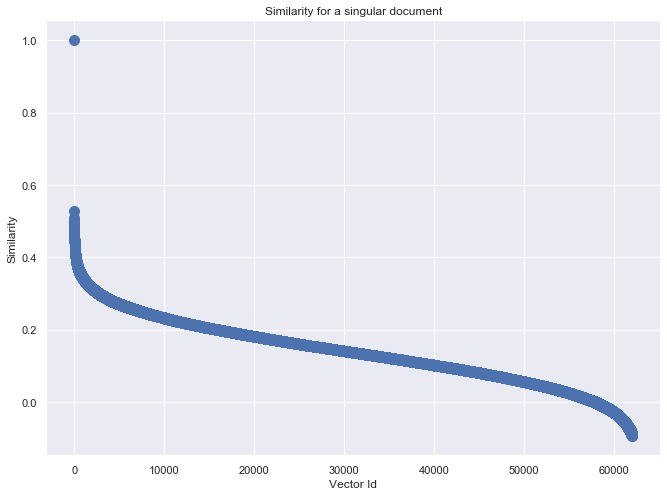

In [429]:
plt.plot(list(vec_62K_values),'.', MarkerSize = 20)
plt.xlabel('Vector Id')
plt.ylabel('Similarity')
plt.title('Similarity for a singular document');
fig = plt.gcf()
fig.set_size_inches(11,8)
plt.savefig('similarity_for_doc_1.png')

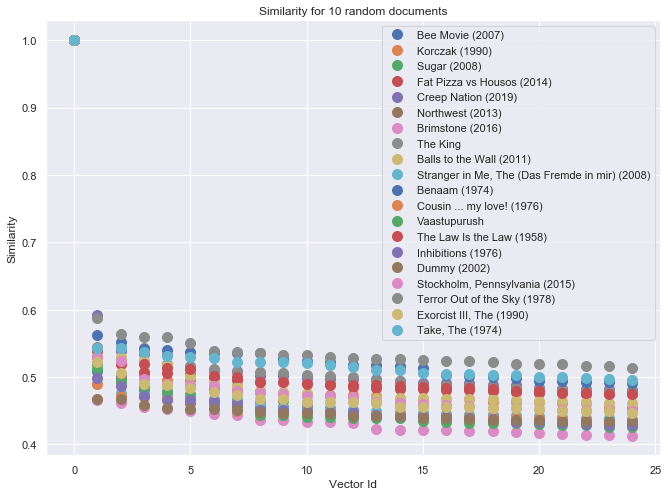

In [425]:
import random
sample = random.sample(range(len(model.docvecs)),20)
vecs = [model.docvecs[i] for i in sample]
for i, vec in enumerate(vecs):
    vec_10K = model.docvecs.most_similar([vec], topn = 25)
    vec_10K_titles , vec_10K_values = zip(*vec_10K)
    plt.plot(list(vec_10K_values),'.', label = title[sample[i]], MarkerSize = 20)
    plt.xlabel('Vector Id')
    plt.ylabel('Similarity')
    plt.title('Similarity for 10 random documents')
    plt.legend()
fig = plt.gcf()
fig.set_size_inches(11,8)
plt.savefig('random_similarity_for_multiple_docs.png')

In [86]:
def most_similar_to_vec(model, movieId, threshold):
    vec = model.docvecs[movieId]
    vec_10K = model.docvecs.most_similar([vec], topn = 10000)
    vec_10K_titles , vec_10K_values = zip(*vec_10K)
    res = np.array(vec_10K_titles)
    top_n = len(res[np.array(vec_10K_values) > threshold])
    return vec_10K[:top_n]

# Selecciono las 1000 peliculas mas populares

In [46]:
ratings_df = pd.read_csv(ratings_filename)

In [47]:
rating_per_movie = ratings_df.groupby('movieId').mean()['rating']
views_per_movie = ratings_df.groupby('movieId').count()['rating']

In [51]:
movies_votes = pd.DataFrame({'rating': rating_per_movie,'votes': views_per_movie})
movies_votes_sorted = movies_votes.sort_values(by = ['votes','rating'], ascending = False)
best_movies = movies_votes_sorted.index

In [63]:
best_1000_movies_index =[ str(i) for i in movies_df[movies_df['movieId'].isin(best_movies[:1000])].index]

### ojo que las mas votadas cambiaron de posicion!

In [99]:
#nodos = {str(movieId): most_similar_to_vec(model, movieId, 0.7) for movieId in best_1000_movies_index}
nodos = {doctag: most_similar_to_vec(model, doctag, 0.4) for doctag in notebook.tqdm(range(5000))}

In [125]:
print(title[1])
print(most_similar_to_vec(model,1,0.3)[:10])
print(title[1025])
print(most_similar_to_vec(model,1025,0.3)[:10])
print(title[27848])
print(most_similar_to_vec(model,27848,0.3)[:10])
print(title[45535])
print(most_similar_to_vec(model,45535,0.3)[:10])

Jumanji (1995)
[(1, 1.0), (4533, 0.5268319249153137), (1489, 0.5093231797218323), (1025, 0.506108283996582), (48204, 0.5056299567222595), (37373, 0.5022401809692383), (20261, 0.4989832937717438), (40927, 0.4976874589920044), (15424, 0.4966312050819397), (54252, 0.4950300455093384)]
Ghost and the Darkness, The (1996)
[(1025, 0.9999999403953552), (27848, 0.5217999219894409), (36793, 0.5114650130271912), (48393, 0.5081562995910645), (40927, 0.5080375671386719), (1, 0.506108283996582), (11485, 0.4899483621120453), (8484, 0.4794861376285553), (40189, 0.4785451889038086), (53381, 0.4765027165412903)]
Grizzly (1976)
[(27848, 1.0), (45535, 0.5505702495574951), (1025, 0.5217999219894409), (57873, 0.5003904104232788), (50801, 0.4955286383628845), (31752, 0.4866132438182831), (1380, 0.48465991020202637), (39484, 0.48014846444129944), (2568, 0.4786876440048218), (50813, 0.47752150893211365)]
Claws (1977)
[(45535, 1.0), (33576, 0.5837793350219727), (27848, 0.5505703091621399), (56298, 0.53921705484

In [196]:
vec1 = model['ninjas']
vec1_sim = model.docvecs.most_similar([vec1], topn = 1000)
vec2 = model['puppies']
vec2_sim = model.docvecs.most_similar([vec2], topn = 1000)

In [197]:
vec1_sim_doctags, vec1_sim_sim = zip(*vec1_sim)
vec2_sim_doctags, vec2_sim_sim = zip(*vec2_sim)

In [198]:
for i in set(vec1_sim_doctags).intersection(set(vec2_sim_doctags)):
    print(i, title[i])
    print('-------')
    print(overview[i])
    sim1 = vec1_sim_sim[vec1_sim_doctags.index(i)]
    sim2 = vec2_sim_sim[vec2_sim_doctags.index(i)]
    print('Similarities: ', np.round(sim1,3), np.round(sim2,3),'mean:', np.round(0.5*(sim1+sim2),3))
    print('\n')
    

56064 Gnomes (1981)
-------
A family of gnomes preparing for the wedding of their oldest son must engage in a battle of wits with an enemy family of vicious trolls.
Similarities:  0.445 0.341 mean: 0.393


45955 Lost in the Barrens (1990)
-------
The story of two very different boys in the Canadian wilderness. They must learn to depend on each other in order to survive.
Similarities:  0.328 0.34 mean: 0.334


34062 Seoul Raiders (2005)
-------
Agent Lam (Tony Leung) sets out to track a pair of plates used to make fake American dollars. When he discovers the plates, they are conned out of him by enigmatic US Embassy workers Owen (Richie Ren) and JJ (Shu Qi). With the trail now leading to Korea, Lam sets off in hot pursuit. There, amidst the dangerous and glamorous urban landscape of Seoul, Lam finds himself confronting an underworld crime boss known as the Polar Bear, head of the biggest counterfeiting organisation in Asia.
Similarities:  0.335 0.35 mean: 0.342


20625 Hansel & Gretel (

In [385]:
def find_me_something(model, full_plot, words, topn = 500):
    #Given a list of words, find the most similar movie
    assert len(words) == 2
    
    #Extract words
    word1 = words[0]
    word2 = words[1]
    
    #Search similarity
    vec1 = model[word1]
    vec1_sim = model.docvecs.most_similar([vec1], topn = topn)
    vec2 = model[word2]
    vec2_sim = model.docvecs.most_similar([vec2], topn = topn)
    
    #Unpack vectors
    vec1_sim_doctags, vec1_sim_sim = zip(*vec1_sim)
    vec2_sim_doctags, vec2_sim_sim = zip(*vec2_sim)
    # Create a list
    INTERSECTION = set(vec1_sim_doctags).intersection(set(vec2_sim_doctags))
    results = {}
    for i in INTERSECTION:
        res = {}
        res['id'] = full_plots.iloc[i].movieId
        res['title'] = full_plots.iloc[i].title
        res['overview'] = full_plots.iloc[i].overview

        sim1 = vec1_sim_sim[vec1_sim_doctags.index(i)]
        sim2 = vec2_sim_sim[vec2_sim_doctags.index(i)]

        res['similarities'] = [np.round(sim1,3), np.round(sim2,3)]
        res['mean_similarity'] = np.round(0.5*(sim1+sim2),3)
        res['std_similarity'] = np.round(np.std(np.array([np.round(sim1,3), np.round(sim2,3)])),3)
        res['inequality'] = np.round(sim1-sim2,3)
        #print(i, title[i])
        #print('-------')
        #print(overview[i])
        #print('Similarities: ', np.round(sim1,3), np.round(sim2,3),'mean:', np.round(0.5*(sim1+sim2),3))
        #print('\n')
        results[i] = res
        
    
    return results

In [386]:
results = find_me_something(model, full_plots, ['ninjas', 'puppies'], 10000)
res = pd.DataFrame(results)       
res = res.transpose()
final = res.sort_values(by=['mean_similarity'], ascending = False).head(5)
final

49155 178209
8197 8912
57349 196167
8213 8928
49177 178297
40988 160716
16425 86835
57401 196287
32826 141816
16443 86892
49218 178395
57410 196307
24644 121973
24643 121969
70 71
57417 196321
32853 141870
8278 8993
32855 141874
41048 160842
32861 141888
41057 160860
24675 122039
32869 141906
16487 87053
41066 160878
110 112
41075 160896
32884 141938
32886 141942
41080 160906
32895 141960
41089 160924
16514 87192
57478 196449
57493 196479
32922 142018
24730 122189
32936 142048
41139 161026
24756 122248
57526 196545
49340 178671
49342 178675
57537 196569
24771 122280
49356 178709
49358 178713
49360 178717
49363 178723
24788 122315
24789 122317
57558 196619
49367 178731
24792 122323
32985 142154
24794 122327
24798 122335
49375 178747
57570 196653
240 243
241 244
33009 142202
57586 196693
41204 161159
24822 122387
57591 196703
49407 178817
24834 122413
41238 161236
24857 122466
41242 161244
33051 142292
8476 25951
49439 178887
24864 122480
33059 142314
57645 196835
41262 161284
24878 1225

10741 44840
43511 166217
18944 98783
59906 201947
59908 201951
43525 166245
35335 147536
18953 98815
43530 166255
18955 98823
18957 98829
51726 183765
10768 45038
18963 98845
51733 183787
43549 166297
18973 98924
35359 147619
10784 45183
10785 45186
2604 2696
35374 147664
35375 147668
10800 45431
43568 166340
51761 183843
59950 202073
43574 166371
2617 2709
51774 183871
2628 2720
2631 2723
43591 166407
19016 99091
51785 183897
35403 147734
10828 45666
27211 128601
19023 99122
2643 2735
35416 147762
2648 2740
10844 45837
43613 166459
27230 128644
35423 147777
27233 128654
27235 128658
27238 128665
27242 128673
51823 183975
27257 128705
35453 147859
35464 147893
19087 99470
10897 46581
10902 46627
19094 99499
60056 202355
2715 2807
2716 2808
43687 166613
10924 46865
19120 99611
27314 128840
10934 46948
19126 99640
19131 99665
19137 99677
2754 2846
27329 128876
19143 99706
60117 202493
2787 2879
51941 184231
35561 148108
27371 128968
35566 148118
2803 2895
2804 2896
2805 2897
10997 47455


54528 189791
13570 70227
13574 70282
29959 135135
54536 189807
5390 5498
5393 5501
38164 154228
5396 5504
21782 112273
54552 189841
46364 172293
21791 112299
38184 154268
38185 154270
13609 70507
46378 172321
5421 5529
13613 70531
38192 154286
30004 135230
21813 112385
30013 135248
54592 189923
30018 135258
30024 135270
13642 70682
13647 70697
38230 154374
54622 190009
54623 190011
21856 112550
13665 70797
13667 70802
38259 154432
38266 154446
30081 135436
46472 172515
54670 190113
38301 154516
13725 71129
46499 172569
30117 135520
46505 172581
21931 112818
38318 154550
46512 172597
38321 154556
46525 172623
13759 71276
13760 71278
30161 135613
46547 172669
13780 71374
30182 135655
21996 113062
38385 154686
13809 71482
54770 190331
54774 190339
38396 154721
22023 113168
38409 154755
13833 71591
22026 113176
54800 190397
22036 113214
54808 190413
38429 154802
46625 172829
54831 190483
13877 71821
46646 172871
46648 172877
13880 71840
54845 190511
54848 190519
30272 135848
46665 172911
5

57311 196083
24552 121767
49135 178127
49136 178129
16371 86593
24564 121792
57335 196137
16380 86644


,id,title,overview,similarities,mean_similarity,std_similarity,inequality
6671,6794,Beethoven's 2nd (1993),"Beethoven is back -- and this time, he has a w...","[0.232, 0.618]",0.425,0.193,-0.386
29018,132987,Kill 'em All (2012),Captured international assassins are locked up...,"[0.585, 0.255]",0.42,0.165,0.331
24675,122039,Snow Buddies (2008),"Dylan Sprouse, Jim Belushi and Kris Kristoffer...","[0.322, 0.495]",0.408,0.086,-0.174
30081,135436,The Secret Life of Pets (2016),The quiet life of a terrier named Max is upend...,"[0.267, 0.524]",0.395,0.128,-0.257
56064,193357,Gnomes (1981),A family of gnomes preparing for the wedding o...,"[0.445, 0.341]",0.393,0.052,0.103


In [474]:
new_overview = []
fname = 'overview.csv'
with open(fname, "r") as fp:
    for line in fp:
        line = line.strip()
        #line=line.decode('utf-8','ignore').encode("utf-8")
        print(line)
        new_overview.append(line)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 2579: invalid start byte

In [602]:
[i for i in overview[76]

SyntaxError: unexpected EOF while parsing (<ipython-input-602-bf81bdb5b06e>, line 1)

In [541]:
str?

In [543]:
str.translate?